In [164]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
# General imports
import os
import pickle
from scipy import stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from joblib import dump, load
import pandas as pd
import seaborn as sns

# Utility imports
from utils.losses import *
from utils.plotting import *
from utils.training import *
from flows.flows import *

rc('font', size=6)        #22
rc('xtick', labelsize=5)  #15
rc('ytick', labelsize=5)  #15
rc('legend', fontsize=5)  #15
rc('text.latex', preamble=r'\usepackage{amsmath}')

np.random.seed(666) # Need to do more to ensure data is the same across runs.

In [166]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# I. Univariate Gaussians

## A. Naïve Implementation

In [52]:
# Experiment parameters
num = 0
reps = 100
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'relu'}
sqr_params = {'loss':sqr, 'output':'relu'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
mpe = make_mpe(bkgd, sgnl, 'data/normal/0.1/')

### Figure 1

### Process

In [517]:
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# Load in models.
bce_lrs = [None] * reps
mse_lrs = [None] * reps
mlc_lrs = [None] * reps
sqr_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model, m, s)
    
    mse_model = create_model(**mse_params)
    mse_model.load_weights(mse_filestr.format(N, i))
    mse_lrs[i] = odds_lr(mse_model, m, s)
    
    mlc_model = create_model(**mlc_params)
    mlc_model.load_weights(mlc_filestr.format(N, i))
    mlc_lrs[i] = pure_lr(mlc_model, m, s)
    
    sqr_model = create_model(**sqr_params)
    sqr_model.load_weights(sqr_filestr.format(N, i))
    sqr_lrs[i] = pure_lr(sqr_model, m, s)

xs = np.linspace(-6, 6, 1201)

bce_preds = get_preds(bce_lrs, xs)
mse_preds = get_preds(mse_lrs, xs)
mlc_preds = get_preds(mlc_lrs, xs)
sqr_preds = get_preds(sqr_lrs, xs)

In [518]:
np.save(filestr + 'xs', xs)
np.save(filestr + 'bce_preds', bce_preds)
np.save(filestr + 'mse_preds', mse_preds)
np.save(filestr + 'mlc_preds', mlc_preds)
np.save(filestr + 'sqr_preds', sqr_preds)

### Plot

In [53]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')

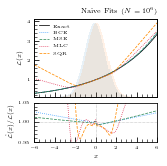

In [54]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange']
lss = [':', '--', ':', '--']
w = 2.2
h = 2.25

ratio_plot([bce_preds, mse_preds, mlc_preds, sqr_preds],
           ['BCE', 'MSE', 'MLC', 'SQR'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           cs = cs, 
           lss = lss,
           title = r'Na\"ive Fits ($N = 10^6$)',
           filename = 'plots/pres/naive_fit.pdf')

### Figure 2

#### Process

In [496]:
def get_mpes(X, y, Ns, reps, params, filestr, lr_transform, v = False):
    printv = print if v else lambda *a, **k: None
    
    mpes = np.zeros((len(Ns), reps))
    for i in range(len(Ns)): 
        N = Ns[i]
        printv(int(np.log10(N)), end = ' ')
        
        data, m, s = split_data(X[:N], y[:N])
        lrs = [None] * reps
        for j in range(reps):
            model = create_model(**params)
            model.load_weights(filestr.format(N, j))
            lrs[j] = lr_transform(model, m, s)
        
        mpes[i] = [mpe(lr) for lr in lrs]
    printv()
    return mpes

In [497]:
X = np.load('data/normal/0.1/X_trn.npy')
y = np.load('data/normal/0.1/y_trn.npy')

# Calculate mean percent errors
bce_mpes = get_mpes(X, y, Ns, reps, bce_params, bce_filestr, odds_lr, v = True)
mse_mpes = get_mpes(X, y, Ns, reps, mse_params, mse_filestr, odds_lr, v = True)
mlc_mpes = get_mpes(X, y, Ns, reps, mlc_params, mlc_filestr, pure_lr, v = True)
sqr_mpes = get_mpes(X, y, Ns, reps, sqr_params, sqr_filestr, pure_lr, v = True)

In [498]:
np.save(filestr + 'bce_mpes', bce_mpes)
np.save(filestr + 'mse_mpes', mse_mpes)
np.save(filestr + 'mlc_mpes', mlc_mpes)
np.save(filestr + 'sqr_mpes', sqr_mpes)

#### Plot

In [55]:
bce_avgs = np.load(filestr + 'bce_avg.npy')
mse_avgs = np.load(filestr + 'mse_avg.npy')
mlc_avgs = np.load(filestr + 'mlc_avg.npy')
sqr_avgs = np.load(filestr + 'sqr_avg.npy')

In [514]:
print('Performance with N = 10**6')
print('BCE:\t', bce_mpes[Ns == 10**6].mean(), '\t±\t',
      2*bce_mpes[Ns == 10**6].std(ddof = 1) / 10)
print('MSE:\t', mse_mpes[Ns == 10**6].mean(), '\t±\t',
      2*mse_mpes[Ns == 10**6].std(ddof = 1) / 10)
print('MLC:\t', mlc_mpes[Ns == 10**6].mean(), '\t±\t',
      2*mlc_mpes[Ns == 10**6].std(ddof = 1) / 10)
print('SQR:\t', sqr_mpes[Ns == 10**6].mean(), '\t±\t',
      2*sqr_mpes[Ns == 10**6].std(ddof = 1) / 10)

Performance with N = 10**6
BCE:	 0.8078709220822301 	±	 0.055807532854439304
MSE:	 0.7877747370976581 	±	 0.05733940088185442
MLC:	 1.486405306726905 	±	 0.07521539289570833
SQR:	 2.715842618189563 	±	 0.19013973494962855


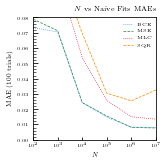

In [56]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange']
lss = [':', '--', ':', '--']
w = 2.2
h = 2.25

mae_plot([bce_avgs, mse_avgs, mlc_avgs, sqr_avgs],
         ['BCE', 'MSE', 'MLC', 'SQR'],
         Ns,
         figsize = (w, h),
         y_lim = (0, 0.08),
         cs = cs,
         lss = lss,
         title = r'$N$ vs Na\"ive Fits MAEs',
         filename = 'plots/pres/naive_sizes.pdf')

## B. Parametrizing $f$

### Figure 3

### Figure 4

## C. Generalized Loss Families

### Figure 5a

In [ ]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mpe = make_mpe(bkgd, sgnl, 'data/normal/0.1/')

#### Process

In [ ]:
def get_loss_mpe(ts, get_loss, lr_transform, m, s):
    mpes = np.zeros_like(ts)
    for t in ts:
        lrs = [None] * reps
        params = {'loss': get_loss(t)}
        for i in range(reps):
            model = create_model(**params)
            model.load_weights(filestr.format(t, i))
            lrs[i] = lr_transform(model, t, m, s)

In [ ]:
# Get model likelihood ratios.
avgs = []
for p in ps:
    lrs = [None] * reps
    params = {'loss':get_mse(p)}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, i))
        lrs[i] = pow_odds_lr(model, p, m, s)
    
    maes = [mae(lr) for lr in lrs]
    avgs += [np.mean(maes)]

avgs = np.array(avgs)

### Figure 5b

## D. Optimized Implementation

### Figure 6

### Figure 7

## E. Simple Classifiers

### Figure 8

# II. Multivariate Gaussians

## A. Parametrizing $f$

### Figure 9

### Figure 10

## B. Generalized Loss Families

# III. Physics Data

## A. Parametrizing $f$

### Figure 11

### Figure 12

### Figure 13

## B. Generalized Loss Families

### Figure 14

# Simple

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0    # bkgd: normal(-0.1, 1)     sgnl: normal(0.1, 1)
reps = 20

# File parameters
dirstr = 'models/univariate/simple/ab_mse/set_{}/'.format(num)
filestr = dirstr + 'model_{}_{}.h5'

if not os.path.isdir(dirstr):
    os.mkdir(dirstr)

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)
ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
avgs = np.load(dirstr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(0, 1)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_simple.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 0 
reps = 20

# Model parameters
dirstr = 'models/univariate/simple/ab_sqr/set_{}/'.format(num)
filestr_1 = dirstr + 'relu/model_{}_{}.h5'
filestr_2 = dirstr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### MAEs

In [ ]:
lin_avgs = np.load(dirstr + 'lin_avgs.npy')
exp_avgs = np.load(dirstr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_simple.png', 
            dpi=300, 
            bbox_inches='tight')

## Landscapes

### All

In [100]:
w = 3.5
h = 3.25

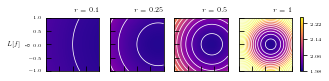

In [124]:
rs = [0.1, 0.25, 0.5, 1]
fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (4.6, 3))
axs[0].set_ylabel(r'$b$', labelpad = -3)
axs[0].text(-2.45, -0.07, r'$L[f]$')

cplots = [None] * 4
aa = np.load('anims/sqr/aa.npy')
bb = np.load('anims/sqr/bb.npy')
for i in range(len(rs)):
    r = rs[i]
    zz_loss = np.load('anims/sqr/zz_{}.npy'.format(r))
    loss_contours = np.arange(1, 3.1, 0.025)
    
    cplots[i] = axs[i].pcolormesh(aa, bb, zz_loss, cmap = 'plasma', 
                                vmin = 1.98, vmax = 2.25, zorder = -2, 
                                rasterized = True)
    axs[i].contour(aa, bb, zz_loss, levels = loss_contours, colors = 'white', linewidths = 0.75, zorder = -1)
    axs[i].set_title(r'$r = {}$'.format(r), loc = 'right')
    axs[i].set_aspect('equal')
    
    axs[i].set_xticks([-1, -0.5, 0, 0.5, 1])
    axs[i].set_xticklabels([])
    axs[i].tick_params(axis = 'y', which = 'minor', bottom = False)
    axs[i].tick_params(axis = 'x', which = 'minor', bottom = False)
    axs[i].tick_params(direction='in', which='both',length=5)

#fig.tight_layout()
    
fig.colorbar(cplots[3], ax = axs.ravel(), ticks = np.arange(1.98, 2.7, 0.08), 
             fraction = 0.01045, pad = 0.03);

plt.savefig('plots/pres/sqr_loss.pdf', 
            dpi=300, 
            bbox_inches='tight')

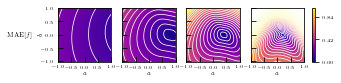

In [121]:
rs = [0.1, 0.25, 0.5, 1]
fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (4.6, 3))
axs[0].set_ylabel(r'$b$', labelpad = -3)
axs[0].text(-2.9, -0.07, r'${\rm MAE}[f]$')

cplots = [None] * 4
aa = np.load('anims/sqr/aa.npy')
bb = np.load('anims/sqr/bb.npy')
for i in range(len(rs)):
    r = rs[i]
    zz_maes = np.load('anims/sqr_mae/normal/0/zz_{}.npy'.format(r))
    maes_contours = np.arange(0, 7, 0.05)
    
    cplots[i] = axs[i].pcolormesh(aa, bb, zz_maes, cmap = 'plasma', 
                                vmin = 0, vmax = 1, zorder = -2, 
                                rasterized = True)
    axs[i].contour(aa, bb, zz_maes, levels = maes_contours, colors = 'white', linewidths = 0.75, zorder = -1)
    #axs[i].set_title(r'$r = {}$'.format(r), loc = 'right')
    axs[i].set_aspect('equal')
    
    axs[i].set_xlabel('$a$', labelpad = 1)
    axs[i].set_xticks([-1, -0.5, 0, 0.5, 1])
    axs[i].tick_params(axis = 'y', which = 'minor', bottom = False)
    axs[i].tick_params(axis = 'x', which = 'minor', bottom = False)
    axs[i].tick_params(direction='in', which='both',length=5)

#fig.tight_layout()
    
fig.colorbar(cplots[3], ax = axs.ravel(), ticks = np.arange(0, 3.71, 0.42), 
             fraction = 0.01045, pad = 0.03);

plt.savefig('plots/pres/sqr_maes.pdf', 
            dpi=300, 
            bbox_inches='tight')

### Loss

In [107]:
hh = 1.75

In [108]:
dirstr = 'anims/sqr/'

aa = np.load(dirstr + 'aa.npy')
bb = np.load(dirstr + 'bb.npy')

contours = np.arange(1, 3.1, 0.02)

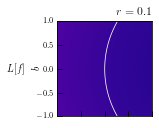

In [132]:
r = 0.1

fig = plt.figure(figsize = (3, hh))
ax = fig.add_subplot(111)
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
img = ax.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
#plt.colorbar(img, ax = [ax], pad = 0.18, location = 'left', ticks = np.arange(1.98, 2.02, 0.004))
plt.text(-2.05, -0.07, '$L[f]$')
ax.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

ax.set_title(r'$r = {}$'.format(r), loc = 'right')
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticklabels([])
ax.tick_params(axis = 'y', which = 'minor', bottom = False)
ax.tick_params(axis = 'x', which = 'minor', bottom = False)
ax.tick_params(direction='in', which='both',length=5)
ax.set_ylabel(r'$b$')
ax.yaxis.set_label_coords(-.17, .5)

ax.set_aspect('equal')
plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.25

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)

plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.5

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)

plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 1

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 1.98, vmax = 2.25)
plt.colorbar(ticks = np.arange(1.98, 2.7, 0.08))
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)
plt.title(r'$r = {}$'.format(r), loc = 'right')

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)

plt.savefig('plots/paper/sqr_loss_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

### MAE

In [ ]:
dirstr = 'anims/sqr_mae/normal/0/'

aa = np.load(dirstr + 'aa.npy')
bb = np.load(dirstr + 'bb.npy')

contours = np.arange(0, 7, 0.05)

In [ ]:
r = 0.1

fig = plt.figure(figsize = (3, hh))
ax = fig.add_subplot(111)
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
img = ax.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
#plt.colorbar(img, ax = [ax], pad = 0.18, location = 'left', ticks = np.arange(0.06, 0.28, 0.02))
plt.text(-1.8, -1.3, r'(b) Contour Plots of MAE$[f]$', rotation = 'vertical')
ax.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.tick_params(axis = 'y', which = 'minor', bottom = False)
ax.tick_params(axis = 'x', which = 'minor', bottom = False)
ax.tick_params(direction='in', which='both',length=5)
ax.set_ylabel(r'$b$')
ax.yaxis.set_label_coords(-.17, .5)
ax.set_xlabel(r'$a$')

ax.set_aspect('equal')
plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.25

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)
plt.gca().set_xlabel(r'$a$')

plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 0.5

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().set_yticklabels([])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)
plt.gca().set_xlabel(r'$a$')

plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
r = 1

plt.figure(figsize = (3, hh))
zz = np.load(dirstr + 'zz_{}.npy'.format(r))
plt.contourf(aa, bb, zz, levels = 1000, cmap = 'plasma', vmin = 0, vmax = 1)
plt.colorbar(ticks = np.arange(0, 3.71, 0.42))
plt.contour(aa, bb, zz, levels = contours, colors = 'white', linewidths = 0.75)

plt.gca().set_xticks([-1, -0.5, 0, 0.5, 1])
plt.gca().tick_params(axis = 'y', which = 'minor', bottom = False)
plt.gca().tick_params(axis = 'x', which = 'minor', bottom = False)
plt.gca().set_yticklabels([])
plt.gca().set_aspect('equal')
plt.gca().tick_params(direction='in', which='both',length=5)
plt.gca().set_xlabel(r'$a$')

plt.savefig('plots/paper/sqr_maes_{}.png'.format(r), 
            dpi=300, 
            bbox_inches='tight')

# Normal

## Naïve Implementation

In [1480]:
# Experiment parameters
num = 0
reps = 100
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce}
mse_params = {'loss':mse}
mlc_params = {'loss':mlc, 'output':'relu'}
sqr_params = {'loss':sqr, 'output':'relu'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
mpe = make_mpe(bkgd, sgnl, 'data/normal/0.1/')
mr = make_mr(bkgd, sgnl, 'data/normal/0.1/')
null_statisic = make_null_statistic(bkgd, sgnl, 'data/normal/0.1/')

### Likelihood Ratios

#### Process

#### Plot

In [161]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')

In [162]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange']
lss = [':', '--', ':', '--']

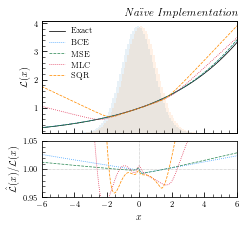

In [163]:
ratio_plot([bce_preds, mse_preds, mlc_preds, sqr_preds],
           ['BCE', 'MSE', 'MLC', 'SQR'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           cs = cs, 
           lss = lss,
           title = r'\it Na\"ive Implementation',
           filename = 'plots/paper/normal/naive_fit.pdf')

### MAEs

#### Process

In [1390]:
X = np.load('data/normal/0.1/X_trn.npy')
y = np.load('data/normal/0.1/y_trn.npy')

# Calculate mean absolute errors
bce_mrs = np.zeros((len(Ns), reps))
bce_nulls = np.zeros((len(Ns), reps))

mse_mrs = np.zeros((len(Ns), reps))
mse_nulls = np.zeros((len(Ns), reps))

mlc_mrs = np.zeros((len(Ns), reps))
mlc_nulls = np.zeros((len(Ns), reps))

sqr_mrs = np.zeros((len(Ns), reps))
sqr_nulls = np.zeros((len(Ns), reps))

for i in range(len(Ns)):
    N = Ns[i]
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    for j in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, j))
        bce_lrs[j] = odds_lr(bce_model, m, s)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, j))
        mse_lrs[j] = odds_lr(mse_model, m, s)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, j))
        mlc_lrs[j] = pure_lr(mlc_model, m, s)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, j))
        sqr_lrs[j] = pure_lr(sqr_model, m, s)
    
    bce_mrs[i] = [mr(lr) for lr in bce_lrs]
    print(np.mean(bce_mrs[i]), end = '\t')
    mse_mrs[i] = [mr(lr) for lr in mse_lrs]
    print(np.mean(mse_mrs[i]), end = '\t')
    mlc_mrs[i] = [mr(lr) for lr in mlc_lrs]
    print(np.mean(mlc_mrs[i]), end = '\t')
    sqr_mrs[i] = [mr(lr) for lr in sqr_lrs]
    print(np.mean(sqr_mrs[i]))
    
    bce_nulls[i] = [null_statistic(lr) for lr in bce_lrs]
    print(np.mean(bce_nulls[i]), end = '\t')
    mse_nulls[i] = [null_statistic(lr) for lr in mse_lrs]
    print(np.mean(mse_nulls[i]), end = '\t')
    mlc_nulls[i] = [null_statistic(lr) for lr in mlc_lrs]
    print(np.mean(mlc_nulls[i]), end = '\t')
    sqr_nulls[i] = [null_statistic(lr) for lr in sqr_lrs]
    print(np.mean(sqr_nulls[i]))

2	1.01645937269721	1.0129751303975159	0.6170206306469614	0.5746991610841208	

Exception ignored in: <function ScopedTFGraph.__del__ at 0x7f95cd6d7ac0>
Traceback (most recent call last):
  File "/clusterfs/ml4hep/shahzar/miniconda/envs/multifold/lib/python3.10/site-packages/tensorflow/python/framework/c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
AttributeError: 'ScopedTFGraph' object has no attribute 'deleter'


0.05378397613763232	0.06228787675499628	0.43248206794276356	0.4785053896905433	3	0.9287904044065534	0.9277785605554353	0.8990351878956904	0.9055931254810272	0.06956411808743602	0.07060532599702007	0.09800475746407634	0.09566000431790478	4	0.9788382761510148	0.9783550563014255	0.9701104439869705	0.9537446052145068	0.01946304664029914	0.019828839004184095	0.026577008813761058	0.04433567270650702	5	0.9912241719962587	0.9902721998058684	0.9853624677412575	0.9939882402489962	0.011301893890048351	0.012616413682840645	0.0162142559887422	0.00961509287367722	6	0.9994446291773147	0.9981002112515303	0.9917387342976192	0.9948077115445102	0.005665299445399361	0.005575400441934066	0.00988986492170838	0.008468281924822723	7	1.001096115613552	0.9993153113806753	0.9906682374182258	0.9967972084126171	0.0048600749671603525	0.004456885606105337	0.010966419875766124	0.008031311035225528	

In [1391]:
np.save(filestr + 'bce_mrs.npy', bce_mrs)
np.save(filestr + 'mse_mrs.npy', mse_mrs)
np.save(filestr + 'mlc_mrs.npy', mlc_mrs)
np.save(filestr + 'sqr_mrs.npy', sqr_mrs)

np.save(filestr + 'bce_nulls.npy', bce_nulls)
np.save(filestr + 'mse_nulls.npy', mse_nulls)
np.save(filestr + 'mlc_nulls.npy', mlc_nulls)
np.save(filestr + 'sqr_nulls.npy', sqr_nulls)

#### Plot

In [1481]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')

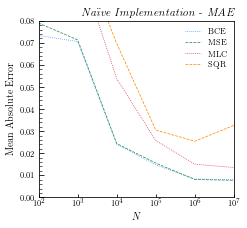

In [1482]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange']
lss = [':', '--', ':', '--']
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR'],
         Ns,
         figsize = (w, h),
         y_lim = (0, 0.08),
         cs = cs,
         lss = lss,
         title = r'\it Na\"ive Implementation - MAE',
         filename = 'plots/normal/naive_mae.png')

In [1438]:
bce_avg = np.load(filestr + 'bce_mrs.npy').mean(axis = 1)
mse_avg = np.load(filestr + 'mse_mrs.npy').mean(axis = 1)
mlc_avg = np.load(filestr + 'mlc_mrs.npy').mean(axis = 1)
sqr_avg = np.load(filestr + 'sqr_mrs.npy').mean(axis = 1)

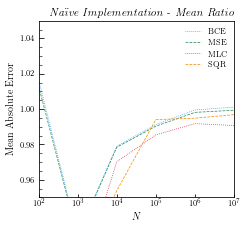

In [1439]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange']
lss = [':', '--', ':', '--']
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR'],
         Ns,
         figsize = (w, h),
         y_lim = (0.95, 1.05),
         cs = cs,
         lss = lss,
         title = r'\it Na\"ive Implementation - Mean Ratio',
         filename = 'plots/normal/naive_mr.png')

In [1440]:
bce_avg = np.load(filestr + 'bce_nulls.npy').mean(axis = 1)
mse_avg = np.load(filestr + 'mse_nulls.npy').mean(axis = 1)
mlc_avg = np.load(filestr + 'mlc_nulls.npy').mean(axis = 1)
sqr_avg = np.load(filestr + 'sqr_nulls.npy').mean(axis = 1)

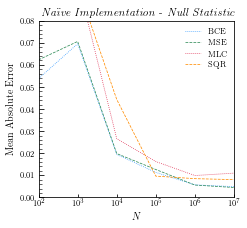

In [1441]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange']
lss = [':', '--', ':', '--']
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR'],
         Ns,
         figsize = (w, h),
         y_lim = (0, 0.08),
         cs = cs,
         lss = lss,
         title = r'\it Na\"ive Implementation - Null Statistic',
         filename = 'plots/normal/naive_null.png')

## $C$ Parametrization

### BCE $C$ Parametrization

In [57]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

w = 2.2
h = 2.25              # Plots have dimension (w,h)

#### Process

#### Likelihood Ratios

In [58]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [59]:
cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']

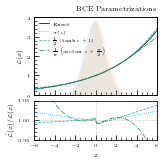

In [60]:
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'BCE Parametrizations',
           filename = 'plots/pres/c_bce.pdf')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MSE $C$ Parametrization

In [61]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [62]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

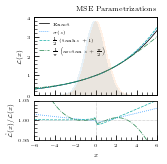

In [64]:
cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
w = 2.2
h = 2.25
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'MSE Parametrizations',
           filename = 'plots/pres/c_mse.pdf')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### MLC $C$ Parametrization

In [65]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [66]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

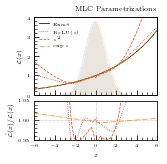

In [67]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'MLC Parametrizations',
           filename = 'plots/pres/c_mlc.pdf')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

### SQR $C$ Parametrization

In [68]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')

#### Process

#### Likelihood Ratios

In [69]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

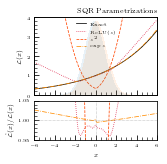

In [70]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ratio_plot([preds_1, preds_2, preds_3],
           [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'SQR Parametrizations',
           filename = 'plots/pres/c_sqr.pdf')

#### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

## Generalized Loss Families

### MLC/SQR $q$-Losses

In [1501]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/univariate/q_loss/set_{}/'.format(num)
exp_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

qs = np.round(np.linspace(-1, 2, 151), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
mr = make_mr(bkgd, sgnl, 'data/normal/0.1/')

In [1489]:
#lin_mrs = np.zeros((len(rs), reps))
exp_maes = np.zeros((len(qs), reps))
exp_mrs = np.zeros((len(qs), reps))
#lin_avgs = []
#exp_avgs = []

for i in range(len(qs)):
    q = qs[i]
    #lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    #lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_q_loss(q), 'output':'linear'}
    
    for j in range(reps):
        #lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        #lin_model.load_weights(lin_filestr.format(r, j))
        exp_model.load_weights(exp_filestr.format(q, j))
        
        #lin_lrs[j] = pow_lr(lin_model, r, m, s)
        exp_lrs[j] = pow_exp_lr(exp_model, q, m, s)
    
    #lin_maes = [mae(lr) for lr in lin_lrs]
    #exp_maes = [mae(lr) for lr in exp_lrs]
    #lin_mrs[i] = [mr(lr) for lr in lin_lrs]
    exp_maes[i] = [mae(lr) for lr in exp_lrs]
    exp_mrs[i] = [mr(lr) for lr in exp_lrs]
    
    print(q, '\t', np.round(np.mean(exp_maes[i]), 4), '\t', 
          np.round(np.mean(exp_mrs[i]), 4))
    
    #lin_avgs += [np.mean(lin_maes)]
    #exp_avgs += [np.mean(exp_maes)]
    #lin_avgs += [np.mean(lin_mrs)]
    #exp_avgs += [np.mean(exp_mrs)]

-1.0 	 nan 	 nan
-0.98 	 0.3189 	 1.0815
-0.96 	 0.3159 	 1.0793
-0.94 	 0.3123 	 1.0761
-0.92 	 0.3085 	 1.0772
-0.9 	 0.3062 	 1.0758
-0.88 	 0.3014 	 1.0722
-0.86 	 0.2977 	 1.0694
-0.84 	 0.2938 	 1.0685
-0.82 	 0.2919 	 1.0679
-0.8 	 0.2883 	 1.0636
-0.78 	 0.2859 	 1.065
-0.76 	 0.2821 	 1.0644
-0.74 	 0.2791 	 1.0637
-0.72 	 0.2766 	 1.0601
-0.7 	 0.274 	 1.06
-0.68 	 0.27 	 1.0586
-0.66 	 0.2665 	 1.058
-0.64 	 0.2619 	 1.0536
-0.62 	 0.2597 	 1.0535
-0.6 	 0.2561 	 1.0512
-0.58 	 0.2536 	 1.0515
-0.56 	 0.2504 	 1.0509
-0.54 	 0.2472 	 1.0483
-0.52 	 0.2449 	 1.0483
-0.5 	 0.2403 	 1.0461
-0.48 	 0.2372 	 1.0444
-0.46 	 0.2354 	 1.043
-0.44 	 0.2312 	 1.044
-0.42 	 0.2281 	 1.0426
-0.4 	 0.2248 	 1.0391
-0.38 	 0.2218 	 1.0388
-0.36 	 0.2178 	 1.0371
-0.34 	 0.2161 	 1.0368
-0.32 	 0.2116 	 1.0362
-0.3 	 0.2087 	 1.0343
-0.28 	 0.2061 	 1.0329
-0.26 	 0.2025 	 1.0328
-0.24 	 0.1998 	 1.0317
-0.22 	 0.1966 	 1.0299
-0.2 	 0.1934 	 1.029
-0.18 	 0.19 	 1.0284
-0.16 	 0.1868 	 1.

In [1490]:
# Save results
np.save(filestr + 'exp_maes.npy', exp_maes)
np.save(filestr + 'exp_mrs.npy', exp_mrs)

#lin_avgs = np.array(lin_avgs)
#exp_avgs = np.array(exp_avgs)

#np.save(filestr + 'lin_avgs', lin_avgs)
#np.save(filestr + 'exp_avgs', exp_avgs)

#### Plot

In [1502]:
maes = np.load(filestr + 'exp_maes.npy')

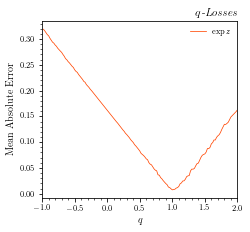

In [1506]:
plt.figure(figsize = (w, h))

plt.plot(qs, maes.mean(axis = 1), label=r'$\exp{z}$', c='orangered', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
#plt.yticks(np.arange(0, 0.022, 0.002))
#plt.tick_params(which = 'minor', length = 3)
#plt.tick_params(which = 'major', length = 5)
#plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$q$')
#plt.ylim(0.990, 1.01)
plt.xlim(-1, 2)
#plt.gca().annotate(' ', (1.0, -0.001), 
#                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
#                   annotation_clip = False)

plt.title(r"\it $q$-Losses", loc="right");
plt.savefig('plots/normal/q_mae_2.png', 
            dpi=300, 
            bbox_inches='tight')

In [1511]:
np.nanmin(maes.mean(axis = 1))

0.00759356027389062

In [1507]:
mrs = np.load(filestr + 'exp_mrs.npy').mean(axis = 1)

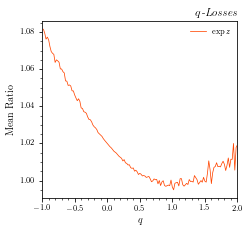

In [1508]:
plt.figure(figsize = (w, h))

plt.plot(qs, mrs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
#plt.yticks(np.arange(0, 0.022, 0.002))
#plt.tick_params(which = 'minor', length = 3)
#plt.tick_params(which = 'major', length = 5)
#plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Ratio')
plt.xlabel(r'$q$')
#plt.ylim(0.990, 1.01)
plt.xlim(-1, 2)
#plt.gca().annotate(' ', (1.0, -0.001), 
#                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
#                   annotation_clip = False)

plt.title(r"\it $q$-Losses", loc="right");
plt.savefig('plots/normal/q_mr_2.png', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [71]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
mr = make_mr(bkgd, sgnl, 'data/normal/0.1/')
null_statistic = make_null_statistic(bkgd, sgnl, 'data/normal/0.1/')

#### Process

In [1362]:
#lin_mrs = np.zeros((len(rs), reps))
exp_mrs = np.zeros((len(rs), reps))
nulls = np.zeros((len(rs), reps))
#lin_avgs = []
#exp_avgs = []

for i in range(len(rs)):
    r = rs[i]
    #lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    #lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for j in range(reps):
        #lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        #lin_model.load_weights(lin_filestr.format(r, j))
        exp_model.load_weights(exp_filestr.format(r, j))
        
        #lin_lrs[j] = pow_lr(lin_model, r, m, s)
        exp_lrs[j] = pow_exp_lr(exp_model, r, m, s)
    
    #lin_maes = [mae(lr) for lr in lin_lrs]
    #exp_maes = [mae(lr) for lr in exp_lrs]
    #lin_mrs[i] = [mr(lr) for lr in lin_lrs]
    #exp_mrs[i] = [mr(lr) for lr in exp_lrs]
    nulls[i] = [null_statistic(lr) for lr in exp_lrs]
    print(r, '\t', np.round(np.mean(nulls[i]), 4))
    
    #print(r, '\t', np.round(np.mean(lin_mrs[i]), 4), '\t', 
    #      np.round(np.mean(exp_mrs[i]), 4))
    
    #lin_avgs += [np.mean(lin_maes)]
    #exp_avgs += [np.mean(exp_maes)]
    #lin_avgs += [np.mean(lin_mrs)]
    #exp_avgs += [np.mean(exp_mrs)]

-2.0 	 0.0079
-1.95 	 0.0072
-1.9 	 0.0081
-1.85 	 0.0076
-1.8 	 0.0072
-1.75 	 0.0087
-1.7 	 0.0071
-1.65 	 0.0093
-1.6 	 0.0072
-1.55 	 0.0077
-1.5 	 0.006
-1.45 	 0.0087
-1.4 	 0.0065
-1.35 	 0.0071
-1.3 	 0.0073
-1.25 	 0.0058
-1.2 	 0.0056
-1.15 	 0.005
-1.1 	 0.0054
-1.05 	 0.0061
-1.0 	 0.0072
-0.95 	 0.0053
-0.9 	 0.0049
-0.85 	 0.005
-0.8 	 0.004
-0.75 	 0.0057
-0.7 	 0.0057
-0.65 	 0.0043
-0.6 	 0.0043
-0.55 	 0.004
-0.5 	 0.0036
-0.45 	 0.004
-0.4 	 0.0033
-0.35 	 0.0027
-0.3 	 0.0019
-0.25 	 0.0021
-0.2 	 0.0025
-0.15 	 0.0018
-0.1 	 0.0018
-0.05 	 0.0014
-0.046 	 0.0012
-0.042 	 0.0014
-0.038 	 0.0012
-0.034 	 0.0014
-0.03 	 0.0011
-0.026 	 0.001
-0.022 	 0.0012
-0.018 	 0.001
-0.014 	 0.0013
-0.01 	 0.0174
-0.006 	 0.0286
-0.002 	 0.0394
0.0 	 0.0398
0.002 	 0.0364
0.006 	 0.0218
0.01 	 0.0247
0.014 	 0.0011
0.018 	 0.0012
0.022 	 0.0011
0.026 	 0.0014
0.03 	 0.0012
0.034 	 0.0011
0.038 	 0.0012
0.042 	 0.001
0.046 	 0.0011
0.05 	 0.0012
0.1 	 0.0021
0.15 	 0.0022
0.2 	 0

In [1363]:
# Save results
np.save(filestr + 'nulls.npy', nulls)
#np.save(filestr + 'lin_mrs.npy', lin_mrs)
#np.save(filestr + 'exp_mrs.npy', exp_mrs)

#lin_avgs = np.array(lin_avgs)
#exp_avgs = np.array(exp_avgs)

#np.save(filestr + 'lin_avgs', lin_avgs)
#np.save(filestr + 'exp_avgs', exp_avgs)

#### MAEs

In [72]:
exp_avgs = np.load(filestr + 'exp_avgs.npy')
rs[exp_avgs == min(exp_avgs)]

array([0.018])

In [84]:
np.arange(0, 0.021, 0.002)

array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 ])

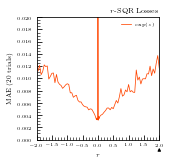

In [86]:
plt.figure(figsize = (w, h))

plt.plot(rs, exp_avgs, c='orangered', lw = 0.75, label = r'$\exp(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel(r'MAE (20 trials)')
plt.xlabel(r'$r$')
plt.ylim(0, 0.02)
plt.xlim(-2, 2)
plt.yticks(np.arange(0, 0.021, 0.002))
plt.legend(frameon = False)
plt.gca().annotate(' ', (2.0, -0.0015), 
                   arrowprops = dict(color = 'k', headlength = 2.5, headwidth = 2.5),
                   annotation_clip = False)

plt.title(r"$r$-SQR Losses", loc="right");
plt.savefig('plots/pres/rsqr.pdf', 
            dpi=300, 
            bbox_inches='tight')

### MSE $A/B$ Parametrization

In [87]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.1/X_trn.npy')[:N]
y = np.load('data/normal/0.1/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
mr = make_mr(bkgd, sgnl, 'data/normal/0.1/')
null_statistic = make_null_statistic(bkgd, sgnl, 'data/normal/0.1/')

#### Process

In [1394]:
nulls = np.zeros((len(ps), reps))

for i in range(len(ps)):
    p = ps[i]
    lrs = [None] * reps
    params = {'loss':get_mse(p)}
    
    for j in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, j))
        lrs[j] = pow_odds_lr(model, p, m, s)
    
    nulls[i] = [null_statistic(lr) for lr in lrs]
    print(p, '\t', np.round(np.mean(nulls[i]), 4))

-2.0 	 0.0115
-1.96 	 0.0091
-1.92 	 0.0088
-1.88 	 0.0111
-1.84 	 0.0095
-1.8 	 0.0085
-1.76 	 0.0103
-1.72 	 0.007
-1.68 	 0.0078
-1.64 	 0.0083
-1.6 	 0.0093
-1.56 	 0.006
-1.52 	 0.0105
-1.48 	 0.0085
-1.44 	 0.0055
-1.4 	 0.0112
-1.36 	 0.0106
-1.32 	 0.008
-1.28 	 0.0076
-1.24 	 0.0063
-1.2 	 0.0084
-1.16 	 0.0087
-1.12 	 0.0084
-1.08 	 0.0062
-1.04 	 0.0085
-1.0 	 0.0076
-0.96 	 0.0062
-0.92 	 0.0084
-0.88 	 0.0113
-0.84 	 0.0068
-0.8 	 0.0096
-0.76 	 0.007
-0.72 	 0.0073
-0.68 	 0.0092
-0.64 	 0.0064
-0.6 	 0.007
-0.56 	 0.0076
-0.52 	 0.0058
-0.48 	 0.0073
-0.44 	 0.0056
-0.4 	 0.0059
-0.36 	 0.0065
-0.32 	 0.0064
-0.28 	 0.0067
-0.24 	 0.0056
-0.2 	 0.0066
-0.16 	 0.0067
-0.12 	 0.0071
-0.08 	 0.0064
-0.04 	 0.0055
0.0 	 0.0639


/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:234: RuntimeWarning: divide by zero encountered in divide
  return np.squeeze( (f / (1. - f))**(p - 1))
/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:234: RuntimeWarning: divide by zero encountered in power
  return np.squeeze( (f / (1. - f))**(p - 1))


0.04 	 inf
0.08 	 inf
0.12 	 inf
0.16 	 inf
0.2 	 inf
0.24 	 inf
0.28 	 inf
0.32 	 inf
0.36 	 inf
0.4 	 inf
0.44 	 inf
0.48 	 inf
0.52 	 inf
0.56 	 inf
0.6 	 inf
0.64 	 inf
0.68 	 inf
0.72 	 inf
0.76 	 inf
0.8 	 inf
0.84 	 inf
0.88 	 inf
0.92 	 inf
0.96 	 inf
1.0 	 0.0398
1.04 	 0.0084
1.08 	 0.0012
1.12 	 0.0013
1.16 	 0.0014
1.2 	 0.0017
1.24 	 0.0017
1.28 	 0.0025
1.32 	 0.0025
1.36 	 0.0022
1.4 	 0.0025
1.44 	 0.0041
1.48 	 0.0032
1.52 	 0.0042
1.56 	 0.0046
1.6 	 0.0037
1.64 	 0.0037
1.68 	 0.0042
1.72 	 0.0055
1.76 	 0.0065
1.8 	 0.0046
1.84 	 0.0065
1.88 	 0.0064
1.92 	 0.0045
1.96 	 0.0054
2.0 	 0.0064


In [1395]:
np.save(filestr + 'nulls.npy', nulls)

#### MAEs

In [89]:
avgs = np.load(filestr + 'avgs.npy')

In [90]:
ps[avgs == min(avgs)]

array([1.08])

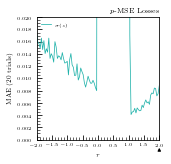

In [92]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel(r'MAE (20 trials)')
plt.xlabel(r'$r$')
plt.ylim(0, 0.02)
plt.xlim(-2, 2)
plt.yticks(np.arange(0, 0.021, 0.002))
plt.legend(frameon = False)
plt.gca().annotate(' ', (2.0, -0.0015), 
                   arrowprops = dict(color = 'k', headlength = 2.5, headwidth = 2.5),
                   annotation_clip = False)

plt.title(r"$p$-MSE Losses",loc="right");
plt.savefig('plots/pres/pmse.pdf', 
            dpi=300, 
            bbox_inches='tight')

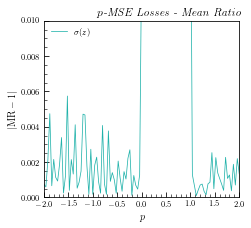

In [1462]:
plt.figure(figsize = (w, h))

plt.plot(ps, mr_dist, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel(r'$|\text{MR} - 1|$')
plt.xlabel(r'$p$')
plt.ylim(0, 0.01)
plt.xlim(-2, 2)
plt.legend(frameon = False)
#plt.gca().annotate(' ', (2.0, -0.001), 
#                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
#                   annotation_clip = False)

plt.title(r"\it $p$-MSE Losses - Mean Ratio",loc="right");
plt.savefig('plots/normal/pmse_mr.png', 
            dpi=300, 
            bbox_inches='tight')

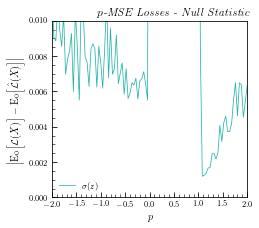

In [1464]:
plt.figure(figsize = (w, h))

plt.plot(ps, nulls_avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel(r'$\left|{\rm E}_0\Big[\mathcal{L}(X)\Big] - {\rm E}_0\Big[\hat{\mathcal{L}}(X)\Big]\right|$')
plt.xlabel(r'$p$')
plt.ylim(0, 0.01)
plt.xlim(-2, 2)
plt.legend(frameon = False)
#plt.gca().annotate(' ', (2.0, -0.001), 
#                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
#                   annotation_clip = False)

plt.title(r"\it $p$-MSE Losses - Null Statistic",loc="right");
plt.savefig('plots/normal/pmse_null.png', 
            dpi=300, 
            bbox_inches='tight')

## Optimized Implementation

In [93]:
num = 3
reps = 100
Ns = 10**np.arange(2, 8)

mu = 0.1
bkgd = stats.norm(-mu, 1)
sgnl = stats.norm(mu, 1)

mae = make_mae(bkgd, sgnl, 'data/normal/0.1/')
lr = make_lr(bkgd, sgnl)

# Model parameters
p = 1.24
r = 0.018
bce_params = {'loss':bce}
mse_params = {'loss':mse}
pmse_params = {'loss':get_mse(p)}
mlc_params = {'loss':exp_mlc, 'output':'linear'}
sqr_params = {'loss':exp_sqr, 'output':'linear'}
rsqr_params = {'loss':get_exp_sqr(r), 'output':'linear'}

p_null = 1.08   #null
r_null = 0.042  #null
pmse_params = {'loss':get_mse(p_null)}
rsqr_params = {'loss':get_exp_sqr(r_null), 'output': 'linear'}

p_mr = 1.15   #null
r_mr = 0.1  #null
pmse_mr_params = {'loss':get_mse(p_mr)}
rsqr_mr_params = {'loss':get_exp_sqr(r_mr), 'output': 'linear'}

filestr = 'models/univariate/loss_comp/set_{}/'.format(num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
mse_filestr = filestr + 'mse/model_{}_{}.h5'
mlc_filestr = filestr + 'mlc/model_{}_{}.h5'
sqr_filestr = filestr + 'sqr/model_{}_{}.h5'

#pmse_filestr = filestr + 'pmse/model_{}_{}.h5'
#rsqr_filestr = filestr + 'rsqr/model_{}_{}.h5'
pmse_filestr = filestr + 'pmse_null/model_{}_{}.h5'
rsqr_filestr = filestr + 'rsqr_null/model_{}_{}.h5'

pmse_mr_filestr = filestr + 'pmse_mr/model_{}_{}.h5'
rsqr_mr_filestr = filestr + 'rsqr_mr/model_{}_{}.h5'

### Likelihood Ratios

#### Process

#### Plot

In [94]:
xs = np.load(filestr + 'xs.npy')
bce_preds = np.load(filestr + 'bce_preds.npy')
mse_preds = np.load(filestr + 'mse_preds.npy')
mlc_preds = np.load(filestr + 'mlc_preds.npy')
sqr_preds = np.load(filestr + 'sqr_preds.npy')
pmse_preds = np.load(filestr + 'pmse_preds.npy')
rsqr_preds = np.load(filestr + 'rsqr_preds.npy')

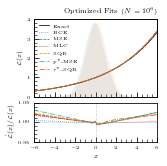

In [95]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange', 'lightseagreen', 'orangered']
lss = [':', '--', ':', '--', '-.', '-.']
ratio_plot([bce_preds, mse_preds, mlc_preds, sqr_preds, pmse_preds, rsqr_preds],
           ['BCE', 'MSE', 'MLC', 'SQR', r'$p^*$-MSE', r'$r^*$-SQR'],
           lr,
           xs,
           bkgd, sgnl,
           figsize = (w, h),
           y_lim = (0, 4),
           cs = cs,
           lss = lss,
           title = r'Optimized Fits ($N = 10^6$)',
           filename = 'plots/pres/best_fit.pdf')

### MAEs

#### Process

In [1498]:
X = np.load('data/normal/0.1/X_trn.npy')
y = np.load('data/normal/0.1/y_trn.npy')

# Calculate mean absolute errors
bce_mrs = np.zeros((len(Ns), reps))
bce_nulls = np.zeros((len(Ns), reps))

mse_mrs = np.zeros((len(Ns), reps))
mse_nulls = np.zeros((len(Ns), reps))

mlc_mrs = np.zeros((len(Ns), reps))
mlc_nulls = np.zeros((len(Ns), reps))

sqr_mrs = np.zeros((len(Ns), reps))
sqr_nulls = np.zeros((len(Ns), reps))

pmse_mrs = np.zeros((len(Ns), reps))
pmse_nulls = np.zeros((len(Ns), reps))

rsqr_mrs = np.zeros((len(Ns), reps))
rsqr_nulls = np.zeros((len(Ns), reps))

for i in range(len(Ns)):
    N = Ns[i]
    print(int(np.log10(N)))
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    mse_lrs = [None] * reps
    mlc_lrs = [None] * reps
    sqr_lrs = [None] * reps
    rsqr_lrs = [None] * reps
    pmse_lrs = [None] * reps
    rsqr_mr_lrs = [None] * reps
    pmse_mr_lrs = [None] * reps
    for j in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, j))
        bce_lrs[j] = odds_lr(bce_model, m, s)

        mse_model = create_model(**mse_params)
        mse_model.load_weights(mse_filestr.format(N, j))
        mse_lrs[j] = odds_lr(mse_model, m, s)

        mlc_model = create_model(**mlc_params)
        mlc_model.load_weights(mlc_filestr.format(N, j))
        mlc_lrs[j] = exp_lr(mlc_model, m, s)

        sqr_model = create_model(**sqr_params)
        sqr_model.load_weights(sqr_filestr.format(N, j))
        sqr_lrs[j] = exp_lr(sqr_model, m, s)
        
        pmse_model = create_model(**pmse_params)
        pmse_model.load_weights(pmse_filestr.format(N, j))
        pmse_lrs[j] = pow_odds_lr(pmse_model, p_null, m, s)
        
        rsqr_model = create_model(**rsqr_params)
        rsqr_model.load_weights(rsqr_filestr.format(N, j))
        rsqr_lrs[j] = pow_exp_lr(rsqr_model, r_null, m, s)
        
        pmse_mr_model = create_model(**pmse_mr_params)
        pmse_mr_model.load_weights(pmse_mr_filestr.format(N, j))
        pmse_mr_lrs[j] = pow_odds_lr(pmse_mr_model, p_mr, m, s)
        
        rsqr_mr_model = create_model(**rsqr_mr_params)
        rsqr_mr_model.load_weights(rsqr_mr_filestr.format(N, j))
        rsqr_mr_lrs[j] = pow_exp_lr(rsqr_mr_model, r_mr, m, s)
    
    print('MRs\t')
    bce_mrs[i] = [mr(lr) for lr in bce_lrs]
    print(np.mean(bce_mrs[i]), end = '\t')
    mse_mrs[i] = [mr(lr) for lr in mse_lrs]
    print(np.mean(mse_mrs[i]), end = '\t')
    mlc_mrs[i] = [mr(lr) for lr in mlc_lrs]
    print(np.mean(mlc_mrs[i]), end = '\t')
    sqr_mrs[i] = [mr(lr) for lr in sqr_lrs]
    print(np.mean(sqr_mrs[i]), end = '\t')
    pmse_mrs[i] = [mr(lr) for lr in pmse_mr_lrs]
    print(np.mean(pmse_mrs[i]), end = '\t')
    rsqr_mrs[i] = [mr(lr) for lr in rsqr_mr_lrs]
    print(np.mean(rsqr_mrs[i]))
    
    print('Nulls\t')
    bce_nulls[i] = [null_statistic(lr) for lr in bce_lrs]
    print(np.mean(bce_nulls[i]), end = '\t')
    mse_nulls[i] = [null_statistic(lr) for lr in mse_lrs]
    print(np.mean(mse_nulls[i]), end = '\t')
    mlc_nulls[i] = [null_statistic(lr) for lr in mlc_lrs]
    print(np.mean(mlc_nulls[i]), end = '\t')
    sqr_nulls[i] = [null_statistic(lr) for lr in sqr_lrs]
    print(np.mean(sqr_nulls[i]), end = '\t')
    pmse_nulls[i] = [null_statistic(lr) for lr in pmse_lrs]
    print(np.mean(pmse_nulls[i]), end = '\t')
    rsqr_nulls[i] = [null_statistic(lr) for lr in rsqr_lrs]
    print(np.mean(rsqr_nulls[i]))
    print()

2
MRs	
1.023294630932387	1.0035818257179583	1.025564010392393	1.033403341100353	inf	1.0131546607714852
Nulls	
0.06302219823001373	0.06342864245179201	0.05301896303891558	0.06120756328102463	inf	0.03474153846516737

3
MRs	
0.9315396879660056	0.9307341844411627	0.9276007123393848	0.9281445867008167	0.9200068511526635	0.9299322128312446
Nulls	
0.0666257616878999	0.06708790093674785	0.07117141038193829	0.07019888728871472	0.09555783957257397	0.07402342349305278

4
MRs	
0.9778921228093153	0.9786092192224125	0.9742408875410249	0.9792799984164445	0.972996647833447	0.9748638628244006
Nulls	
0.020790364444400158	0.019580308050058663	0.024351374954126658	0.019320602417130742	0.02789552420392164	0.02413484901204237

5
MRs	
0.9910402167341849	0.9896661562517854	0.9888764515097824	0.9902526057978857	0.9918677035567359	0.9923490565220853
Nulls	
0.011502739191193854	0.012981203496600474	0.014248214662219372	0.012271241843844738	0.012283464372302379	0.009444753825808849

6
MRs	
0.9984250476679624	0.99

In [1499]:
np.save(filestr + 'bce_mrs.npy', bce_mrs)
np.save(filestr + 'mse_mrs.npy', mse_mrs)
np.save(filestr + 'mlc_mrs.npy', mlc_mrs)
np.save(filestr + 'sqr_mrs.npy', sqr_mrs)
np.save(filestr + 'pmse_mrs.npy', pmse_mrs)
np.save(filestr + 'rsqr_mrs.npy', rsqr_mrs)

np.save(filestr + 'bce_nulls.npy', bce_nulls)
np.save(filestr + 'mse_nulls.npy', mse_nulls)
np.save(filestr + 'mlc_nulls.npy', mlc_nulls)
np.save(filestr + 'sqr_nulls.npy', sqr_nulls)
np.save(filestr + 'pmse_nulls.npy', pmse_nulls)
np.save(filestr + 'rsqr_nulls.npy', rsqr_nulls)

In [ ]:
#np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'mse_avg', mse_avg)
#np.save(filestr + 'mlc_avg', mlc_avg)
np.save(filestr + 'sqr_avg', sqr_avg)
#np.save(filestr + 'pmse_avg', pmse_avg)
#np.save(filestr + 'rsqr_avg', rsqr_avg)

#np.save(filestr + 'bce_std', bce_std)
#np.save(filestr + 'mse_std', mse_std)
#np.save(filestr + 'mlc_std', mlc_std)
#np.save(filestr + 'sqr_std', sqr_std)
#np.save(filestr + 'pmse_std', pmse_std)
#np.save(filestr + 'rsqr_std', rsqr_std)

#### Plot

In [96]:
bce_avg = np.load(filestr + 'bce_avg.npy')
mse_avg = np.load(filestr + 'mse_avg.npy')
mlc_avg = np.load(filestr + 'mlc_avg.npy')
sqr_avg = np.load(filestr + 'sqr_avg.npy')
pmse_avg = np.load(filestr + 'pmse_avg.npy')
rsqr_avg = np.load(filestr + 'rsqr_avg.npy')

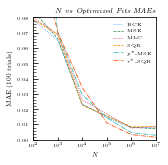

In [99]:
cs = ['dodgerblue', 'seagreen', 'crimson', 'darkorange', 'lightseagreen', 'orangered']
lss = [':', '--', ':', '--', '-.', '-.']
mae_plot([bce_avg, mse_avg, mlc_avg, sqr_avg, pmse_avg, rsqr_avg],
         ['BCE', 'MSE', 'MLC', 'SQR', r'$p^*$-MSE', r'$r^*$-SQR'],
         Ns,
         figsize = (w, h),
         y_lim = (0, 0.08),
         cs = cs,
         lss = lss,
         title = r'\it $N$ vs Optimized Fits MAEs',
         filename = 'plots/pres/best_sizes.pdf')

# Shifting Normals

## $A/B$ Parametrization

### $0.2$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.2/X_trn.npy')[:N]
y = np.load('data/normal/0.2/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.2, 1)
sgnl = stats.norm(+0.2, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.2/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.2.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.2/X_trn.npy')[:N]
y = np.load('data/normal/0.2/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.2, 1)
sgnl = stats.norm(+0.2, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.2/')

##### Process

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.2.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.3$

#### MSE $A/B$ Parametrization

In [623]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.3/X_trn.npy')[:N]
y = np.load('data/normal/0.3/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.3, 1)
sgnl = stats.norm(+0.3, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.3/')

##### Process

##### MAEs

In [624]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.56])

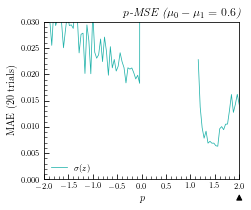

In [625]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$p$')
plt.ylim(0, 0.03)
plt.xlim(-2, 2)
plt.legend(frameon = False)
plt.gca().annotate(' ', (2.0, -0.003), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"\it $p$-MSE ($\mu_0 - \mu_1 = 0.6$)",loc="right");
plt.savefig('plots/paper/shifting/pmse_0.3.pdf', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [626]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.3/X_trn.npy')[:N]
y = np.load('data/normal/0.3/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.3, 1)
sgnl = stats.norm(+0.3, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.3/')

##### Process

##### MAEs

In [627]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([1.2]), array([0.05]))

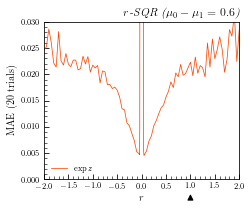

In [628]:
plt.figure(figsize = (w, h))

plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
#plt.plot(rs, lin_avgs, label=r'$ReLU(z)$', c = 'orange', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
#plt.yticks(np.arange(0, 0.022, 0.002))
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$r$')
plt.ylim(0, 0.03)
plt.xlim(-2, 2)
plt.gca().annotate(' ', (1.0, -0.003), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"\it $r$-SQR ($\mu_0 - \mu_1 = 0.6$)", loc="right");
plt.savefig('plots/paper/shifting/rsqr_exp_0.3.pdf', 
            dpi=300, 
            bbox_inches='tight')

### $0.4$

#### MSE $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.4/X_trn.npy')[:N]
y = np.load('data/normal/0.4/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.4, 1)
sgnl = stats.norm(+0.4, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.4/')

##### Process

##### MAEs

In [ ]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_0.4.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.4/X_trn.npy')[:N]
y = np.load('data/normal/0.4/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.4, 1)
sgnl = stats.norm(+0.4, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.4/')

##### Process

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [ ]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_sqr_0.4.png', 
            dpi=300, 
            bbox_inches='tight')

### $0.5$

#### MSE $A/B$ Parametrization

In [503]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.5/X_trn.npy')[:N]
y = np.load('data/normal/0.5/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.norm(-0.5, 1)
sgnl = stats.norm(+0.5, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.5/')

##### Process

In [ ]:
# Get model likelihood ratios.
avgs = []
for p in ps:
    print(p, end = '\t')
    lrs = [None] * reps
    params = {'loss':get_mse(p)}
    for i in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, i))
        lrs[i] = pow_odds_lr(model, p, m, s)
    
    maes = [mae(lr) for lr in lrs]
    avgs += [np.mean(maes)]

avgs = np.array(avgs)

In [ ]:
# Save results
np.save(filestr + 'avgs', avgs)

##### MAEs

In [504]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.88])

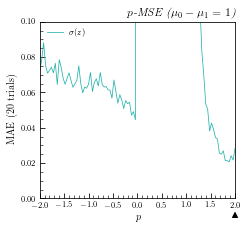

In [508]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$p$')
plt.ylim(0, 0.1)
plt.xlim(-2, 2)
plt.legend(frameon = False)
plt.gca().annotate(' ', (2.0, -0.008), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"\it $p$-MSE ($\mu_0 - \mu_1 = 1$)",loc="right");
plt.savefig('plots/paper/shifting/pmse_0.5.pdf', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [509]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/normal/0.5/X_trn.npy')[:N]
y = np.load('data/normal/0.5/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.norm(-0.5, 1)
sgnl = stats.norm(+0.5, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/normal/0.5/')

##### Process

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [510]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([1.7]), array([0.1]))

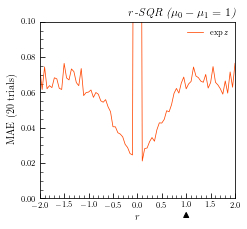

In [513]:
plt.figure(figsize = (w, h))

plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
#plt.plot(rs, lin_avgs, label=r'$ReLU(z)$', c = 'orange', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
#plt.yticks(np.arange(0, 0.022, 0.002))
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$r$')
plt.ylim(0, 0.1)
plt.xlim(-2, 2)
plt.gca().annotate(' ', (1.0, -0.008), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"\it $r$-SQR ($\mu_0 - \mu_1 = 1$)", loc="right");
plt.savefig('plots/paper/shifting/rsqr_exp_1.pdf', 
            dpi=300, 
            bbox_inches='tight')

# Beta

## $C$ Parametrizations

### BCE $C$ Parametrization

In [235]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/beta/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

In [395]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
#xs = np.linspace(0, 20, 1201)
#preds_1 = get_preds(lrs_1, xs)
#preds_2 = get_preds(lrs_2, xs)
#preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = np.array([mae(lr) for lr in lrs_1])
maes_2 = np.array([mae(lr) for lr in lrs_2])
maes_3 = np.array([mae(lr) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

#np.save(filestr + 'xs.npy', xs)
#np.save(filestr + 'preds_1.npy', preds_1)
#np.save(filestr + 'preds_2.npy', preds_2)
#np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [236]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
w = 2
h = 2.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
title = r'BCE Parametrizations'
filename = 'plots/pres/beta_c_bce.pdf'

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:143: RuntimeWarning: invalid value encountered in divide
  return lambda x: sgnl.pdf(x) / bkgd.pdf(x)


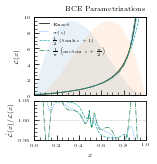

In [237]:
ratio_plot(ensembles,
           labels,
           lr,
           xs,
           bkgd = bkgd, sgnl = sgnl,
           y_lim = (0, 10),
           figsize = (w, h),
           cs = cs,
           lss = lss,
           title = title,
           filename = filename)

#### MAEs

In [411]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.3009987518379089 0.37525258057170396 0.296837416274329


### MSE $C$ Parametrization

In [238]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/beta/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

In [397]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
#xs = np.linspace(0, 20, 1201)
#preds_1 = get_preds(lrs_1, xs)
#preds_2 = get_preds(lrs_2, xs)
#preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = np.array([mae(lr) for lr in lrs_1])
maes_2 = np.array([mae(lr) for lr in lrs_2])
maes_3 = np.array([mae(lr) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

#np.save(filestr + 'xs.npy', xs)
#np.save(filestr + 'preds_1.npy', preds_1)
#np.save(filestr + 'preds_2.npy', preds_2)
#np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [239]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
w = 2
h = 2.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
title = r'MSE Parametrizations'
filename = 'plots/pres/beta_c_mse.pdf'

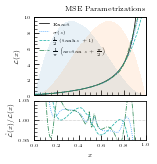

In [240]:
ratio_plot(ensembles,
           labels,
           lr,
           xs,
           bkgd = bkgd, sgnl = sgnl,
           y_lim = (0, 10),
           figsize = (w, h),
           cs = cs,
           lss = lss,
           title = title,
           filename = filename)

#### MAEs

In [413]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.321766417647324 0.39625861280195396 0.33745019402158205


### MLC $C$ Parametrization

In [241]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/beta/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

In [399]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
#xs = np.linspace(0, 20, 1201)
#preds_1 = get_preds(lrs_1, xs)
#preds_2 = get_preds(lrs_2, xs)
#preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = np.array([mae(lr) for lr in lrs_1])
maes_2 = np.array([mae(lr) for lr in lrs_2])
maes_3 = np.array([mae(lr) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

#np.save(filestr + 'xs.npy', xs)
#np.save(filestr + 'preds_1.npy', preds_1)
#np.save(filestr + 'preds_2.npy', preds_2)
#np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratio

In [242]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
w = 2
h = 2.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
title = r'MLC Parametrizations'
filename = 'plots/pres/beta_c_mlc.pdf'

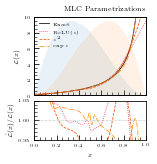

In [243]:
ratio_plot(ensembles,
           labels,
           lr,
           xs,
           bkgd = bkgd, sgnl = sgnl,
           y_lim = (0, 10),
           figsize = (w, h),
           cs = cs,
           lss = lss,
           title = title,
           filename = filename)

#### MAEs

In [415]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.45214427417887826 0.46625067901224354 0.2569671722967269


### SQR $C$ Parametrization

In [244]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/beta/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

In [401]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
#xs = np.linspace(0, 20, 1201)
#preds_1 = get_preds(lrs_1, xs)
#preds_2 = get_preds(lrs_2, xs)
#preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = np.array([mae(lr) for lr in lrs_1])
maes_2 = np.array([mae(lr) for lr in lrs_2])
maes_3 = np.array([mae(lr) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

#np.save(filestr + 'xs.npy', xs)
#np.save(filestr + 'preds_1.npy', preds_1)
#np.save(filestr + 'preds_2.npy', preds_2)
#np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [245]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
w = 2
h = 2.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
title = r'SQR Parametrizations'
filename = 'plots/pres/beta_c_sqr.pdf'

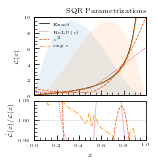

In [246]:
ratio_plot(ensembles,
           labels,
           lr,
           xs,
           bkgd = bkgd, sgnl = sgnl,
           y_lim = (0, 10),
           figsize = (w, h),
           cs = cs,
           lss = lss,
           title = title,
           filename = filename)

#### MAEs

In [417]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.6735905796196251 1.1713169469877527 0.2880978314542275


## Parametrizations Bar Charts

In [249]:
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15

In [250]:
bce_avgs = np.zeros(3)
bce_stds = np.zeros(3)
bce_filestr = 'models/univariate/beta/c_bce/set_0/'
for i in range(3):
    maes = np.load(bce_filestr + 'maes_{}.npy'.format(i + 1))
    bce_avgs[i] = np.mean(maes)
    bce_stds[i] = np.std(maes, ddof = 1) / 10
    
mse_avgs = np.zeros(3)
mse_stds = np.zeros(3)
mse_filestr = 'models/univariate/beta/c_mse/set_0/'
for i in range(3):
    maes = np.load(mse_filestr + 'maes_{}.npy'.format(i + 1))
    mse_avgs[i] = np.mean(maes)
    mse_stds[i] = np.std(maes, ddof = 1) / 10
    
mlc_avgs = np.zeros(3)
mlc_stds = np.zeros(3)
mlc_filestr = 'models/univariate/beta/c_mlc/set_0/'
for i in range(3):
    maes = np.load(mlc_filestr + 'maes_{}.npy'.format(i + 1))
    mlc_avgs[i] = np.mean(maes)
    mlc_stds[i] = np.std(maes, ddof = 1) / 10
    
sqr_avgs = np.zeros(3)
sqr_stds = np.zeros(3)
sqr_filestr = 'models/univariate/beta/c_sqr/set_0/'
for i in range(3):
    maes = np.load(sqr_filestr + 'maes_{}.npy'.format(i + 1))
    sqr_avgs[i] = np.mean(maes)
    sqr_stds[i] = np.std(maes, ddof = 1) / 10

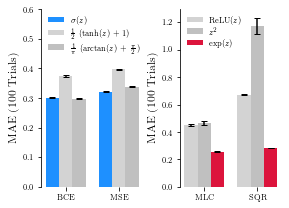

In [251]:
fig, axs = plt.subplots(1, 2, figsize = (4, 3))
fig.tight_layout()
width = 0.05

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].bar(0, bce_avgs[0], width = width, color = 'dodgerblue', label = r'$\sigma(z)$')
axs[0].errorbar(0, bce_avgs[0], yerr = bce_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + width, bce_avgs[1], width = width, color = 'lightgrey', label = r'$\frac{1}{2}$ (tanh($z$) + 1)')
axs[0].errorbar(0 + width, bce_avgs[1], yerr = bce_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 2*width, bce_avgs[2], width = width, color = 'silver', label = r'$\frac{1}{\pi}$ (arctan($z$) + $\frac{\pi}{2}$)')
axs[0].errorbar(0 + 2*width, bce_avgs[2], yerr = bce_stds[2], color = 'black', capsize=3, linestyle='none')

axs[0].bar(0 + 4*width, mse_avgs[0], width = width, color = 'dodgerblue')
axs[0].errorbar(0 + 4*width, mse_avgs[0], yerr = mse_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 5*width, mse_avgs[1], width = width, color = 'lightgrey')
axs[0].errorbar(0 + 5*width, mse_avgs[1], yerr = mse_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 6*width, mse_avgs[2], width = width, color = 'silver')
axs[0].errorbar(0 + 6*width, mse_avgs[2], yerr = mse_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[0].set_ylim(0, 0.60)
axs[0].legend(frameon=False, loc = 'upper left')
axs[0].set_xticks([width, 5*width], ['BCE', 'MSE'])
axs[0].set_ylabel('MAE (100 Trials)',  fontsize = 12)

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].bar(0, mlc_avgs[0], width = width, color = 'lightgrey', label = r'ReLU($z$)')
axs[1].errorbar(0, mlc_avgs[0], yerr = mlc_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + width, mlc_avgs[1], width = width, color = 'silver', label = r'$z^2$')
axs[1].errorbar(0 + width, mlc_avgs[1], yerr = mlc_stds[1], color = 'black', capsize=3, linestyle='none')
axs[1].bar(0 + 2*width, mlc_avgs[2], width = width, color = 'crimson', label = r'$\exp(z)$')
axs[1].errorbar(0 + 2*width, mlc_avgs[2], yerr = mlc_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[1].legend(loc = 'upper left', frameon=False)

axs[1].bar(0 + 4*width, sqr_avgs[0], width = width, color = 'lightgrey')
axs[1].errorbar(0 + 4*width, sqr_avgs[0], yerr = sqr_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + 5*width, sqr_avgs[1], width = width, color = 'silver')
axs[1].errorbar(0 + 5*width, sqr_avgs[1], yerr = sqr_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + 6*width, sqr_avgs[2], width = width, color = 'crimson')
axs[1].errorbar(0 + 6*width, sqr_avgs[2], yerr = sqr_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[1].legend(frameon=False, loc = 'upper left')
axs[1].set_xticks([width, 5*width], ['MLC', 'SQR'])
axs[1].set_ylabel('MAE (100 Trials)',  fontsize = 12)

plt.savefig('plots/pres/beta_losses.pdf', dpi = 300, bbox_inches = 'tight')

## $A/B$ Parametrization

### MSE $A/B$ Parametrization

In [252]:
rc('font', size=6)        #22
rc('xtick', labelsize=5)  #15
rc('ytick', labelsize=5)  #15
rc('legend', fontsize=5)  #15

In [253]:
# Experiment parameters
num = 5
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### MAEs

In [254]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([-0.2])

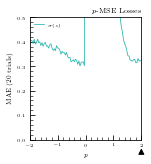

In [257]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$p$')
plt.ylim(0, 0.5)
plt.xlim(-2, 2)
plt.legend(frameon = False)
plt.gca().annotate(' ', (2.0, -0.04), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"$p$-MSE Losses",loc="right");
plt.savefig('plots/pres/beta_pmse.pdf', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [258]:
# Experiment parameters
num = 5
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

#### Process

#### MAEs

In [259]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([1.95]), array([0.15]))

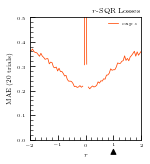

In [260]:
plt.figure(figsize = (w, h))

plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
#plt.plot(rs, lin_avgs, label=r'$ReLU(z)$', c = 'orange', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
#plt.yticks(np.arange(0, 0.022, 0.002))
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$r$')
plt.ylim(0, 0.5)
plt.xlim(-2, 2)
plt.gca().annotate(' ', (1.0, -0.04), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"$r$-SQR Losses", loc="right");
plt.savefig('plots/pres/beta_rsqr.pdf', 
            dpi=300, 
            bbox_inches='tight')

## $A/B$ Performance

### $p^*$-MSE

In [402]:
# Experiment parameters
num = 7
reps = 100

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

p_star = -0.2

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

In [403]:
lrs = [None] * reps
params = {'loss':get_mse(p_star)}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(mse_filestr.format(i))
    lrs[i] = pow_odds_lr(model, p_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.31131760903997985 0.0030724884032173423


### $r^*$-SQR

In [422]:
# Experiment parameters
num = 7
reps = 100

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/beta/X_trn.npy')[:N]
y = np.load('data/beta/y_trn.npy')[:N]
data, m, s = split_data(X, y)

r_star = 0.15

# True distribution information
bkgd = stats.beta(2, 3)
sgnl = stats.beta(3, 2)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/beta/')

In [423]:
lrs = [None] * reps
params = {'loss':get_exp_sqr(r_star), 'output': 'linear'}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(sqr_filestr.format(i))
    lrs[i] = pow_exp_lr(model, r_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.21496991355361786 0.0018294625815461472


## Best Bar Chart

In [261]:
bce_avg = np.zeros(3)
bce_std = np.zeros(3)
bce_filestr = 'models/univariate/beta/c_bce/set_0/'
for i in range(3):
    maes = np.load(bce_filestr + 'maes_{}.npy'.format(i + 1))
    bce_avgs[i] = np.mean(maes)
    bce_stds[i] = np.std(maes, ddof = 1) / 10
    
mse_avgs = np.zeros(3)
mse_stds = np.zeros(3)
mse_filestr = 'models/univariate/beta/c_mse/set_0/'
for i in range(3):
    maes = np.load(mse_filestr + 'maes_{}.npy'.format(i + 1))
    mse_avgs[i] = np.mean(maes)
    mse_stds[i] = np.std(maes, ddof = 1) / 10
    
mlc_avgs = np.zeros(3)
mlc_stds = np.zeros(3)
mlc_filestr = 'models/univariate/beta/c_mlc/set_0/'
for i in range(3):
    maes = np.load(mlc_filestr + 'maes_{}.npy'.format(i + 1))
    mlc_avgs[i] = np.mean(maes)
    mlc_stds[i] = np.std(maes, ddof = 1) / 10
    
sqr_avgs = np.zeros(3)
sqr_stds = np.zeros(3)
sqr_filestr = 'models/univariate/beta/c_sqr/set_0/'
for i in range(3):
    maes = np.load(sqr_filestr + 'maes_{}.npy'.format(i + 1))
    sqr_avgs[i] = np.mean(maes)
    sqr_stds[i] = np.std(maes, ddof = 1) / 10


# BCE atan
bce_avg = bce_avgs[2]
bce_std = bce_stds[2]

# MSE atan
mse_avg = mse_avgs[0]
mse_std = mse_stds[0]

# MLC relu
mlc_avg = mlc_avgs[2]
mlc_std = mlc_stds[2]

# SQR exp
sqr_avg = bce_avgs[2]
sqr_std = bce_stds[2]

# p-MSE
filestr = 'models/univariate/ab_mse/set_7/'
pmse_maes = np.load(filestr + 'maes.npy')
pmse_avg = np.mean(pmse_maes)
pmse_std = np.std(pmse_maes, ddof = 1) / 10

# r-SQR
filestr = 'models/univariate/ab_sqr/set_7/'
rsqr_maes = np.load(filestr + 'maes.npy')
rsqr_avg = np.mean(rsqr_maes)
rsqr_std = np.std(rsqr_maes, ddof = 1) / 10

In [262]:
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15

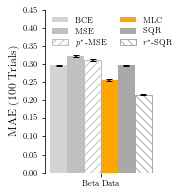

In [263]:
plt.figure(figsize = (2, 3))

width = 0.05

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.bar(0, bce_avg, width = width, color = 'lightgrey', label = r'BCE')
plt.errorbar(0, bce_avg, yerr = bce_std, color = 'black', capsize=3, linestyle='none') 

plt.bar(0 + width, mse_avg, width = width, color = 'silver', label = r'MSE')
plt.errorbar(0 + width, mse_avg, yerr = mse_std, color = 'black', capsize=3, linestyle='none') 

plt.bar(0 + 2*width, pmse_avg, width = width, fill = None, edgecolor = 'silver', label = r'$p^*$-MSE', hatch = '///')
plt.errorbar(0 + 2*width, pmse_avg, yerr = pmse_std, color = 'black', capsize=3, linestyle='none')

plt.bar(0 + 3*width, mlc_avg, width = width, color = 'orange', label = r'MLC')
plt.errorbar(0 + 3*width, mlc_avg, yerr = mlc_std, color = 'black', capsize=3, linestyle='none')

plt.bar(0 + 4*width, sqr_avg, width = width, color = 'darkgrey', label = r'SQR')
plt.errorbar(0 + 4*width, sqr_avg, yerr = sqr_std, color = 'black', capsize=3, linestyle='none')

plt.bar(0 + 5*width, rsqr_avg, width = width, fill = None, edgecolor = 'darkgrey', label = r'$r^*$-SQR', hatch = '\\\\\\')
plt.errorbar(0 + 5*width, rsqr_avg, yerr = rsqr_std, color = 'black', capsize=3, linestyle='none')

plt.xticks([2.5*width], ['Beta Data'])
plt.legend(frameon=False, loc = 'upper left', ncol = 2)
plt.ylabel('MAE (100 Trials)',  fontsize = 12)
plt.ylim(0, 0.45)

plt.savefig('plots/pres/beta_best_losses.pdf', dpi = 300, bbox_inches = 'tight')

# Gamma

In [264]:
rc('font', size=6)        #22
rc('xtick', labelsize=5)  #15
rc('ytick', labelsize=5)  #15
rc('legend', fontsize=5)  #15

## $C$ Parametrizations

### BCE $C$ Parametrizations

In [265]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce}
params_2 = {'loss':tanh_bce, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [212]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
#xs = np.linspace(0, 20, 1201)
#preds_1 = get_preds(lrs_1, xs)
#preds_2 = get_preds(lrs_2, xs)
#preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = np.array([mae(lr) for lr in lrs_1])
maes_2 = np.array([mae(lr) for lr in lrs_2])
maes_3 = np.array([mae(lr) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

#np.save(filestr + 'xs.npy', xs)
#np.save(filestr + 'preds_1.npy', preds_1)
#np.save(filestr + 'preds_2.npy', preds_2)
#np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [266]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
w = 2
h = 2.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
title = r'BCE Parametrizations'
filename = 'plots/pres/gamma_c_bce.pdf'

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:143: RuntimeWarning: invalid value encountered in divide
  return lambda x: sgnl.pdf(x) / bkgd.pdf(x)


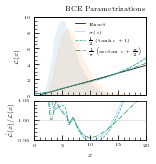

In [267]:
ratio_plot(ensembles,
           labels,
           lr,
           xs,
           bkgd = bkgd, sgnl = sgnl,
           y_lim = (0, 10),
           figsize = (w, h),
           cs = cs,
           lss = lss,
           title = title,
           filename = filename)

#### MAEs

In [189]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.027465186165653382 0.035716228433331304 0.027107355037326274


### MSE $C$ Parametrizations

In [268]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse}
params_2 = {'loss':tanh_mse, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [215]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
#xs = np.linspace(0, 20, 1201)
#preds_1 = get_preds(lrs_1, xs)
#preds_2 = get_preds(lrs_2, xs)
#preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = np.array([mae(lr) for lr in lrs_1])
maes_2 = np.array([mae(lr) for lr in lrs_2])
maes_3 = np.array([mae(lr) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

#np.save(filestr + 'xs.npy', xs)
#np.save(filestr + 'preds_1.npy', preds_1)
#np.save(filestr + 'preds_2.npy', preds_2)
#np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [269]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
w = 2
h = 2.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
title = r'MSE Parametrizations'
filename = 'plots/pres/gamma_c_mse.pdf'

/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:143: RuntimeWarning: invalid value encountered in divide
  return lambda x: sgnl.pdf(x) / bkgd.pdf(x)


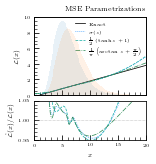

In [270]:
ratio_plot(ensembles,
           labels,
           lr,
           xs,
           bkgd = bkgd, sgnl = sgnl,
           y_lim = (0, 10),
           figsize = (w, h),
           cs = cs,
           lss = lss,
           title = title,
           filename = filename)

#### MAEs

In [193]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.02722217922370669 0.034009872082903 0.026290712516769697


### MLC $C$ Parametrizations

In [271]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [217]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
#xs = np.linspace(0, 20, 1201)
#preds_1 = get_preds(lrs_1, xs)
#preds_2 = get_preds(lrs_2, xs)
#preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = np.array([mae(lr) for lr in lrs_1])
maes_2 = np.array([mae(lr) for lr in lrs_2])
maes_3 = np.array([mae(lr) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

#np.save(filestr + 'xs.npy', xs)
#np.save(filestr + 'preds_1.npy', preds_1)
#np.save(filestr + 'preds_2.npy', preds_2)
#np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [272]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
w = 2
h = 2.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
title = r'MLC Parametrizations'
filename = 'plots/pres/gamma_c_mlc.pdf'

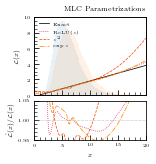

In [273]:
ratio_plot(ensembles,
           labels,
           lr,
           xs,
           bkgd = bkgd, sgnl = sgnl,
           y_lim = (0, 10),
           figsize = (w, h),
           cs = cs,
           lss = lss,
           title = title,
           filename = filename)

#### MAEs

In [393]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.016490095866959625 0.12557998113665148 0.027487554141465975


### SQR $C$ Parametrizations

In [274]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'output': 'linear'}

filestr = 'models/univariate/gamma/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

In [219]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
#xs = np.linspace(0, 20, 1201)
#preds_1 = get_preds(lrs_1, xs)
#preds_2 = get_preds(lrs_2, xs)
#preds_3 = get_preds(lrs_3, xs)

# Calculate mean absolute errors
maes_1 = np.array([mae(lr) for lr in lrs_1])
maes_2 = np.array([mae(lr) for lr in lrs_2])
maes_3 = np.array([mae(lr) for lr in lrs_3])

#avg_1 = np.mean(maes_1)
#avg_2 = np.mean(maes_2)
#avg_3 = np.mean(maes_3)

# Save results
np.save(filestr + 'maes_1.npy', maes_1)
np.save(filestr + 'maes_2.npy', maes_2)
np.save(filestr + 'maes_3.npy', maes_3)

#np.save(filestr + 'xs.npy', xs)
#np.save(filestr + 'preds_1.npy', preds_1)
#np.save(filestr + 'preds_2.npy', preds_2)
#np.save(filestr + 'preds_3.npy', preds_3)

#### Likelihood Ratios

In [275]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
w = 2
h = 2.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
title = r'SQR Parametrizations'
filename = 'plots/pres/gamma_c_sqr.pdf'

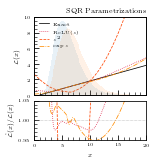

In [276]:
xs = np.load(filestr + 'xs.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

ratio_plot(ensembles,
           labels,
           lr,
           xs,
           bkgd = bkgd, sgnl = sgnl,
           y_lim = (0, 10),
           figsize = (w, h),
           cs = cs,
           lss = lss,
           title = title,
           filename = filename)

#### MAEs

In [391]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

print(avg_1, avg_2, avg_3)

0.03430965759842392 0.760540841220187 0.028455596365532743


## Parametrizations Bar Chart

In [277]:
bce_avgs = np.zeros(3)
bce_stds = np.zeros(3)
bce_filestr = 'models/univariate/gamma/c_bce/set_0/'
for i in range(3):
    maes = np.load(bce_filestr + 'maes_{}.npy'.format(i + 1))
    bce_avgs[i] = np.mean(maes)
    bce_stds[i] = np.std(maes, ddof = 1) / 10
    
mse_avgs = np.zeros(3)
mse_stds = np.zeros(3)
mse_filestr = 'models/univariate/gamma/c_mse/set_0/'
for i in range(3):
    maes = np.load(mse_filestr + 'maes_{}.npy'.format(i + 1))
    mse_avgs[i] = np.mean(maes)
    mse_stds[i] = np.std(maes, ddof = 1) / 10
    
mlc_avgs = np.zeros(3)
mlc_stds = np.zeros(3)
mlc_filestr = 'models/univariate/gamma/c_mlc/set_0/'
for i in range(3):
    maes = np.load(mlc_filestr + 'maes_{}.npy'.format(i + 1))
    mlc_avgs[i] = np.mean(maes)
    mlc_stds[i] = np.std(maes, ddof = 1) / 10
    
sqr_avgs = np.zeros(3)
sqr_stds = np.zeros(3)
sqr_filestr = 'models/univariate/gamma/c_sqr/set_0/'
for i in range(3):
    maes = np.load(sqr_filestr + 'maes_{}.npy'.format(i + 1))
    sqr_avgs[i] = np.mean(maes)
    sqr_stds[i] = np.std(maes, ddof = 1) / 10

In [278]:
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15

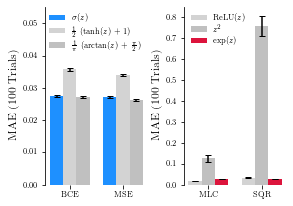

In [279]:
fig, axs = plt.subplots(1, 2, figsize = (4, 3))
fig.tight_layout()
width = 0.05

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].bar(0, bce_avgs[0], width = width, color = 'dodgerblue', label = r'$\sigma(z)$')
axs[0].errorbar(0, bce_avgs[0], yerr = bce_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + width, bce_avgs[1], width = width, color = 'lightgrey', label = r'$\frac{1}{2}$ (tanh($z$) + 1)')
axs[0].errorbar(0 + width, bce_avgs[1], yerr = bce_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 2*width, bce_avgs[2], width = width, color = 'silver', label = r'$\frac{1}{\pi}$ (arctan($z$) + $\frac{\pi}{2}$)')
axs[0].errorbar(0 + 2*width, bce_avgs[2], yerr = bce_stds[2], color = 'black', capsize=3, linestyle='none')

axs[0].bar(0 + 4*width, mse_avgs[0], width = width, color = 'dodgerblue')
axs[0].errorbar(0 + 4*width, mse_avgs[0], yerr = mse_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 5*width, mse_avgs[1], width = width, color = 'lightgrey')
axs[0].errorbar(0 + 5*width, mse_avgs[1], yerr = mse_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 6*width, mse_avgs[2], width = width, color = 'silver')
axs[0].errorbar(0 + 6*width, mse_avgs[2], yerr = mse_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[0].set_ylim(0, 0.055)
axs[0].legend(frameon=False, loc = 'best')
axs[0].set_xticks([width, 5*width], ['BCE', 'MSE'])
axs[0].set_ylabel('MAE (100 Trials)',  fontsize = 12)

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].bar(0, mlc_avgs[0], width = width, color = 'lightgrey', label = r'ReLU($z$)')
axs[1].errorbar(0, mlc_avgs[0], yerr = mlc_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + width, mlc_avgs[1], width = width, color = 'silver', label = r'$z^2$')
axs[1].errorbar(0 + width, mlc_avgs[1], yerr = mlc_stds[1], color = 'black', capsize=3, linestyle='none')
axs[1].bar(0 + 2*width, mlc_avgs[2], width = width, color = 'crimson', label = r'$\exp(z)$')
axs[1].errorbar(0 + 2*width, mlc_avgs[2], yerr = mlc_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[1].legend(loc = 'upper left', frameon=False)

axs[1].bar(0 + 4*width, sqr_avgs[0], width = width, color = 'lightgrey')
axs[1].errorbar(0 + 4*width, sqr_avgs[0], yerr = sqr_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + 5*width, sqr_avgs[1], width = width, color = 'silver')
axs[1].errorbar(0 + 5*width, sqr_avgs[1], yerr = sqr_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + 6*width, sqr_avgs[2], width = width, color = 'crimson')
axs[1].errorbar(0 + 6*width, sqr_avgs[2], yerr = sqr_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[1].legend(frameon=False, loc = 'upper left')
axs[1].set_xticks([width, 5*width], ['MLC', 'SQR'])
axs[1].set_ylabel('MAE (100 Trials)',  fontsize = 12)

plt.savefig('plots/pres/gamma_losses.pdf', dpi = 300, bbox_inches = 'tight')

## $A/B$ Parametrization

In [280]:
rc('font', size=6)        #22
rc('xtick', labelsize=5)  #15
rc('ytick', labelsize=5)  #15
rc('legend', fontsize=5)  #15

### MSE $A/B$ Parametrization

In [281]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

#### MAEs

In [282]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.44])

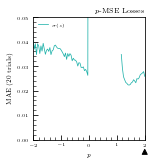

In [284]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$p$')
plt.ylim(0, 0.05)
plt.xlim(-2, 2)
plt.legend(frameon = False)
plt.gca().annotate(' ', (2.0, -0.004), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"$p$-MSE Losses",loc="right");
plt.savefig('plots/pres/gamma_pmse.pdf', 
            dpi=300, 
            bbox_inches='tight')

### SQR $A/B$ Parametrization

In [285]:
# Experiment parameters
num = 6
reps = 20

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

#### Process

#### MAEs

In [286]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([0.55]), array([-0.046]))

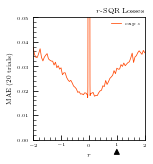

In [288]:
w = 2
h = 2.25
plt.figure(figsize = (w, h))

plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
#plt.plot(rs, lin_avgs, label=r'$ReLU(z)$', c = 'orange', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
#plt.yticks(np.arange(0, 0.022, 0.002))
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$r$')
plt.ylim(0, 0.05)
plt.xlim(-2, 2)
plt.gca().annotate(' ', (1.0, -0.004), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"$r$-SQR Losses", loc="right");
plt.savefig('plots/pres/gamma_rsqr.pdf', 
            dpi=300, 
            bbox_inches='tight')

## $A/B$ Performance

### $p^*$-MSE

In [406]:
# Experiment parameters
num = 8
reps = 100

# File parameters
filestr = 'models/univariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

p_star = 1.44

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

In [407]:
lrs = [None] * reps
params = {'loss':get_mse(p_star)}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(mse_filestr.format(i))
    lrs[i] = pow_odds_lr(model, p_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.022876981836512527 0.000143984884015731


### $r^*$-SQR

In [475]:
# Experiment parameters
num = 8
reps = 100

# File parameters
filestr = 'models/univariate/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/gamma/X_trn.npy')[:N]
y = np.load('data/gamma/y_trn.npy')[:N]
data, m, s = split_data(X, y)

r_star = -0.046

# True distribution information
bkgd = stats.gamma(5, 1)
sgnl = stats.gamma(6, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/gamma/')

In [476]:
lrs = [None] * reps
params = {'loss':get_exp_sqr(r_star), 'output': 'linear'}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(sqr_filestr.format(i))
    lrs[i] = pow_exp_lr(model, r_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.017813951231029905 0.0001890778702695317


## Best Bar Chart

In [289]:
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15

In [290]:
bce_avg = np.zeros(3)
bce_std = np.zeros(3)
bce_filestr = 'models/univariate/gamma/c_bce/set_0/'
for i in range(3):
    maes = np.load(bce_filestr + 'maes_{}.npy'.format(i + 1))
    bce_avgs[i] = np.mean(maes)
    bce_stds[i] = np.std(maes, ddof = 1) / 10
    
mse_avgs = np.zeros(3)
mse_stds = np.zeros(3)
mse_filestr = 'models/univariate/gamma/c_mse/set_0/'
for i in range(3):
    maes = np.load(mse_filestr + 'maes_{}.npy'.format(i + 1))
    mse_avgs[i] = np.mean(maes)
    mse_stds[i] = np.std(maes, ddof = 1) / 10
    
mlc_avgs = np.zeros(3)
mlc_stds = np.zeros(3)
mlc_filestr = 'models/univariate/gamma/c_mlc/set_0/'
for i in range(3):
    maes = np.load(mlc_filestr + 'maes_{}.npy'.format(i + 1))
    mlc_avgs[i] = np.mean(maes)
    mlc_stds[i] = np.std(maes, ddof = 1) / 10
    
sqr_avgs = np.zeros(3)
sqr_stds = np.zeros(3)
sqr_filestr = 'models/univariate/gamma/c_sqr/set_0/'
for i in range(3):
    maes = np.load(sqr_filestr + 'maes_{}.npy'.format(i + 1))
    sqr_avgs[i] = np.mean(maes)
    sqr_stds[i] = np.std(maes, ddof = 1) / 10


# BCE atan
bce_avg = bce_avgs[2]
bce_std = bce_stds[2]

# MSE atan
mse_avg = mse_avgs[2]
mse_std = mse_stds[2]

# MLC relu
mlc_avg = mlc_avgs[0]
mlc_std = mlc_stds[0]

# SQR exp
sqr_avg = bce_avgs[2]
sqr_std = bce_stds[2]

# p-MSE
filestr = 'models/univariate/ab_mse/set_8/'
pmse_maes = np.load(filestr + 'maes.npy')
pmse_avg = np.mean(pmse_maes)
pmse_std = np.std(pmse_maes, ddof = 1) / 10

# r-SQR
filestr = 'models/univariate/ab_sqr/set_8/'
rsqr_maes = np.load(filestr + 'maes.npy')
rsqr_avg = np.mean(rsqr_maes)
rsqr_std = np.std(rsqr_maes, ddof = 1) / 10

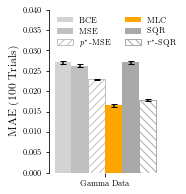

In [291]:
plt.figure(figsize = (2, 3))

width = 0.05

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.bar(0, bce_avg, width = width, color = 'lightgrey', label = r'BCE')
plt.errorbar(0, bce_avg, yerr = bce_std, color = 'black', capsize=3, linestyle='none') 

plt.bar(0 + width, mse_avg, width = width, color = 'silver', label = r'MSE')
plt.errorbar(0 + width, mse_avg, yerr = mse_std, color = 'black', capsize=3, linestyle='none') 

plt.bar(0 + 2*width, pmse_avg, width = width, fill = None, edgecolor = 'silver', label = r'$p^*$-MSE', hatch = '///')
plt.errorbar(0 + 2*width, pmse_avg, yerr = pmse_std, color = 'black', capsize=3, linestyle='none')

plt.bar(0 + 3*width, mlc_avg, width = width, color = 'orange', label = r'MLC')
plt.errorbar(0 + 3*width, mlc_avg, yerr = mlc_std, color = 'black', capsize=3, linestyle='none')

plt.bar(0 + 4*width, sqr_avg, width = width, color = 'darkgrey', label = r'SQR')
plt.errorbar(0 + 4*width, sqr_avg, yerr = sqr_std, color = 'black', capsize=3, linestyle='none')

plt.bar(0 + 5*width, rsqr_avg, width = width, fill = None, edgecolor = 'darkgrey', label = r'$r^*$-SQR', hatch = '\\\\\\')
plt.errorbar(0 + 5*width, rsqr_avg, yerr = rsqr_std, color = 'black', capsize=3, linestyle='none')

plt.xticks([2.5*width], ['Gamma Data'])
plt.legend(frameon=False, loc = 'upper left', ncol = 2)
plt.ylabel('MAE (100 Trials)',  fontsize = 12)
plt.ylim(0, 0.04)

plt.savefig('plots/pres/gamma_best_losses.pdf', dpi = 300, bbox_inches = 'tight')

# Multivariate Normal

## Naïve Implementation

### Case 0

### Case 1

### Case 2

### Case 3

### Case 4

## $A/B$ Parametrization

### Case 0

#### MSE $A/B$ Parametrization

In [800]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### MAEs

In [801]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.12])

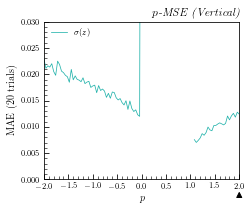

In [810]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$p$')
plt.ylim(0, 0.03)
plt.xlim(-2, 2)
plt.legend(frameon = False)
plt.gca().annotate(' ', (2.0, -0.0025), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"\it $p$-MSE (Vertical)",loc="right");
plt.savefig('plots/paper/mvn/pmse_vertical.pdf', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [449]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### MAEs

In [450]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([0.45]), array([0.018]))

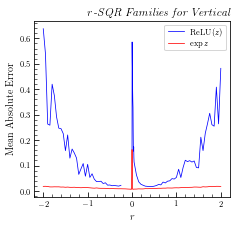

In [451]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $r$-SQR Families for Vertical",loc="right");
plt.savefig('plots/mvn/ab_sqr_vertical.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 1

#### MSE $A/B$ Parametrization

In [394]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### MAEs

In [395]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.16])

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_slant.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [452]:
# Experiment parameters
num = 1
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### MAEs

In [453]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([0.35]), array([0.018]))

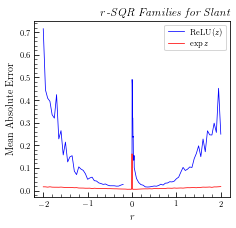

In [454]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $r$-SQR Families for Slant",loc="right");
plt.savefig('plots/mvn/ab_sqr_slant.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 2

#### MSE $A/B$ Parametrization

In [398]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### MAEs

In [399]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.28])

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/mvn/ab_mse_circle.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [455]:
# Experiment parameters
num = 2
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

##### MAEs

In [456]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([-0.3]), array([-0.1]))

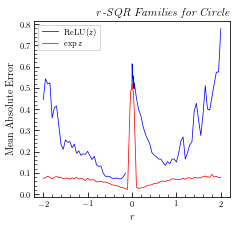

In [457]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $r$-SQR Families for Circle",loc="right");
plt.savefig('plots/mvn/ab_sqr_circle.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 3

#### MSE $A/B$ Parametrization

In [1324]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')
mr = make_mr(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [1299]:
# Get model likelihood ratios.
#avgs = []
mrs = np.zeros((len(ps), reps))
for i in range(len(ps)):
    p = ps[i]
    lrs = [None] * reps
    params = {'loss':get_mse(p), 'd': 2}
    for j in range(reps):
        model = create_model(**params)
        model.load_weights(mse_filestr.format(p, j))
        lrs[j] = pow_odds_lr(model, p, m, s)
    
    mrs[i] = [mr(lr) for lr in lrs]
    print(p, '\t', np.round(np.mean(mrs[i]), 4))

#avgs = np.array(avgs)

-2.0 	 1.0132
-1.96 	 1.0098
-1.92 	 1.01
-1.88 	 1.0094
-1.84 	 1.0048
-1.8 	 1.0111
-1.76 	 1.0125
-1.72 	 1.0086
-1.68 	 1.011
-1.64 	 1.0078
-1.6 	 1.0072
-1.56 	 1.0074
-1.52 	 1.005
-1.48 	 1.0067
-1.44 	 1.0117
-1.4 	 1.008
-1.36 	 1.0067
-1.32 	 1.0069
-1.28 	 1.0076
-1.24 	 1.0093
-1.2 	 1.007
-1.16 	 1.0098
-1.12 	 1.0064
-1.08 	 1.007
-1.04 	 1.0082
-1.0 	 1.0073
-0.96 	 1.0076
-0.92 	 1.0094
-0.88 	 1.0086
-0.84 	 1.0103
-0.8 	 1.0073
-0.76 	 1.0058
-0.72 	 1.0077
-0.68 	 1.005
-0.64 	 1.0053
-0.6 	 1.0076
-0.56 	 1.0058
-0.52 	 1.0028
-0.48 	 1.0074
-0.44 	 1.0096
-0.4 	 1.0067
-0.36 	 1.0072
-0.32 	 1.0051
-0.28 	 1.0068
-0.24 	 1.0042
-0.2 	 1.0052
-0.16 	 1.0064
-0.12 	 1.0067
-0.08 	 1.007
-0.04 	 1.0076
0.0 	 2.886


/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:223: RuntimeWarning: divide by zero encountered in divide
  return np.squeeze( (f / (1. - f))**(p - 1))
/clusterfs/ml4hep/shahzar/reweighting-schemes/utils/training.py:223: RuntimeWarning: divide by zero encountered in power
  return np.squeeze( (f / (1. - f))**(p - 1))


0.04 	 inf
0.08 	 inf
0.12 	 inf
0.16 	 inf
0.2 	 inf
0.24 	 inf
0.28 	 inf
0.32 	 inf
0.36 	 inf
0.4 	 inf
0.44 	 inf
0.48 	 inf
0.52 	 inf
0.56 	 inf
0.6 	 inf
0.64 	 inf
0.68 	 inf
0.72 	 inf
0.76 	 inf
0.8 	 inf
0.84 	 inf
0.88 	 inf
0.92 	 inf
0.96 	 inf
1.0 	 2.6574
1.04 	 inf
1.08 	 inf
1.12 	 inf
1.16 	 inf
1.2 	 inf
1.24 	 inf
1.28 	 inf
1.32 	 1.0396
1.36 	 1.0307
1.4 	 1.0275
1.44 	 1.0247
1.48 	 1.0227
1.52 	 1.0202
1.56 	 1.0183
1.6 	 1.0157
1.64 	 1.0196
1.68 	 1.0179
1.72 	 1.0148
1.76 	 1.015
1.8 	 1.0133
1.84 	 1.0143
1.88 	 1.0109
1.92 	 1.0115
1.96 	 1.013
2.0 	 1.0124


In [1300]:
# Save results
np.save(filestr + 'mrs.npy', mrs)
#np.save(filestr + 'avgs', avgs)

##### MRs

In [1327]:
avg_mrs = np.load(filestr + 'mrs.npy').mean(axis = 1)

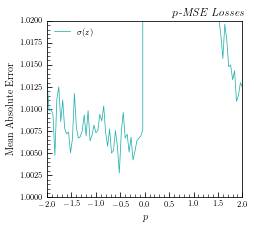

In [1330]:
plt.figure(figsize = (w, h))

plt.plot(ps, avg_mrs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
plt.ylim(1, 1.02)
plt.xlim(-2, 2)
plt.legend(frameon = False)
#plt.gca().annotate(' ', (2.0, -0.001), 
#                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
#                   annotation_clip = False)

plt.title(r"\it $p$-MSE Losses",loc="right");
plt.savefig('plots/paper/mvn/hyperbola_pmse_mr.pdf', 
            dpi=300, 
            bbox_inches='tight')

##### MAEs

In [417]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([-0.44])

In [418]:
min(avgs)

0.6428671690398577

In [419]:
ps[avgs <= 0.7]

array([-1.96, -1.92, -1.88, -1.84, -1.8 , -1.76, -1.72, -1.68, -1.64,
       -1.6 , -1.56, -1.48, -1.44, -1.4 , -1.36, -1.32, -1.28, -1.24,
       -1.2 , -1.16, -1.12, -1.08, -1.04, -1.  , -0.96, -0.92, -0.88,
       -0.84, -0.8 , -0.76, -0.72, -0.68, -0.64, -0.6 , -0.56, -0.52,
       -0.48, -0.44, -0.4 , -0.36, -0.32, -0.28, -0.24, -0.2 , -0.16,
       -0.12, -0.08, -0.04,  1.88,  1.92,  1.96,  2.  ])

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_hyperbola.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [1332]:
# Experiment parameters
num = 3
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')
mr = make_mr(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [1302]:
#lin_mrs = np.zeros((len(rs), reps))
exp_mrs = np.zeros((len(rs), reps))
#lin_avgs = []
#exp_avgs = []

for i in range(len(rs)):
    r = rs[i]
    #lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    #lin_params = {'loss': get_sqr(r), 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'output':'linear', 'd': 2}
    
    for j in range(reps):
        #lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        #lin_model.load_weights(lin_filestr.format(r, j))
        exp_model.load_weights(exp_filestr.format(r, j))
        
        #lin_lrs[j] = pow_lr(lin_model, r, m, s)
        exp_lrs[j] = pow_exp_lr(exp_model, r, m, s)
    
    #lin_maes = [mae(lr) for lr in lin_lrs]
    #exp_maes = [mae(lr) for lr in exp_lrs]
    #lin_mrs[i] = [mr(lr) for lr in lin_lrs]
    exp_mrs[i] = [mr(lr) for lr in exp_lrs]
    
    print(r, '\t', np.round(np.mean(lin_mrs[i]), 4), '\t', 
          np.round(np.mean(exp_mrs[i]), 4))
    
    #lin_avgs += [np.mean(lin_maes)]
    #exp_avgs += [np.mean(exp_maes)]
    #lin_avgs += [np.mean(lin_mrs)]
    #exp_avgs += [np.mean(exp_mrs)]

-2.0 	 1.2575 	 1.01
-1.95 	 1.0946 	 1.0036
-1.9 	 1.119 	 1.0085
-1.85 	 1.0532 	 1.0083
-1.8 	 1.05 	 1.0071
-1.75 	 1.0549 	 1.006
-1.7 	 1.1051 	 1.0061
-1.65 	 1.0346 	 1.0085
-1.6 	 1.035 	 1.0053
-1.55 	 1.0248 	 1.0065
-1.5 	 1.0489 	 1.0068
-1.45 	 1.0272 	 1.0061
-1.4 	 1.0301 	 1.0057
-1.35 	 1.0124 	 1.0066
-1.3 	 1.0103 	 1.0062
-1.25 	 1.0072 	 1.005
-1.2 	 1.008 	 1.0086
-1.15 	 1.0138 	 1.0074
-1.1 	 1.0087 	 1.0037
-1.05 	 1.007 	 1.0077
-1.0 	 1.0106 	 1.0066
-0.95 	 1.0017 	 1.0046
-0.9 	 1.0018 	 1.0028
-0.85 	 1.0021 	 1.0024
-0.8 	 1.0032 	 1.0066
-0.75 	 1.0012 	 1.0032
-0.7 	 1.0016 	 1.0049
-0.65 	 1.0013 	 1.0054
-0.6 	 1.0005 	 1.0034
-0.55 	 0.9989 	 1.0032
-0.5 	 0.9988 	 1.0038
-0.45 	 0.9998 	 1.0044
-0.4 	 1.0009 	 1.0014
-0.35 	 0.9989 	 1.0053
-0.3 	 1.0009 	 1.0042
-0.25 	 0.9993 	 1.0021
-0.2 	 0.9982 	 1.0036
-0.15 	 0.9975 	 1.0037
-0.1 	 inf 	 nan
-0.05 	 inf 	 1.1256
-0.046 	 inf 	 1.1246
-0.042 	 inf 	 1.1743
-0.038 	 inf 	 1.2913
-0.034 	 inf 

In [1303]:
# Save results
#np.save(filestr + 'lin_mrs.npy', lin_mrs)
np.save(filestr + 'exp_mrs.npy', exp_mrs)

#lin_avgs = np.array(lin_avgs)
#exp_avgs = np.array(exp_avgs)

#np.save(filestr + 'lin_avgs', lin_avgs)
#np.save(filestr + 'exp_avgs', exp_avgs)

##### MRs

In [1344]:
mrs = np.load(filestr + 'exp_mrs.npy')
avg_mrs = mrs.mean(axis = 1)

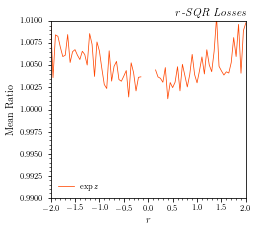

In [1346]:
plt.figure(figsize = (w, h))

plt.plot(rs, avg_mrs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
#plt.yticks(np.arange(0, 0.022, 0.002))
#plt.tick_params(which = 'minor', length = 3)
#plt.tick_params(which = 'major', length = 5)
#plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Ratio')
plt.xlabel(r'$r$')
plt.ylim(0.990, 1.01)
plt.xlim(-2, 2)
#plt.gca().annotate(' ', (1.0, -0.001), 
#                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
#                   annotation_clip = False)

plt.title(r"\it $r$-SQR Losses", loc="right");
plt.savefig('plots/paper/mvn/hyperbola_rsqr_mr.pdf', 
            dpi=300, 
            bbox_inches='tight')

##### MAEs

In [459]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([1.4]), array([-0.2]))

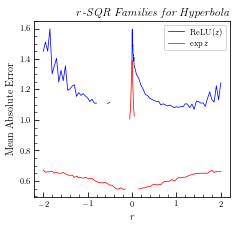

In [460]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $r$-SQR Families for Hyperbola",loc="right");
plt.savefig('plots/mvn/ab_sqr_hyperbola.png', 
            dpi=300, 
            bbox_inches='tight')

### Case 4

#### MSE $A/B$ Parametrization

In [412]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

##### MAEs

In [413]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == min(avgs)]

array([1.6])

In [ ]:
plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='blue', lw = 0.75)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$p$')
#plt.ylim(0, 0.16)

plt.title(r"\it $A/B$ Parametrization",loc="right");
plt.savefig('plots/paper/ab_mse_checker.png', 
            dpi=300, 
            bbox_inches='tight')

#### SQR $A/B$ Parametrization

In [461]:
# Experiment parameters
num = 4
reps = 20

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lin_avgs = []
exp_avgs = []

for r in rs:
    print(r, end = '\t')
    lin_lrs = [None] * reps
    exp_lrs = [None] * reps
    lin_params = {'loss': get_sqr(r), 'd': 2, 'output':'relu'}
    exp_params = {'loss': get_exp_sqr(r), 'd': 2, 'output':'linear'}
    
    for i in range(reps):
        lin_model = create_model(**lin_params)
        exp_model = create_model(**exp_params)
        
        lin_model.load_weights(lin_filestr.format(r, i))
        exp_model.load_weights(exp_filestr.format(r, i))
        
        lin_lrs[i] = pow_lr(lin_model, r, m, s)
        exp_lrs[i] = pow_exp_lr(exp_model, r, m, s)
    
    lin_maes = [mae(lr) for lr in lin_lrs]
    exp_maes = [mae(lr) for lr in exp_lrs]
    
    lin_avgs += [np.mean(lin_maes)]
    exp_avgs += [np.mean(exp_maes)]

In [ ]:
# Save results
lin_avgs = np.array(lin_avgs)
exp_avgs = np.array(exp_avgs)

np.save(filestr + 'lin_avgs', lin_avgs)
np.save(filestr + 'exp_avgs', exp_avgs)

##### MAEs

In [462]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([-0.65]), array([-0.1]))

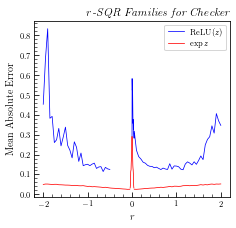

In [463]:
plt.figure(figsize = (w, h))

plt.plot(rs, lin_avgs, label=r'$\text{ReLU}(z)$', c='blue', lw = 0.75)
plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='red', lw = 0.75)
plt.legend()

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('Mean Absolute Error')
plt.xlabel(r'$r$')
#plt.ylim(0, 0.16)

plt.title(r"\it $r$-SQR Families for Checker",loc="right");
plt.savefig('plots/mvn/ab_sqr_checker.png', 
            dpi=300, 
            bbox_inches='tight')

## $p$-MSE and $r$-SQR Plots

In [328]:
rc('font', size=6)        #22
rc('xtick', labelsize=5)  #15
rc('ytick', labelsize=5)  #15
rc('legend', fontsize=5)  #15

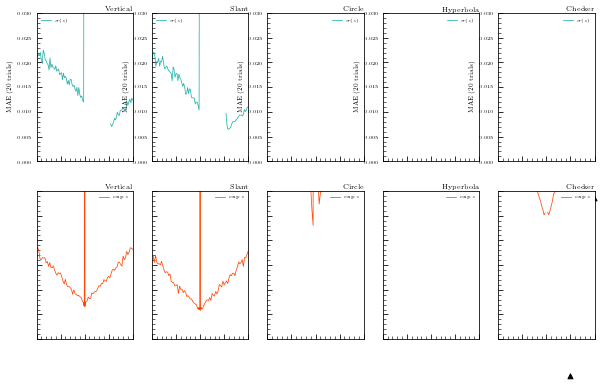

In [330]:
fig, axs = plt.subplots(2, 5, figsize = (10, 6))

ps = np.round(np.linspace(-2, 2, 101), 2)
rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

num = 0
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
avgs = np.load(filestr + 'avgs.npy')
axs[0, num].plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')
axs[0, num].minorticks_on()
axs[0, num].tick_params(which = 'minor', length = 3)
axs[0, num].tick_params(which = 'major', length = 5)
axs[0, num].tick_params(which = 'both', direction='in')
axs[0, num].set_xticklabels([])
axs[0, num].set_ylabel('MAE (20 trials)')
axs[0, num].set_ylim(0, 0.03)
axs[0, num].set_xlim(-2, 2)
axs[0, num].legend(frameon = False)
axs[0, num].set_title(r"Vertical",loc="right", pad = -0.1)

filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
exp_avgs = np.load(filestr + 'exp_avgs.npy')
axs[1, num].plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
axs[1, num].legend(frameon = False)
axs[1, num].minorticks_on()
axs[1, num].tick_params(which = 'minor', length = 3)
axs[1, num].tick_params(which = 'major', length = 5)
axs[1, num].tick_params(which = 'both', direction='in')
axs[1, num].set_yticklabels([])
axs[1, num].set_xticklabels([])
axs[1, num].set_ylim(0, 0.03)
axs[1, num].set_xlim(-2, 2)
axs[1, num].set_title(r"Vertical",loc="right", pad = -0.1)

num = 1
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
avgs = np.load(filestr + 'avgs.npy')
axs[0, num].plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')
axs[0, num].minorticks_on()
axs[0, num].tick_params(which = 'minor', length = 3)
axs[0, num].tick_params(which = 'major', length = 5)
axs[0, num].tick_params(which = 'both', direction='in')
axs[0, num].set_xticklabels([])
axs[0, num].set_ylabel('MAE (20 trials)')
axs[0, num].set_ylim(0, 0.03)
axs[0, num].set_xlim(-2, 2)
axs[0, num].legend(frameon = False)
axs[0, num].set_title(r"Slant",loc="right", pad = -0.1);

filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
exp_avgs = np.load(filestr + 'exp_avgs.npy')
axs[1, num].plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
axs[1, num].legend(frameon = False)
axs[1, num].minorticks_on()
axs[1, num].tick_params(which = 'minor', length = 3)
axs[1, num].tick_params(which = 'major', length = 5)
axs[1, num].tick_params(which = 'both', direction='in')
axs[1, num].set_yticklabels([])
axs[1, num].set_xticklabels([])
axs[1, num].set_ylim(0, 0.03)
axs[1, num].set_xlim(-2, 2)
axs[1, num].set_title(r"Slant", loc="right", pad = -0.1)

num = 2
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
avgs = np.load(filestr + 'avgs.npy')
axs[0, num].plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')
axs[0, num].minorticks_on()
axs[0, num].tick_params(which = 'minor', length = 3)
axs[0, num].tick_params(which = 'major', length = 5)
axs[0, num].tick_params(which = 'both', direction='in')
axs[0, num].set_xticklabels([])
axs[0, num].set_ylabel('MAE (20 trials)')
axs[0, num].set_ylim(0, 0.03)
axs[0, num].set_xlim(-2, 2)
axs[0, num].legend(frameon = False)
axs[0, num].set_title(r"Circle",loc="right", pad = -0.1)

filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
exp_avgs = np.load(filestr + 'exp_avgs.npy')
axs[1, num].plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
axs[1, num].legend(frameon = False)
axs[1, num].minorticks_on()
axs[1, num].tick_params(which = 'minor', length = 3)
axs[1, num].tick_params(which = 'major', length = 5)
axs[1, num].tick_params(which = 'both', direction='in')
axs[1, num].set_yticklabels([])
axs[1, num].set_xticklabels([])
axs[1, num].set_ylim(0, 0.03)
axs[1, num].set_xlim(-2, 2)
axs[1, num].set_title(r"Circle", loc="right", pad = -0.1)

num = 3
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
avgs = np.load(filestr + 'avgs.npy')
axs[0, num].plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')
axs[0, num].minorticks_on()
axs[0, num].tick_params(which = 'minor', length = 3)
axs[0, num].tick_params(which = 'major', length = 5)
axs[0, num].tick_params(which = 'both', direction='in')
axs[0, num].set_xticklabels([])
axs[0, num].set_ylabel('MAE (20 trials)')
axs[0, num].set_ylim(0, 0.03)
axs[0, num].set_xlim(-2, 2)
axs[0, num].legend(frameon = False)
axs[0, num].set_title(r"Hyperbola",loc="right", pad = -0.1)

filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
exp_avgs = np.load(filestr + 'exp_avgs.npy')
axs[1, num].plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
axs[1, num].legend(frameon = False)
axs[1, num].minorticks_on()
axs[1, num].tick_params(which = 'minor', length = 3)
axs[1, num].tick_params(which = 'major', length = 5)
axs[1, num].tick_params(which = 'both', direction='in')
axs[1, num].set_yticklabels([])
axs[1, num].set_xticklabels([])
axs[1, num].set_ylim(0, 0.03)
axs[1, num].set_xlim(-2, 2)
axs[1, num].set_title(r"Hyperbola", loc="right", pad = -0.1)

num = 4
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
avgs = np.load(filestr + 'avgs.npy')
axs[0, num].plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')
axs[0, num].minorticks_on()
axs[0, num].tick_params(which = 'minor', length = 3)
axs[0, num].tick_params(which = 'major', length = 5)
axs[0, num].tick_params(which = 'both', direction='in')
axs[0, num].set_xticklabels([])
axs[0, num].set_ylabel('MAE (20 trials)')
axs[0, num].set_ylim(0, 0.03)
axs[0, num].set_xlim(-2, 2)
axs[0, num].legend(frameon = False)
axs[0, num].set_title(r"Checker",loc="right", pad = -0.1);

filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
exp_avgs = np.load(filestr + 'exp_avgs.npy')
axs[1, num].plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
axs[1, num].legend(frameon = False)
axs[1, num].minorticks_on()
axs[1, num].tick_params(which = 'minor', length = 3)
axs[1, num].tick_params(which = 'major', length = 5)
axs[1, num].tick_params(which = 'both', direction='in')
axs[1, num].set_yticklabels([])
axs[1, num].set_xticklabels([])
axs[1, num].set_ylim(0, 0.03)
axs[1, num].set_xlim(-2, 2)
axs[1, num].set_title(r"Checker", loc="right", pad = -0.1)


axs[0, num].annotate(' ', (2.0, -0.007), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)
axs[1, num].annotate(' ', (1.0, -0.007), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.savefig('plots/pres/mvn_pr.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

## $C$ Parametrization

In [514]:
w = 3.5
h = 2.9

g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

### Case 0

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_vertical_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_vertical_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_vertical_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_vertical_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

### Case 1

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_slant_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_slant_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_slant_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 1
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_slant_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

### Case 2

#### BCE $C$ Parametrization

In [304]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [305]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_circle_arctan.png')

ValueError: cannot reshape array of size 160801 into shape (4001,4001)

<Figure size 57.6x57.6 with 0 Axes>

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_circle_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_circle_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 2
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_circle_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### Circle Plot

For this one, we'll plot BCE and MLC

In [1203]:
num = 2

x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)
xx, yy = np.meshgrid(x, y)

pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

N = 400
g = np.meshgrid(np.linspace(-2, 2, N + 1), np.linspace(-2, 2, N + 1))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)

aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, N + 2), np.linspace(-2.005, 2.005, N + 2))

mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)

zz = np.zeros((N + 1)**2)
zz[sgnl.pdf(g) / bkgd.pdf(g) <= 1] = 1
zz[sgnl.pdf(g) / bkgd.pdf(g) > 1] = -1

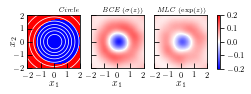

In [1204]:
fig, axs = plt.subplots(1, 3, figsize = (3.5, 1), 
                        sharex = True, sharey = True)
axs[0].pcolormesh(aa, bb, zz.reshape(N + 1, N + 1), cmap = 'bwr', zorder = -2, 
                  rasterized = True)
axs[0].contour(xx, yy, 0.5 * (bkgd.pdf(pos) + sgnl.pdf(pos)), colors='white', 
               linewidths = 0.75, zorder = -1)

axs[0].set_aspect('equal')
axs[0].set_yticks([-2, -1, 0, 1, 2])
axs[0].set_xticks([-2, -2, 0, 1, 2])
axs[0].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0].tick_params(direction='in', which='both',length=5)
axs[0].set_title(r'\it Circle', loc = 'right', fontsize = 7, pad = 3.5)
axs[0].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0].set_ylabel(r'$x_2$', labelpad = -3)

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
bce_preds = np.load(filestr + 'preds_1.npy')
dd = (bce_preds - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
bce_plot = axs[1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                             vmin = -0.2, vmax = 0.2, rasterized = True)
axs[1].set_aspect('equal')
axs[1].set_yticks([-2, -1, 0, 1, 2])
axs[1].set_xticks([-2, -2, 0, 1, 2])
axs[1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1].tick_params(direction='in', which='both',length=5)
axs[1].set_title(r'{\it BCE} ($\sigma(z)$)', loc = 'right', fontsize = 7,
                 pad = 3.5)
axs[1].set_xlabel(r'$x_1$', labelpad = -0.75)

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
mlc_preds = np.load(filestr + 'preds_3.npy')
dd = (mlc_preds - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
mlc_plot = axs[2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                             vmin = -0.2, vmax = 0.2, rasterized = True)
axs[2].set_aspect('equal')
axs[2].set_yticks([-2, -1, 0, 1, 2])
axs[2].set_xticks([-2, -1, 0, 1, 2])
axs[2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2].tick_params(direction='in', which='both',length=5)
axs[2].set_title(r'{\it MLC} ($\exp(z)$)', loc = 'right', fontsize = 7, 
                 pad = 3.5)
axs[2].set_xlabel(r'$x_1$', labelpad = -0.75)

fig.colorbar(mlc_plot, ax = axs.ravel(), fraction = 0.03, 
             ticks = np.arange(-0.2, 0.21, 0.1))

plt.savefig('plots/paper/mvn/circle.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

### Case 3

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_bce_hyperbola_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mse_hyperbola_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mse_hyperbola_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mse_hyperbola_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mlc_hyperbola_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 3
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_sqr_hyperbola_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_sqr_hyperbola_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_sqr_hyperbola_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### Hyperbola Plot

For this one, we'll plot MSE and SQR.

In [1201]:
num = 3

x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)
xx, yy = np.meshgrid(x, y)

pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

N = 400
g = np.meshgrid(np.linspace(-2, 2, N + 1), np.linspace(-2, 2, N + 1))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)

aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, N + 2), np.linspace(-2.005, 2.005, N + 2))

mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)

zz = np.zeros((N + 1)**2)
zz[sgnl.pdf(g) / bkgd.pdf(g) <= 1] = 1
zz[sgnl.pdf(g) / bkgd.pdf(g) > 1] = -1

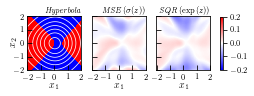

In [1202]:
fig, axs = plt.subplots(1, 3, figsize = (3.5, 1), 
                        sharex = True, sharey = True)
axs[0].pcolormesh(aa, bb, zz.reshape(N + 1, N + 1), cmap = 'bwr', zorder = -2, 
                  rasterized = True)
axs[0].contour(xx, yy, 0.5 * (bkgd.pdf(pos) + sgnl.pdf(pos)), colors='white', 
               linewidths = 0.75, zorder = -1)

axs[0].set_aspect('equal')
axs[0].set_yticks([-2, -1, 0, 1, 2])
axs[0].set_xticks([-2, -2, 0, 1, 2])
axs[0].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0].tick_params(direction='in', which='both',length=5)
axs[0].set_title(r'\it Hyperbola', loc = 'right', fontsize = 8, pad = 3.5)
axs[0].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0].set_ylabel(r'$x_2$', labelpad = -3)

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
mse_preds = np.load(filestr + 'preds_1.npy')
dd = (mse_preds - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
mse_plot = axs[1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                             vmin = -0.2, vmax = 0.2, rasterized = True)
axs[1].set_aspect('equal')
axs[1].set_yticks([-2, -1, 0, 1, 2])
axs[1].set_xticks([-2, -2, 0, 1, 2])
axs[1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1].tick_params(direction='in', which='both',length=5)
axs[1].set_title(r'{\it MSE} ($\sigma(z)$)', loc = 'right', fontsize = 8, 
                 pad = 3.5)
axs[1].set_xlabel(r'$x_1$', labelpad = -0.75)

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
sqr_preds = np.load(filestr + 'preds_3.npy')
dd = (sqr_preds - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
sqr_plot = axs[2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                             vmin = -0.2, vmax = 0.2, rasterized = True)
axs[2].set_aspect('equal')
axs[2].set_yticks([-2, -1, 0, 1, 2])
axs[2].set_xticks([-2, -1, 0, 1, 2])
axs[2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2].tick_params(direction='in', which='both',length=5)
axs[2].set_title(r'{\it SQR} ($\exp(z)$)', loc = 'right', fontsize = 8, 
                 pad = 3.5)
axs[2].set_xlabel(r'$x_1$', labelpad = -0.75)

fig.colorbar(mlc_plot, ax = axs.ravel(), fraction = 0.0135, 
             ticks = np.arange(-0.2, 0.21, 0.1))

plt.savefig('plots/paper/mvn/hyperbola.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

### Case 4

#### BCE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':2}
params_2 = {'loss':tanh_bce, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_bce_checker_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_bce_checker_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_bce_checker_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MSE $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':2}
params_2 = {'loss':tanh_mse, 'd':2, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = odds_lr(model_1, m, s)
    lrs_2[i] = tanh_lr(model_2, m, s)
    lrs_3[i] = arctan_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratio

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_sigmoid.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_tanh.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_mse_checker_arctan.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### MLC $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mlc_checker_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mlc_checker_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it Parametrizing $f$',
          filename = 'plots/paper/c_mlc_checker_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

#### SQR $C$ Parametrization

In [ ]:
# Experiment parameters
num = 4
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd':2, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd':2, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd':2,  'output': 'linear'}

filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

##### Process

In [ ]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = pure_lr(model_1, m, s)
    lrs_2[i] = square_lr(model_2, m, s)
    lrs_3[i] = exp_lr(model_3, m, s)
    
# Calculate predictions
g = np.meshgrid(np.linspace(-2, 2, 401), np.linspace(-2, 2, 401))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)
aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, 402), np.linspace(-2.005, 2.005, 402))

preds_1 = avg_lr(get_preds(lrs_1, xs = g))
preds_2 = avg_lr(get_preds(lrs_2, xs = g))
preds_3 = avg_lr(get_preds(lrs_3, xs = g))

# Calculate mean absolute errors
maes_1 = [mae(lr) for lr in lrs_1]
maes_2 = [mae(lr) for lr in lrs_2]
maes_3 = [mae(lr) for lr in lrs_3]

avg_1 = np.mean(maes_1)
avg_2 = np.mean(maes_2)
avg_3 = np.mean(maes_3)

std_1 = np.std(maes_1, ddof = 1)
std_2 = np.std(maes_2, ddof = 1)
std_3 = np.std(maes_3, ddof = 1)

# Save results
np.save(filestr + 'avg_1.npy', avg_1)
np.save(filestr + 'avg_2.npy', avg_2)
np.save(filestr + 'avg_3.npy', avg_3)

np.save(filestr + 'std_1.npy', std_1)
np.save(filestr + 'std_2.npy', std_2)
np.save(filestr + 'std_3.npy', std_3)

np.save(filestr + 'g.npy', g)
np.save(filestr + 'preds_1.npy', preds_1)
np.save(filestr + 'preds_2.npy', preds_2)
np.save(filestr + 'preds_3.npy', preds_3)

##### Likelihood Ratios

In [ ]:
g = np.load(filestr + 'g.npy')
preds_1 = np.load(filestr + 'preds_1.npy')
preds_2 = np.load(filestr + 'preds_2.npy')
preds_3 = np.load(filestr + 'preds_3.npy')

diff_plot(preds_1,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_relu.png')

diff_plot(preds_2,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_square.png')

diff_plot(preds_3,
          lr,
          g,
          aa, bb, 
          figsize = (w, h),
          title = r'\it $C$ Parametrization',
          filename = 'plots/paper/c_sqr_checker_exponential.png')

##### MAEs

In [ ]:
avg_1 = np.load(filestr + 'avg_1.npy')
avg_2 = np.load(filestr + 'avg_2.npy')
avg_3 = np.load(filestr + 'avg_3.npy')

std_1 = np.load(filestr + 'std_1.npy')
std_2 = np.load(filestr + 'std_2.npy')
std_3 = np.load(filestr + 'std_3.npy')

print(avg_1, avg_2, avg_3)
print(std_1, std_2, std_3)

## Diff Plots

In [331]:
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15

### Vertical

In [142]:
num = 0

x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)
xx, yy = np.meshgrid(x, y)

pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

N = 400
g = np.meshgrid(np.linspace(-2, 2, N + 1), np.linspace(-2, 2, N + 1))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)

aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, N + 2), np.linspace(-2.005, 2.005, N + 2))

mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)

zz = np.zeros((N + 1)**2)
zz[sgnl.pdf(g) / bkgd.pdf(g) <= 1] = 1
zz[sgnl.pdf(g) / bkgd.pdf(g) > 1] = -1

vmin = -0.1
vmax = 0.1
ticks = np.arange(-0.1, 0.11, 0.05)

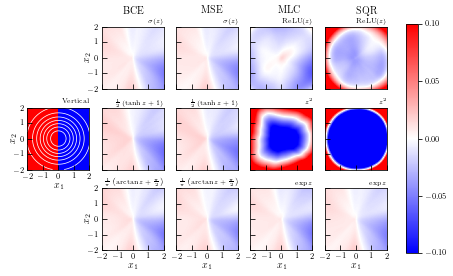

In [143]:
fig, axs = plt.subplots(3, 5, figsize = (7, 4.2))

axs[0, 0].axis('off')
axs[2, 0].axis('off')

axs[1, 0].pcolormesh(aa, bb, zz.reshape(N + 1, N + 1), cmap = 'bwr', 
                     zorder = -2, rasterized=True)
axs[1, 0].contour(xx, yy, 0.5 * (bkgd.pdf(pos) + sgnl.pdf(pos)), colors='white', 
                  linewidths = 0.75, zorder = -1)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_yticks([-2, -1, 0, 1, 2])
axs[1, 0].set_xticks([-2, -1, 0, 1, 2])
axs[1, 0].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 0].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 0].tick_params(direction='in', which='both',length=5)
axs[1, 0].set_title(r'Vertical', loc = 'right', fontsize = 7, pad = 3.5)
axs[1, 0].set_xlabel(r'$x_1$', labelpad = -0.075)
axs[1, 0].set_ylabel(r'$x_2$', labelpad = -3)
axs[1, 0].set_xlim(-2, 2)
axs[1, 0].set_ylim(-2, 2)

# BCE
filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax = vmax, rasterized=True)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_yticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 1].tick_params(direction='in', which='both',length=5)
axs[0, 1].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[0, 1].set_ylabel(r'$x_2$', labelpad = -3)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 1].set_xlim(-2, 2)
axs[0, 1].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_yticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticklabels([])
axs[1, 1].set_yticklabels([])
axs[1, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 1].tick_params(direction='in', which='both',length=5)
axs[1, 1].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 1].set_xlim(-2, 2)
axs[1, 1].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 1].set_aspect('equal')
axs[2, 1].set_yticks([-2, -1, 0, 1, 2])
axs[2, 1].set_xticks([-2, -1, 0, 1, 2])
#axs[2, 1].set_xticklabels([])
#axs[2, 1].set_yticklabels([])
axs[2, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 1].tick_params(direction='in', which='both',length=5)
axs[2, 1].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[2, 1].set_ylabel(r'$x_2$', labelpad = -3)
axs[2, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 1].set_xlim(-2, 2)
axs[2, 1].set_ylim(-2, 2)

# MSE
filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 2].set_aspect('equal')
axs[0, 2].set_yticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticklabels([])
axs[0, 2].set_yticklabels([])
axs[0, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 2].tick_params(direction='in', which='both',length=5)
axs[0, 2].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 2].set_xlim(-2, 2)
axs[0, 2].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 2].set_aspect('equal')
axs[1, 2].set_yticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticklabels([])
axs[1, 2].set_yticklabels([])
axs[1, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 2].tick_params(direction='in', which='both',length=5)
axs[1, 2].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 2].set_xlim(-2, 2)
axs[1, 2].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 2].set_aspect('equal')
axs[2, 2].set_yticks([-2, -1, 0, 1, 2])
axs[2, 2].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 2].set_yticklabels([])
axs[2, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 2].tick_params(direction='in', which='both',length=5)
axs[2, 2].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 2].set_xlim(-2, 2)
axs[2, 2].set_ylim(-2, 2)

# MLC
filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 3].set_aspect('equal')
axs[0, 3].set_yticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticklabels([])
axs[0, 3].set_yticklabels([])
axs[0, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 3].tick_params(direction='in', which='both',length=5)
axs[0, 3].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 3].set_xlim(-2, 2)
axs[0, 3].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 3].set_aspect('equal')
axs[1, 3].set_yticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticklabels([])
axs[1, 3].set_yticklabels([])
axs[1, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 3].tick_params(direction='in', which='both',length=5)
axs[1, 3].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 3].set_xlim(-2, 2)
axs[1, 3].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 3].set_aspect('equal')
axs[2, 3].set_yticks([-2, -1, 0, 1, 2])
axs[2, 3].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 3].set_yticklabels([])
axs[2, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 3].tick_params(direction='in', which='both',length=5)
axs[2, 3].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 3].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 3].set_xlim(-2, 2)
axs[2, 3].set_ylim(-2, 2)

# SQR
filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 4].set_aspect('equal')
axs[0, 4].set_yticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticklabels([])
axs[0, 4].set_yticklabels([])
axs[0, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 4].tick_params(direction='in', which='both',length=5)
axs[0, 4].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 4].set_xlim(-2, 2)
axs[0, 4].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 4].set_aspect('equal')
axs[1, 4].set_yticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticklabels([])
axs[1, 4].set_yticklabels([])
axs[1, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 4].tick_params(direction='in', which='both',length=5)
axs[1, 4].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 4].set_xlim(-2, 2)
axs[1, 4].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 4].set_aspect('equal')
axs[2, 4].set_yticks([-2, -1, 0, 1, 2])
axs[2, 4].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 4].set_yticklabels([])
axs[2, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 4].tick_params(direction='in', which='both',length=5)
axs[2, 4].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 4].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 4].set_xlim(-2, 2)
axs[2, 4].set_ylim(-2, 2)

fig.colorbar(plot_3, ax = axs.ravel(), fraction = 0.03, ticks = ticks)

plt.text(-15, 13.25, 'BCE')
plt.text(-10, 13.25, 'MSE')
plt.text(-5, 13.25, 'MLC')
plt.text(0, 13.25, 'SQR')
plt.savefig('plots/pres/vertical_all.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

### Slant

In [144]:
num = 1

x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)
xx, yy = np.meshgrid(x, y)

pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

N = 400
g = np.meshgrid(np.linspace(-2, 2, N + 1), np.linspace(-2, 2, N + 1))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)

aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, N + 2), np.linspace(-2.005, 2.005, N + 2))

b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)

zz = np.zeros((N + 1)**2)
zz[sgnl.pdf(g) / bkgd.pdf(g) <= 1] = 1
zz[sgnl.pdf(g) / bkgd.pdf(g) > 1] = -1

vmin = -0.1
vmax = 0.1
ticks = np.arange(-0.1, 0.11, 0.05)

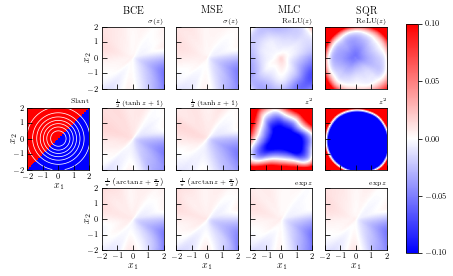

In [145]:
fig, axs = plt.subplots(3, 5, figsize = (7, 4.2))

axs[0, 0].axis('off')
axs[2, 0].axis('off')

axs[1, 0].pcolormesh(aa, bb, zz.reshape(N + 1, N + 1), cmap = 'bwr', 
                     zorder = -2, rasterized = True)
axs[1, 0].contour(xx, yy, 0.5 * (bkgd.pdf(pos) + sgnl.pdf(pos)), colors='white', 
                  linewidths = 0.75, zorder = -1)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_yticks([-2, -1, 0, 1, 2])
axs[1, 0].set_xticks([-2, -1, 0, 1, 2])
axs[1, 0].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 0].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 0].tick_params(direction='in', which='both',length=5)
axs[1, 0].set_title(r'Slant', loc = 'right', fontsize = 7, pad = 3.5)
axs[1, 0].set_xlabel(r'$x_1$', labelpad = -0.075)
axs[1, 0].set_ylabel(r'$x_2$', labelpad = -3)
axs[1, 0].set_xlim(-2, 2)
axs[1, 0].set_ylim(-2, 2)

# BCE
filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_yticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 1].tick_params(direction='in', which='both',length=5)
axs[0, 1].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[0, 1].set_ylabel(r'$x_2$', labelpad = -3)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 1].set_xlim(-2, 2)
axs[0, 1].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_yticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticklabels([])
axs[1, 1].set_yticklabels([])
axs[1, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 1].tick_params(direction='in', which='both',length=5)
axs[1, 1].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 1].set_xlim(-2, 2)
axs[1, 1].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 1].set_aspect('equal')
axs[2, 1].set_yticks([-2, -1, 0, 1, 2])
axs[2, 1].set_xticks([-2, -1, 0, 1, 2])
#axs[2, 1].set_xticklabels([])
#axs[2, 1].set_yticklabels([])
axs[2, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 1].tick_params(direction='in', which='both',length=5)
axs[2, 1].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[2, 1].set_ylabel(r'$x_2$', labelpad = -3)
axs[2, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 1].set_xlim(-2, 2)
axs[2, 1].set_ylim(-2, 2)

# MSE
filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 2].set_aspect('equal')
axs[0, 2].set_yticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticklabels([])
axs[0, 2].set_yticklabels([])
axs[0, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 2].tick_params(direction='in', which='both',length=5)
axs[0, 2].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 2].set_xlim(-2, 2)
axs[0, 2].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 2].set_aspect('equal')
axs[1, 2].set_yticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticklabels([])
axs[1, 2].set_yticklabels([])
axs[1, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 2].tick_params(direction='in', which='both',length=5)
axs[1, 2].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 2].set_xlim(-2, 2)
axs[1, 2].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 2].set_aspect('equal')
axs[2, 2].set_yticks([-2, -1, 0, 1, 2])
axs[2, 2].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 2].set_yticklabels([])
axs[2, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 2].tick_params(direction='in', which='both',length=5)
axs[2, 2].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 2].set_xlim(-2, 2)
axs[2, 2].set_ylim(-2, 2)

# MLC
filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 3].set_aspect('equal')
axs[0, 3].set_yticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticklabels([])
axs[0, 3].set_yticklabels([])
axs[0, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 3].tick_params(direction='in', which='both',length=5)
axs[0, 3].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 3].set_xlim(-2, 2)
axs[0, 3].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 3].set_aspect('equal')
axs[1, 3].set_yticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticklabels([])
axs[1, 3].set_yticklabels([])
axs[1, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 3].tick_params(direction='in', which='both',length=5)
axs[1, 3].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 3].set_xlim(-2, 2)
axs[1, 3].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 3].set_aspect('equal')
axs[2, 3].set_yticks([-2, -1, 0, 1, 2])
axs[2, 3].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 3].set_yticklabels([])
axs[2, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 3].tick_params(direction='in', which='both',length=5)
axs[2, 3].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 3].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 3].set_xlim(-2, 2)
axs[2, 3].set_ylim(-2, 2)

# SQR
filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 4].set_aspect('equal')
axs[0, 4].set_yticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticklabels([])
axs[0, 4].set_yticklabels([])
axs[0, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 4].tick_params(direction='in', which='both',length=5)
axs[0, 4].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 4].set_xlim(-2, 2)
axs[0, 4].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 4].set_aspect('equal')
axs[1, 4].set_yticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticklabels([])
axs[1, 4].set_yticklabels([])
axs[1, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 4].tick_params(direction='in', which='both',length=5)
axs[1, 4].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 4].set_xlim(-2, 2)
axs[1, 4].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 4].set_aspect('equal')
axs[2, 4].set_yticks([-2, -1, 0, 1, 2])
axs[2, 4].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 4].set_yticklabels([])
axs[2, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 4].tick_params(direction='in', which='both',length=5)
axs[2, 4].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 4].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 4].set_xlim(-2, 2)
axs[2, 4].set_ylim(-2, 2)

fig.colorbar(plot_3, ax = axs.ravel(), fraction = 0.03, 
             ticks = ticks)

plt.text(-15, 13.25, 'BCE')
plt.text(-10, 13.25, 'MSE')
plt.text(-5, 13.25, 'MLC')
plt.text(0, 13.25, 'SQR')
plt.savefig('plots/pres/slant_all.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

### Circle

In [146]:
num = 2

x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)
xx, yy = np.meshgrid(x, y)

pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

N = 400
g = np.meshgrid(np.linspace(-2, 2, N + 1), np.linspace(-2, 2, N + 1))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)

aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, N + 2), np.linspace(-2.005, 2.005, N + 2))

mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)

zz = np.zeros((N + 1)**2)
zz[sgnl.pdf(g) / bkgd.pdf(g) <= 1] = 1
zz[sgnl.pdf(g) / bkgd.pdf(g) > 1] = -1

vmin = -0.2
vmax = 0.2
ticks = np.arange(-0.2, 0.21, 0.05)

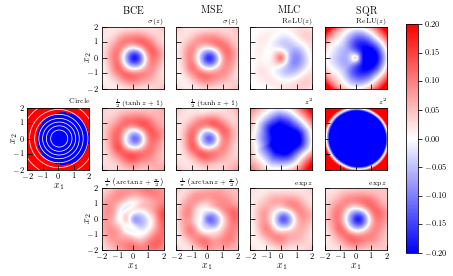

In [147]:
fig, axs = plt.subplots(3, 5, figsize = (7, 4.2))

axs[0, 0].axis('off')
axs[2, 0].axis('off')

axs[1, 0].pcolormesh(aa, bb, zz.reshape(N + 1, N + 1), cmap = 'bwr', 
                     zorder = -2, rasterized = True)
axs[1, 0].contour(xx, yy, 0.5 * (bkgd.pdf(pos) + sgnl.pdf(pos)), colors='white', 
                  linewidths = 0.75, zorder = -1)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_yticks([-2, -1, 0, 1, 2])
axs[1, 0].set_xticks([-2, -1, 0, 1, 2])
axs[1, 0].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 0].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 0].tick_params(direction='in', which='both',length=5)
axs[1, 0].set_title(r'Circle', loc = 'right', fontsize = 7, pad = 3.5)
axs[1, 0].set_xlabel(r'$x_1$', labelpad = -0.075)
axs[1, 0].set_ylabel(r'$x_2$', labelpad = -3)
axs[1, 0].set_xlim(-2, 2)
axs[1, 0].set_ylim(-2, 2)

# BCE
filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_yticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 1].tick_params(direction='in', which='both',length=5)
axs[0, 1].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[0, 1].set_ylabel(r'$x_2$', labelpad = -3)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 1].set_xlim(-2, 2)
axs[0, 1].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_yticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticklabels([])
axs[1, 1].set_yticklabels([])
axs[1, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 1].tick_params(direction='in', which='both',length=5)
axs[1, 1].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 1].set_xlim(-2, 2)
axs[1, 1].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 1].set_aspect('equal')
axs[2, 1].set_yticks([-2, -1, 0, 1, 2])
axs[2, 1].set_xticks([-2, -1, 0, 1, 2])
#axs[2, 1].set_xticklabels([])
#axs[2, 1].set_yticklabels([])
axs[2, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 1].tick_params(direction='in', which='both',length=5)
axs[2, 1].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[2, 1].set_ylabel(r'$x_2$', labelpad = -3)
axs[2, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 1].set_xlim(-2, 2)
axs[2, 1].set_ylim(-2, 2)

# MSE
filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 2].set_aspect('equal')
axs[0, 2].set_yticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticklabels([])
axs[0, 2].set_yticklabels([])
axs[0, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 2].tick_params(direction='in', which='both',length=5)
axs[0, 2].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 2].set_xlim(-2, 2)
axs[0, 2].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 2].set_aspect('equal')
axs[1, 2].set_yticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticklabels([])
axs[1, 2].set_yticklabels([])
axs[1, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 2].tick_params(direction='in', which='both',length=5)
axs[1, 2].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 2].set_xlim(-2, 2)
axs[1, 2].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 2].set_aspect('equal')
axs[2, 2].set_yticks([-2, -1, 0, 1, 2])
axs[2, 2].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 2].set_yticklabels([])
axs[2, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 2].tick_params(direction='in', which='both',length=5)
axs[2, 2].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 2].set_xlim(-2, 2)
axs[2, 2].set_ylim(-2, 2)

# MLC
filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 3].set_aspect('equal')
axs[0, 3].set_yticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticklabels([])
axs[0, 3].set_yticklabels([])
axs[0, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 3].tick_params(direction='in', which='both',length=5)
axs[0, 3].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 3].set_xlim(-2, 2)
axs[0, 3].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 3].set_aspect('equal')
axs[1, 3].set_yticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticklabels([])
axs[1, 3].set_yticklabels([])
axs[1, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 3].tick_params(direction='in', which='both',length=5)
axs[1, 3].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 3].set_xlim(-2, 2)
axs[1, 3].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 3].set_aspect('equal')
axs[2, 3].set_yticks([-2, -1, 0, 1, 2])
axs[2, 3].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 3].set_yticklabels([])
axs[2, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 3].tick_params(direction='in', which='both',length=5)
axs[2, 3].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 3].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 3].set_xlim(-2, 2)
axs[2, 3].set_ylim(-2, 2)

# SQR
filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 4].set_aspect('equal')
axs[0, 4].set_yticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticklabels([])
axs[0, 4].set_yticklabels([])
axs[0, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 4].tick_params(direction='in', which='both',length=5)
axs[0, 4].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 4].set_xlim(-2, 2)
axs[0, 4].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 4].set_aspect('equal')
axs[1, 4].set_yticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticklabels([])
axs[1, 4].set_yticklabels([])
axs[1, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 4].tick_params(direction='in', which='both',length=5)
axs[1, 4].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 4].set_xlim(-2, 2)
axs[1, 4].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 4].set_aspect('equal')
axs[2, 4].set_yticks([-2, -1, 0, 1, 2])
axs[2, 4].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 4].set_yticklabels([])
axs[2, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 4].tick_params(direction='in', which='both',length=5)
axs[2, 4].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 4].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 4].set_xlim(-2, 2)
axs[2, 4].set_ylim(-2, 2)

fig.colorbar(plot_3, ax = axs.ravel(), fraction = 0.03, 
             ticks = ticks)

plt.text(-15, 13.25, 'BCE')
plt.text(-10, 13.25, 'MSE')
plt.text(-5, 13.25, 'MLC')
plt.text(0, 13.25, 'SQR')
plt.savefig('plots/pres/circle_all.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

### Hyperbola

In [332]:
num = 3

x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)
xx, yy = np.meshgrid(x, y)

pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

N = 400
g = np.meshgrid(np.linspace(-2, 2, N + 1), np.linspace(-2, 2, N + 1))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)

aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, N + 2), np.linspace(-2.005, 2.005, N + 2))

mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)

zz = np.zeros((N + 1)**2)
zz[sgnl.pdf(g) / bkgd.pdf(g) <= 1] = 1
zz[sgnl.pdf(g) / bkgd.pdf(g) > 1] = -1

vmin = -0.2
vmax = 0.2
ticks = np.arange(-0.2, 0.21, 0.05)

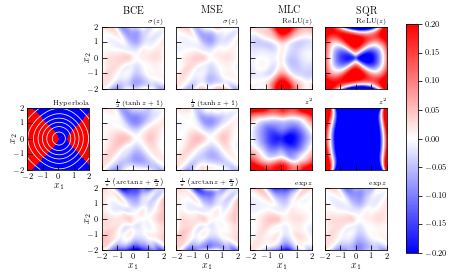

In [333]:
fig, axs = plt.subplots(3, 5, figsize = (7, 4.2))

axs[0, 0].axis('off')
axs[2, 0].axis('off')

axs[1, 0].pcolormesh(aa, bb, zz.reshape(N + 1, N + 1), cmap = 'bwr', 
                     zorder = -2, rasterized = True)
axs[1, 0].contour(xx, yy, 0.5 * (bkgd.pdf(pos) + sgnl.pdf(pos)), colors='white', 
                  linewidths = 0.75, zorder = -1)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_yticks([-2, -1, 0, 1, 2])
axs[1, 0].set_xticks([-2, -1, 0, 1, 2])
axs[1, 0].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 0].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 0].tick_params(direction='in', which='both',length=5)
axs[1, 0].set_title(r'Hyperbola', loc = 'right', fontsize = 7, pad = 3.5)
axs[1, 0].set_xlabel(r'$x_1$', labelpad = -0.075)
axs[1, 0].set_ylabel(r'$x_2$', labelpad = -3)
axs[1, 0].set_xlim(-2, 2)
axs[1, 0].set_ylim(-2, 2)

# BCE
filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_yticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 1].tick_params(direction='in', which='both',length=5)
axs[0, 1].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[0, 1].set_ylabel(r'$x_2$', labelpad = -3)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 1].set_xlim(-2, 2)
axs[0, 1].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_yticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticklabels([])
axs[1, 1].set_yticklabels([])
axs[1, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 1].tick_params(direction='in', which='both',length=5)
axs[1, 1].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 1].set_xlim(-2, 2)
axs[1, 1].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 1].set_aspect('equal')
axs[2, 1].set_yticks([-2, -1, 0, 1, 2])
axs[2, 1].set_xticks([-2, -1, 0, 1, 2])
#axs[2, 1].set_xticklabels([])
#axs[2, 1].set_yticklabels([])
axs[2, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 1].tick_params(direction='in', which='both',length=5)
axs[2, 1].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[2, 1].set_ylabel(r'$x_2$', labelpad = -3)
axs[2, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 1].set_xlim(-2, 2)
axs[2, 1].set_ylim(-2, 2)

# MSE
filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 2].set_aspect('equal')
axs[0, 2].set_yticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticklabels([])
axs[0, 2].set_yticklabels([])
axs[0, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 2].tick_params(direction='in', which='both',length=5)
axs[0, 2].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 2].set_xlim(-2, 2)
axs[0, 2].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 2].set_aspect('equal')
axs[1, 2].set_yticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticklabels([])
axs[1, 2].set_yticklabels([])
axs[1, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 2].tick_params(direction='in', which='both',length=5)
axs[1, 2].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 2].set_xlim(-2, 2)
axs[1, 2].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 2].set_aspect('equal')
axs[2, 2].set_yticks([-2, -1, 0, 1, 2])
axs[2, 2].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 2].set_yticklabels([])
axs[2, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 2].tick_params(direction='in', which='both',length=5)
axs[2, 2].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 2].set_xlim(-2, 2)
axs[2, 2].set_ylim(-2, 2)

# MLC
filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 3].set_aspect('equal')
axs[0, 3].set_yticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticklabels([])
axs[0, 3].set_yticklabels([])
axs[0, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 3].tick_params(direction='in', which='both',length=5)
axs[0, 3].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 3].set_xlim(-2, 2)
axs[0, 3].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 3].set_aspect('equal')
axs[1, 3].set_yticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticklabels([])
axs[1, 3].set_yticklabels([])
axs[1, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 3].tick_params(direction='in', which='both',length=5)
axs[1, 3].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 3].set_xlim(-2, 2)
axs[1, 3].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 3].set_aspect('equal')
axs[2, 3].set_yticks([-2, -1, 0, 1, 2])
axs[2, 3].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 3].set_yticklabels([])
axs[2, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 3].tick_params(direction='in', which='both',length=5)
axs[2, 3].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 3].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 3].set_xlim(-2, 2)
axs[2, 3].set_ylim(-2, 2)

# SQR
filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 4].set_aspect('equal')
axs[0, 4].set_yticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticklabels([])
axs[0, 4].set_yticklabels([])
axs[0, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 4].tick_params(direction='in', which='both',length=5)
axs[0, 4].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 4].set_xlim(-2, 2)
axs[0, 4].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 4].set_aspect('equal')
axs[1, 4].set_yticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticklabels([])
axs[1, 4].set_yticklabels([])
axs[1, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 4].tick_params(direction='in', which='both',length=5)
axs[1, 4].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 4].set_xlim(-2, 2)
axs[1, 4].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 4].set_aspect('equal')
axs[2, 4].set_yticks([-2, -1, 0, 1, 2])
axs[2, 4].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 4].set_yticklabels([])
axs[2, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 4].tick_params(direction='in', which='both',length=5)
axs[2, 4].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 4].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 4].set_xlim(-2, 2)
axs[2, 4].set_ylim(-2, 2)

fig.colorbar(plot_3, ax = axs.ravel(), fraction = 0.03, 
             ticks = ticks)

plt.text(-15, 13.25, 'BCE')
plt.text(-10, 13.25, 'MSE')
plt.text(-5, 13.25, 'MLC')
plt.text(0, 13.25, 'SQR')
plt.savefig('plots/pres/hyperbola_all.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

### Checker

In [150]:
num = 4

x = np.linspace(-2, 2, 201)
y = np.linspace(-2, 2, 201)
xx, yy = np.meshgrid(x, y)

pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx; pos[:, :, 1] = yy

N = 400
g = np.meshgrid(np.linspace(-2, 2, N + 1), np.linspace(-2, 2, N + 1))
g = np.append(g[0].reshape(-1, 1), g[1].reshape(-1, 1), axis = 1)

aa, bb = np.meshgrid(np.linspace(-2.005, 2.005, N + 2), np.linspace(-2.005, 2.005, N + 2))

mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)

zz = np.zeros((N + 1)**2)
zz[sgnl.pdf(g) / bkgd.pdf(g) <= 1] = 1
zz[sgnl.pdf(g) / bkgd.pdf(g) > 1] = -1

vmin = -0.2
vmax = 0.2
ticks = np.arange(-0.2, 0.21, 0.05)

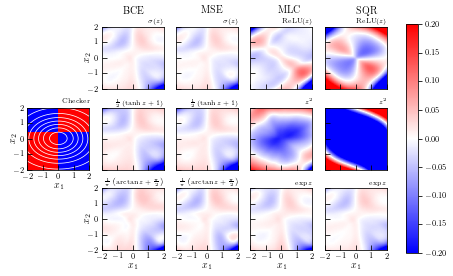

In [151]:
fig, axs = plt.subplots(3, 5, figsize = (7, 4.2))

axs[0, 0].axis('off')
axs[2, 0].axis('off')

axs[1, 0].pcolormesh(aa, bb, zz.reshape(N + 1, N + 1), cmap = 'bwr', 
                     zorder = -2, rasterized = True)
axs[1, 0].contour(xx, yy, 0.5 * (bkgd.pdf(pos) + sgnl.pdf(pos)), colors='white', 
                  linewidths = 0.75, zorder = -1)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_yticks([-2, -1, 0, 1, 2])
axs[1, 0].set_xticks([-2, -1, 0, 1, 2])
axs[1, 0].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 0].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 0].tick_params(direction='in', which='both',length=5)
axs[1, 0].set_title(r'Checker', loc = 'right', fontsize = 7, pad = 3.5)
axs[1, 0].set_xlabel(r'$x_1$', labelpad = -0.075)
axs[1, 0].set_ylabel(r'$x_2$', labelpad = -3)
axs[1, 0].set_xlim(-2, 2)
axs[1, 0].set_ylim(-2, 2)

# BCE
filestr = 'models/multivariate/c_bce/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_yticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticks([-2, -1, 0, 1, 2])
axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 1].tick_params(direction='in', which='both',length=5)
axs[0, 1].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[0, 1].set_ylabel(r'$x_2$', labelpad = -3)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 1].set_xlim(-2, 2)
axs[0, 1].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 1].set_aspect('equal')
axs[1, 1].set_yticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticks([-2, -1, 0, 1, 2])
axs[1, 1].set_xticklabels([])
axs[1, 1].set_yticklabels([])
axs[1, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 1].tick_params(direction='in', which='both',length=5)
axs[1, 1].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 1].set_xlim(-2, 2)
axs[1, 1].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 1].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 1].set_aspect('equal')
axs[2, 1].set_yticks([-2, -1, 0, 1, 2])
axs[2, 1].set_xticks([-2, -1, 0, 1, 2])
#axs[2, 1].set_xticklabels([])
#axs[2, 1].set_yticklabels([])
axs[2, 1].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 1].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 1].tick_params(direction='in', which='both',length=5)
axs[2, 1].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
axs[2, 1].set_ylabel(r'$x_2$', labelpad = -3)
axs[2, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 1].set_xlim(-2, 2)
axs[2, 1].set_ylim(-2, 2)

# MSE
filestr = 'models/multivariate/c_mse/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 2].set_aspect('equal')
axs[0, 2].set_yticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticks([-2, -1, 0, 1, 2])
axs[0, 2].set_xticklabels([])
axs[0, 2].set_yticklabels([])
axs[0, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 2].tick_params(direction='in', which='both',length=5)
axs[0, 2].set_title(r'$\sigma(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 2].set_xlim(-2, 2)
axs[0, 2].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 2].set_aspect('equal')
axs[1, 2].set_yticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticks([-2, -1, 0, 1, 2])
axs[1, 2].set_xticklabels([])
axs[1, 2].set_yticklabels([])
axs[1, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 2].tick_params(direction='in', which='both',length=5)
axs[1, 2].set_title(r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 2].set_xlim(-2, 2)
axs[1, 2].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 2].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 2].set_aspect('equal')
axs[2, 2].set_yticks([-2, -1, 0, 1, 2])
axs[2, 2].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 2].set_yticklabels([])
axs[2, 2].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 2].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 2].tick_params(direction='in', which='both',length=5)
axs[2, 2].set_title(r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 2].set_xlim(-2, 2)
axs[2, 2].set_ylim(-2, 2)

# MLC
filestr = 'models/multivariate/c_mlc/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 3].set_aspect('equal')
axs[0, 3].set_yticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticks([-2, -1, 0, 1, 2])
axs[0, 3].set_xticklabels([])
axs[0, 3].set_yticklabels([])
axs[0, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 3].tick_params(direction='in', which='both',length=5)
axs[0, 3].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 3].set_xlim(-2, 2)
axs[0, 3].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 3].set_aspect('equal')
axs[1, 3].set_yticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticks([-2, -1, 0, 1, 2])
axs[1, 3].set_xticklabels([])
axs[1, 3].set_yticklabels([])
axs[1, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 3].tick_params(direction='in', which='both',length=5)
axs[1, 3].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 3].set_xlim(-2, 2)
axs[1, 3].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 3].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 3].set_aspect('equal')
axs[2, 3].set_yticks([-2, -1, 0, 1, 2])
axs[2, 3].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 3].set_yticklabels([])
axs[2, 3].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 3].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 3].tick_params(direction='in', which='both',length=5)
axs[2, 3].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 3].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 3].set_xlim(-2, 2)
axs[2, 3].set_ylim(-2, 2)

# SQR
filestr = 'models/multivariate/c_sqr/set_{}/'.format(num)
preds_1 = np.load(filestr + 'preds_1.npy')
dd = (preds_1 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_1 = axs[0, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[0, 4].set_aspect('equal')
axs[0, 4].set_yticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticks([-2, -1, 0, 1, 2])
axs[0, 4].set_xticklabels([])
axs[0, 4].set_yticklabels([])
axs[0, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[0, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[0, 4].tick_params(direction='in', which='both',length=5)
axs[0, 4].set_title(r'${\rm ReLU}(z)$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 2].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 2].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[0, 4].set_xlim(-2, 2)
axs[0, 4].set_ylim(-2, 2)

preds_2 = np.load(filestr + 'preds_2.npy')
dd = (preds_2 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_2 = axs[1, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[1, 4].set_aspect('equal')
axs[1, 4].set_yticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticks([-2, -1, 0, 1, 2])
axs[1, 4].set_xticklabels([])
axs[1, 4].set_yticklabels([])
axs[1, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[1, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[1, 4].tick_params(direction='in', which='both',length=5)
axs[1, 4].set_title(r'$z^2$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
#axs[0, 1].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[1, 4].set_xlim(-2, 2)
axs[1, 4].set_ylim(-2, 2)

preds_3 = np.load(filestr + 'preds_3.npy')
dd = (preds_3 - lr(g)).reshape(aa.shape[0] - 1, aa.shape[1] - 1)
plot_3 = axs[2, 4].pcolormesh(aa, bb, dd, cmap = 'bwr', shading = 'auto', 
                              vmin = vmin, vmax  = vmax, rasterized = True)
axs[2, 4].set_aspect('equal')
axs[2, 4].set_yticks([-2, -1, 0, 1, 2])
axs[2, 4].set_xticks([-2, -1, 0, 1, 2])
#axs[1, 2].set_xticklabels([])
axs[2, 4].set_yticklabels([])
axs[2, 4].tick_params(axis = 'y', which = 'minor', bottom = False)
axs[2, 4].tick_params(axis = 'x', which = 'minor', bottom = False)
axs[2, 4].tick_params(direction='in', which='both',length=5)
axs[2, 4].set_title(r'$\exp z$', loc = 'right', fontsize = 7,
                    pad = 3.5)
#axs[0, 1].set_ylabel(r'$x_2$', labelpad = -0.75)
axs[2, 4].set_xlabel(r'$x_1$', labelpad = -0.75)
axs[2, 4].set_xlim(-2, 2)
axs[2, 4].set_ylim(-2, 2)

fig.colorbar(plot_3, ax = axs.ravel(), fraction = 0.03, 
             ticks = ticks)

plt.text(-15, 13.25, 'BCE')
plt.text(-10, 13.25, 'MSE')
plt.text(-5, 13.25, 'MLC')
plt.text(0, 13.25, 'SQR')
plt.savefig('plots/pres/checker_all.pdf', 
            dpi = 300, 
            transparent = True, 
            bbox_inches = 'tight')

## $A/B$ Performance

### $p^*$-MSEs

#### Case 0

In [35]:
# Experiment parameters
num = 5
reps = 100

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

p_star = 1.12

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

In [36]:
lrs = [None] * reps
params = {'loss':get_mse(p_star), 'd': 2}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(mse_filestr.format(i))
    lrs[i] = pow_odds_lr(model, p_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.006889131971960222 7.5479025561336e-05


#### Case 1

In [37]:
# Experiment parameters
num = 6
reps = 100

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

p_star = 1.16

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

In [38]:
lrs = [None] * reps
params = {'loss':get_mse(p_star), 'd': 2}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(mse_filestr.format(i))
    lrs[i] = pow_odds_lr(model, p_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.006424083435087067 8.087391530791946e-05


#### Case 2

In [39]:
# Experiment parameters
num = 7
reps = 100

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

p_star = 1.28

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

In [40]:
lrs = [None] * reps
params = {'loss':get_mse(p_star), 'd': 2}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(mse_filestr.format(i))
    lrs[i] = pow_odds_lr(model, p_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.03731011102247396 0.0006005901124072979


#### Case 3

In [41]:
# Experiment parameters
num = 8
reps = 100

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

p_star = -0.44

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

In [42]:
lrs = [None] * reps
params = {'loss':get_mse(p_star), 'd': 2}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(mse_filestr.format(i))
    lrs[i] = pow_odds_lr(model, p_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.6530029655530012 0.0023799661192039083


#### Case 4

In [43]:
# Experiment parameters
num = 9
reps = 100

# File parameters
filestr = 'models/multivariate/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

p_star = 1.6

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

In [44]:
lrs = [None] * reps
params = {'loss':get_mse(p_star), 'd': 2}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(mse_filestr.format(i))
    lrs[i] = pow_odds_lr(model, p_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.037471694979648154 0.00026141092316380214


### $r^*$ SQRs

#### Case 0

In [63]:
# Experiment parameters
num = 5
reps = 100

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/vertical/X_trn.npy')[:N]
y = np.load('data/mvn/vertical/y_trn.npy')[:N]
data, m, s = split_data(X, y)

r_star = 0.018

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([+0.1, 0])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/vertical/')

In [64]:
lrs = [None] * reps
params = {'loss':get_exp_sqr(r_star), 'd': 2, 'output': 'linear'}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(sqr_filestr.format(i))
    lrs[i] = pow_exp_lr(model, r_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.006769197789499124 7.892142563912271e-05


#### Case 1

In [65]:
# Experiment parameters
num = 6
reps = 100

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/slant/X_trn.npy')[:N]
y = np.load('data/mvn/slant/y_trn.npy')[:N]
data, m, s = split_data(X, y)

r_star = 0.018

# True distribution information
b = 0.1 / (2 ** (0.5))
mu_bkgd = np.array([-b, b])
mu_sgnl = np.array([b, -b])
sg_bkgd = np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/slant/')

In [67]:
lrs = [None] * reps
params = {'loss':get_exp_sqr(r_star), 'd': 2, 'output': 'linear'}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(sqr_filestr.format(i))
    lrs[i] = pow_exp_lr(model, r_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.006092046160115877 7.24369548095655e-05


#### Case 2

In [68]:
# Experiment parameters
num = 7
reps = 100

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/circle/X_trn.npy')[:N]
y = np.load('data/mvn/circle/y_trn.npy')[:N]
data, m, s = split_data(X, y)

r_star = -0.1

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = 2*np.eye(2)
sg_sgnl = np.eye(2)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/circle/')

In [69]:
lrs = [None] * reps
params = {'loss':get_exp_sqr(r_star), 'd': 2, 'output': 'linear'}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(sqr_filestr.format(i))
    lrs[i] = pow_exp_lr(model, r_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.026989108900039502 0.002111285319528404


#### Case 3

In [70]:
# Experiment parameters
num = 8
reps = 100

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/hyperbola/X_trn.npy')[:N]
y = np.load('data/mvn/hyperbola/y_trn.npy')[:N]
data, m, s = split_data(X, y)

r_star = -0.2

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0], [0, 1]])
sg_sgnl = np.array([[1, 0], [0, 2]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/hyperbola/')

In [71]:
lrs = [None] * reps
params = {'loss':get_exp_sqr(r_star), 'd': 2, 'output': 'linear'}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(sqr_filestr.format(i))
    lrs[i] = pow_exp_lr(model, r_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.5481757815540538 0.0023509856658356794


#### Case 4

In [72]:
# Experiment parameters
num = 9
reps = 100

# File parameters
filestr = 'models/multivariate/ab_sqr/set_{}/'.format(num)
sqr_filestr = filestr + 'model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/mvn/checker/X_trn.npy')[:N]
y = np.load('data/mvn/checker/y_trn.npy')[:N]
data, m, s = split_data(X, y)

r_star = -0.1

# True distribution information
mu_bkgd = np.array([-0.1, 0])
mu_sgnl = np.array([0.1, 0])
sg_bkgd = np.array([[2, 0.25], [0.25, 1]])
sg_sgnl = np.array([[2, -0.25], [-0.25, 1]])

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/mvn/checker/')

In [73]:
lrs = [None] * reps
params = {'loss':get_exp_sqr(r_star), 'd': 2, 'output': 'linear'}

for i in range(reps):
    print(i, end = '\t')
    model = create_model(**params)
    model.load_weights(sqr_filestr.format(i))
    lrs[i] = pow_exp_lr(model, r_star, m, s)

# Calculate mean absolute errors
maes = np.array([mae(lr) for lr in lrs])

# Save results
np.save(filestr + 'maes.npy', maes)
print(np.mean(maes), np.std(maes, ddof = 1) / 10)

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	0.025382212821673123 0.00020466997527718777


## Bar Charts

In [75]:
pmse_avgs = np.zeros(5)
pmse_stds = np.zeros(5)
pmse_filestr = 'models/multivariate/ab_mse/set_{}/'
for i in range(5, 10):
    maes = np.load(pmse_filestr.format(i) + 'maes.npy')
    pmse_avgs[i - 5] = np.mean(maes)
    pmse_stds[i - 5] = np.std(maes, ddof = 1) / 10

In [77]:
rsqr_avgs = np.zeros(5)
rsqr_stds = np.zeros(5)
rsqr_filestr = 'models/multivariate/ab_sqr/set_{}/'
for i in range(5, 10):
    maes = np.load(rsqr_filestr.format(i) + 'maes.npy')
    rsqr_avgs[i - 5] = np.mean(maes)
    rsqr_stds[i - 5] = np.std(maes, ddof = 1) / 10

In [78]:
pmse_avgs

array([0.00688913, 0.00642408, 0.03731011, 0.65300297, 0.03747169])

In [79]:
rsqr_avgs

array([0.0067692 , 0.00609205, 0.02698911, 0.54817578, 0.02538221])

In [80]:
np.save('pmse_avgs.npy', pmse_avgs)
np.save('pmse_stds.npy', pmse_stds)
np.save('rsqr_avgs.npy', rsqr_avgs)
np.save('rsqr_stds.npy', rsqr_stds)

In [152]:
bce_avgs = np.zeros((5, 3))
bce_stds = np.zeros((5, 3))
bce_filestr = 'models/multivariate/c_bce/set_{}/'
for i in range(5):
    bce_avgs[i][0] = np.load(bce_filestr.format(i) + 'avg_1.npy')
    bce_avgs[i][1] = np.load(bce_filestr.format(i) + 'avg_2.npy')
    bce_avgs[i][2] = np.load(bce_filestr.format(i) + 'avg_3.npy')
    
    bce_stds[i][0] = np.load(bce_filestr.format(i) + 'std_1.npy') / 10
    bce_stds[i][1] = np.load(bce_filestr.format(i) + 'std_2.npy') / 10
    bce_stds[i][2] = np.load(bce_filestr.format(i) + 'std_3.npy') / 10
    
mse_avgs = np.zeros((5, 3))
mse_stds = np.zeros((5, 3))
mse_filestr = 'models/multivariate/c_mse/set_{}/'
for i in range(5):
    mse_avgs[i][0] = np.load(mse_filestr.format(i) + 'avg_1.npy')
    mse_avgs[i][1] = np.load(mse_filestr.format(i) + 'avg_2.npy')
    mse_avgs[i][2] = np.load(mse_filestr.format(i) + 'avg_3.npy')
    
    mse_stds[i][0] = np.load(mse_filestr.format(i) + 'std_1.npy') / 10
    mse_stds[i][1] = np.load(mse_filestr.format(i) + 'std_2.npy') / 10
    mse_stds[i][2] = np.load(mse_filestr.format(i) + 'std_3.npy') / 10
    
mlc_avgs = np.zeros((5, 3))
mlc_stds = np.zeros((5, 3))
mlc_filestr = 'models/multivariate/c_mlc/set_{}/'
for i in range(5):
    mlc_avgs[i][0] = np.load(mlc_filestr.format(i) + 'avg_1.npy')
    mlc_avgs[i][1] = np.load(mlc_filestr.format(i) + 'avg_2.npy')
    mlc_avgs[i][2] = np.load(mlc_filestr.format(i) + 'avg_3.npy')
    
    mlc_stds[i][0] = np.load(mlc_filestr.format(i) + 'std_1.npy') / 10
    mlc_stds[i][1] = np.load(mlc_filestr.format(i) + 'std_2.npy') / 10
    mlc_stds[i][2] = np.load(mlc_filestr.format(i) + 'std_3.npy') / 10
    
sqr_avgs = np.zeros((5, 3))
sqr_stds = np.zeros((5, 3))
sqr_filestr = 'models/multivariate/c_sqr/set_{}/'
for i in range(5):
    sqr_avgs[i][0] = np.load(sqr_filestr.format(i) + 'avg_1.npy')
    sqr_avgs[i][1] = np.load(sqr_filestr.format(i) + 'avg_2.npy')
    sqr_avgs[i][2] = np.load(sqr_filestr.format(i) + 'avg_3.npy')
    
    sqr_stds[i][0] = np.load(sqr_filestr.format(i) + 'std_1.npy') / 10
    sqr_stds[i][1] = np.load(sqr_filestr.format(i) + 'std_2.npy') / 10
    sqr_stds[i][2] = np.load(sqr_filestr.format(i) + 'std_3.npy') / 10

In [680]:
np.save('bce_avgs.npy', bce_avgs[:, 0])
np.save('bce_stds.npy', bce_stds[:, 0])

np.save('mse_avgs.npy', mse_avgs[:, 0])
np.save('mse_stds.npy', mse_stds[:, 0])

np.save('mlc_avgs.npy', mlc_avgs[:, 2])
np.save('mlc_stds.npy', mlc_stds[:, 2])

np.save('sqr_avgs.npy', sqr_avgs[:, 2])
np.save('sqr_stds.npy', sqr_stds[:, 2])

In [153]:
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15

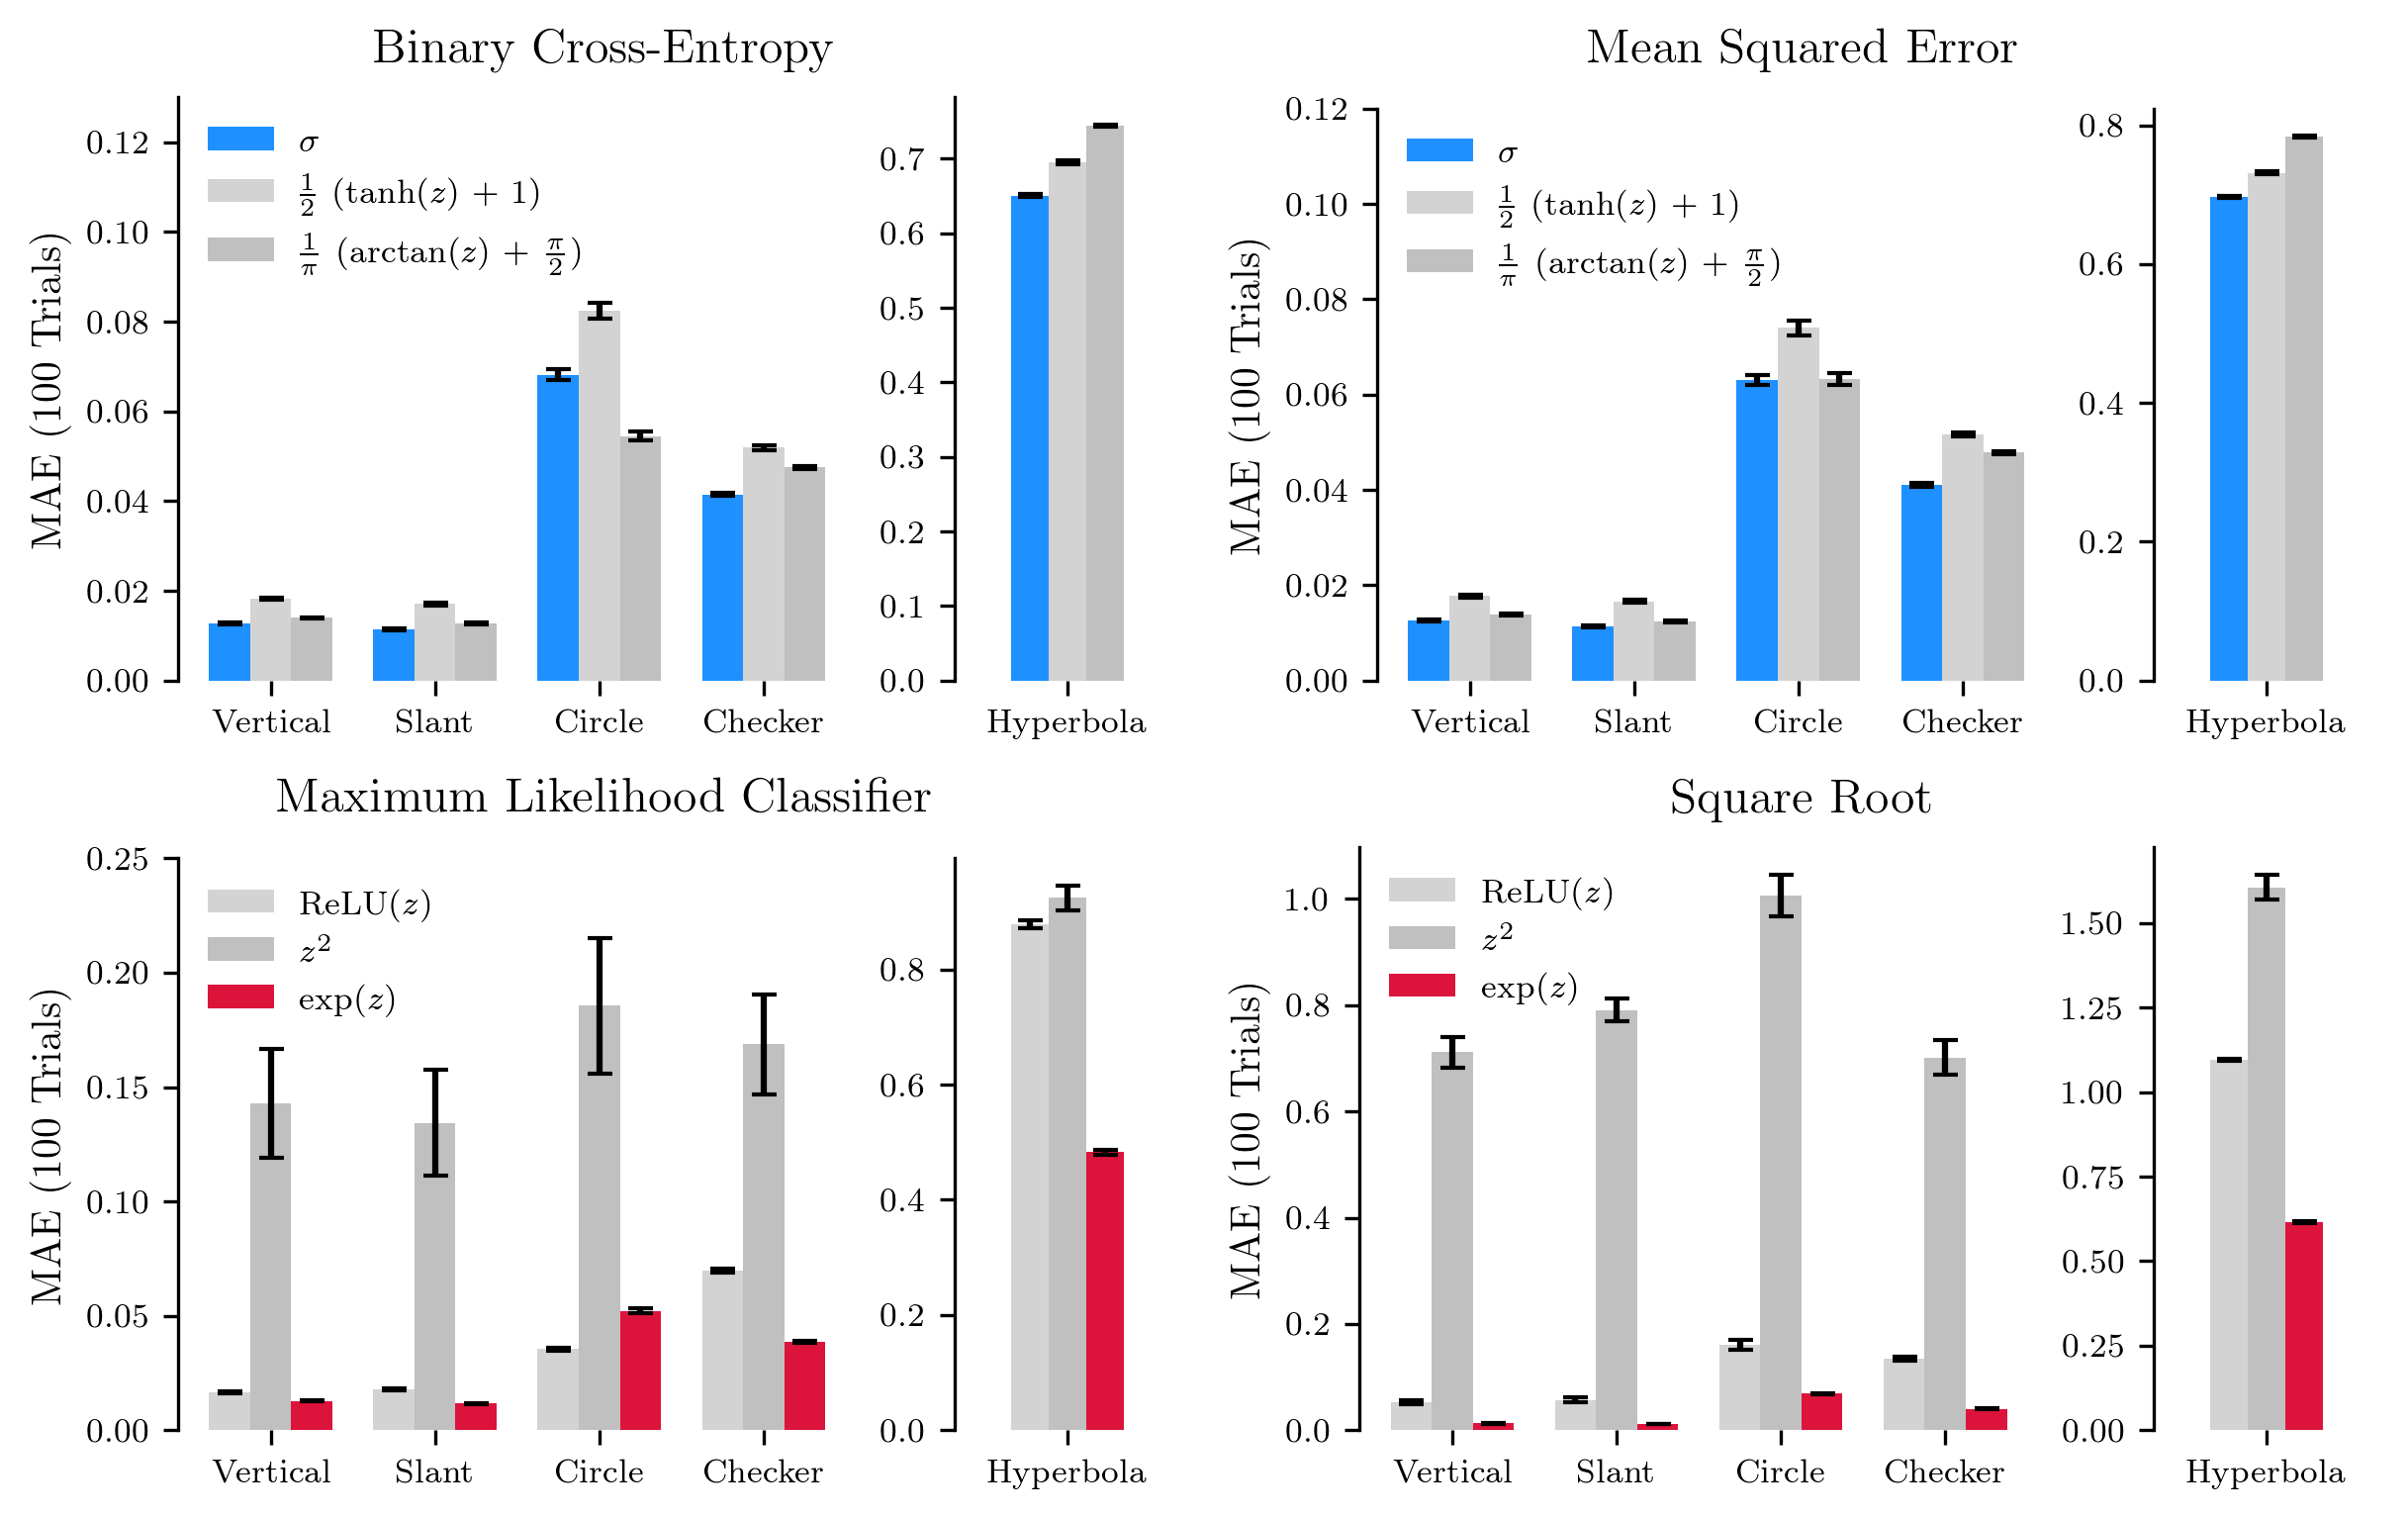

In [154]:
# Maybe should be 7, 5?
fig = plt.figure(figsize=(8, 5), dpi=300, constrained_layout=True)
subfigs = fig.subfigures(2, 2)

barWidth = 0.25

for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(nrows=1, ncols=2, gridspec_kw = {'width_ratios': [3,1]})
    
    if outerind == 0: 
        loss = bce_avgs.T
        errs = bce_stds.T
        color1 = 'dodgerblue'
        color2 = 'lightgrey'
        color3 = 'silver'
        title = "Binary Cross-Entropy"
        label1 = r'$\sigma$'
        label2 = r'$\frac{1}{2}$ (tanh($z$) + 1)'
        label3 = r'$\frac{1}{\pi}$ (arctan($z$) + $\frac{\pi}{2}$)'
        loc='best'
        
    elif outerind == 1: 
        loss = mse_avgs.T
        errs = mse_stds.T
        color1 = 'dodgerblue'
        color2 = 'lightgrey'
        color3 = 'silver'
        title = "Mean Squared Error"
        label1 = r'$\sigma$'
        label2 = r'$\frac{1}{2}$ (tanh($z$) + 1)'
        label3 = r'$\frac{1}{\pi}$ (arctan($z$) + $\frac{\pi}{2}$)'
        loc='best'
        
    elif outerind == 2:
        loss = mlc_avgs.T
        errs = mlc_stds.T
        color1 = 'lightgrey'
        color2 = 'silver'
        color3 = 'crimson'
        title = "Maximum Likelihood Classifier"
        label1 = r'ReLU($z$)'
        label2 = r'$z^2$'
        label3 = r'exp($z$)'
        loc='upper left'
        
    elif outerind == 3:
        loss = sqr_avgs.T
        errs = sqr_stds.T
        color1 = 'lightgrey'
        color2 = 'silver'
        color3 = 'crimson'
        title = "Square Root"
        label1 = r'ReLU($z$)'
        label2 = r'$z^2$'
        label3 = r'exp($z$)'
        loc='upper left'
        
    subfig.suptitle(title)

    act_0 = loss[0]
    act_1 = loss[1]
    act_2 = loss[2]
    
    err_0 = errs[0]
    err_1 = errs[1]
    err_2 = errs[2]
    
    for innerind, ax in enumerate(axs.flat):
        #ax.set_frame_on(False)
        if innerind == 0: 
            br1 = np.arange(4)
            br2 = [x + barWidth for x in br1]
            br3 = [x + barWidth for x in br2]
            act_0_4 = np.append(act_0[:3], act_0[-1])
            act_1_4 = np.append(act_1[:3], act_1[-1])
            act_2_4 = np.append(act_2[:3], act_2[-1])
            
            err_0_4 = np.append(err_0[:3], err_0[-1])
            err_1_4 = np.append(err_1[:3], err_1[-1])
            err_2_4 = np.append(err_2[:3], err_2[-1])
            ax.bar(br1, act_0_4, color = color1, width = barWidth, label =label1)
            ax.errorbar(br1, act_0_4, yerr=err_0_4, color='black', capsize=3, linestyle='none')        
            ax.bar(br2, act_1_4, color =color2, width = barWidth, label =label2)
            ax.errorbar(br2, act_1_4, yerr=err_1_4, color='black', capsize=3, linestyle='none')   
            ax.bar(br3, act_2_4, color =color3, width = barWidth, label = label3)
            ax.errorbar(br3, act_2_4, yerr=err_2_4, color='black', capsize=3, linestyle='none')  
            ax.set_xticks([r + barWidth for r in range(4)], ['Vertical', 'Slant', 'Circle', 'Checker'], rotation=0)    
            ax.legend(loc='upper left', frameon=False);
            ax.set_ylabel('MAE (100 Trials)')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            if outerind == 0:
                ax.set_ylim(0, 0.13)
            if outerind == 1:
                ax.set_ylim(0, 0.12)
            if outerind == 2:
                ax.set_ylim(0, 0.25)
        else: 
            br1 = np.arange(1)
            br2 = [x + barWidth for x in br1]
            br3 = [x + barWidth for x in br2]
            ax.bar(br1, act_0[3], color = color1, width = barWidth)
            ax.errorbar(br1, act_0[3], yerr=err_0[3], color='black', capsize=3, linestyle='none')      
            ax.bar(br2, act_1[3], color = color2, width = barWidth)
            ax.errorbar(br2, act_1[3], yerr=err_1[3], color='black', capsize=3, linestyle='none')   
            ax.bar(br3, act_2[3], color =color3, width = barWidth, )
            ax.errorbar(br3, act_2[3], yerr=err_2[3], color='black', capsize=3, linestyle='none')  
            ax.set_xticks([0+barWidth],['Hyperbola'], rotation=0)
            ax.set_xlim([-0.5,1])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            
plt.savefig('plots/pres/losses.pdf')

# Physics Data

## Variable Histograms

In [167]:
mc = np.load("data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt =  mc['sim_jets'][:, 0]
sim_y  = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m =   mc['sim_jets'][:, 3]

data = np.load("data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")
dat_pt =  data['sim_jets'][:, 0]
dat_y  = data['sim_jets'][:, 1]
dat_phi = data['sim_jets'][:, 2]
dat_m =   data['sim_jets'][:, 3]

In [5]:
X = np.load('data/zenodo/fold/X_trn.npy')
y = np.load('data/zenodo/fold/y_trn.npy')

sim_flow = X[y == 0]
dat_flow = X[y == 1]

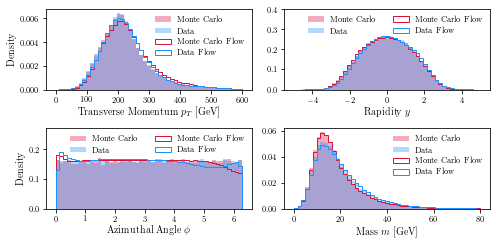

In [6]:
fig, axs = plt.subplots(2, 2, figsize = (7, 3.5))

bins = np.linspace(0, 600, 50)
axs[0, 0].hist(sim_pt, bins = bins, alpha = 0.35, color = 'crimson', 
               label = 'Monte Carlo', density = True)
axs[0, 0].hist(dat_pt, bins = bins, alpha = 0.35, color = 'dodgerblue', 
               label = 'Data', density = True)
axs[0, 0].hist(sim_flow[:, 0], bins = bins, color = 'crimson', 
               histtype = 'step', density = True, label = 'Monte Carlo Flow')
axs[0, 0].hist(dat_flow[:, 0], bins = bins, color = 'dodgerblue', 
               histtype = 'step', density = True, label = 'Data Flow')
axs[0, 0].set_ylabel('Density')
axs[0, 0].set_xlabel(r'Transverse Momentum $p_T$ [GeV]')
axs[0, 0].legend(frameon = False)

bins = np.linspace(-5, 5, 50)
axs[0, 1].hist(sim_y, bins = bins, alpha = 0.35, color = 'crimson', 
               density = True, label = 'Monte Carlo')
axs[0, 1].hist(dat_y, bins = bins, alpha = 0.35, color = 'dodgerblue', 
               density = True, label = 'Data')
axs[0, 1].hist(sim_flow[:, 1], bins = bins, color = 'crimson', 
               histtype = 'step', density = True, label = 'Monte Carlo Flow')
axs[0, 1].hist(dat_flow[:, 1], bins = bins, color = 'dodgerblue', 
               histtype = 'step', density = True, label = 'Data Flow')
#axs[0, 1].set_ylabel('Events')
axs[0, 1].set_ylim(0, 0.4)
axs[0, 1].set_xlabel(r'Rapidity $y$')
axs[0, 1].legend(ncol = 2, frameon = False)

bins = np.linspace(0, 2*np.pi, 50)
axs[1, 0].hist(sim_phi, bins = bins, alpha = 0.35, color = 'crimson', 
               density = True, label = 'Monte Carlo')
axs[1, 0].hist(dat_phi, bins = bins, alpha = 0.35, color = 'dodgerblue', 
               density = True, label = 'Data')
axs[1, 0].hist(sim_flow[:, 2], bins = bins, color = 'crimson', 
               histtype = 'step', density = True, label = 'Monte Carlo Flow')
axs[1, 0].hist(dat_flow[:, 2], bins = bins, color = 'dodgerblue', 
               histtype = 'step', density = True, label = 'Data Flow')
axs[1, 0].set_ylim(0, 0.27)
axs[1, 0].set_ylabel('Density')
axs[1, 0].set_xlabel(r'Azimuthal Angle $\phi$')
axs[1, 0].legend(ncol = 2, frameon = False)

bins = np.linspace(0, 80, 50)
axs[1, 1].hist(sim_m, bins = bins, alpha = 0.35, color = 'crimson', 
               density = True, label = 'Monte Carlo')
axs[1, 1].hist(dat_m, bins = bins, alpha = 0.35, color = 'dodgerblue', 
               density = True, label = 'Data')
axs[1, 1].hist(sim_flow[:, 3], bins = bins, color = 'crimson', 
               histtype = 'step', density = True, label = 'Monte Carlo Flow')
axs[1, 1].hist(dat_flow[:, 3], bins = bins, color = 'dodgerblue', 
               histtype = 'step', density = True, label = 'Data Flow')
#axs[1, 1].set_ylabel('Events')
axs[1, 1].set_xlabel(r'Mass $m$ [GeV]')
axs[1, 1].legend(frameon = False)

fig.tight_layout()

plt.savefig('plots/paper/physics/dists.pdf',
            bbox_inches = 'tight')

## Corner Plot

In [ ]:
pty = np.vstack([sim_pt, sim_y])
f = stats.gaussian_kde(pty)

In [ ]:
mu = pty.mean(axis = 1)
sg = pty.std(axis = 1)

In [ ]:
xx, yy = np.meshgrid(np.linspace(0, 600, 50), np.linspace(-5, 5, 50))
g = np.append(xx.reshape(-1, 1), yy.reshape(-1, 1), axis = 1)

In [ ]:
zz = f(g.T)

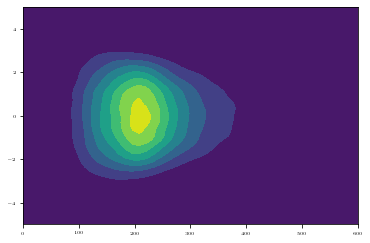

In [ ]:
plt.contourf(xx, yy, zz.reshape(50, 50))

In [200]:
levels = np.append(1.0 - np.exp(-0.5 * np.arange(0, 3.1, 1) ** 2), 1)

In [201]:
levels

array([0.        , 0.39346934, 0.86466472, 0.988891  , 1.        ])

(0.0, 600.0)

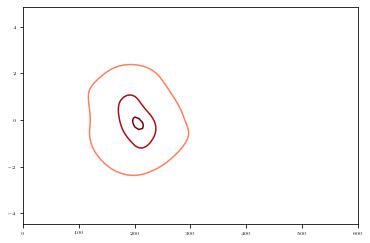

In [202]:
sns.kdeplot(x = sim_pt[::100], y = sim_y[::100], fill = False, cmap = 'Reds', levels = levels)
plt.xlim(0, 600)

In [215]:
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15

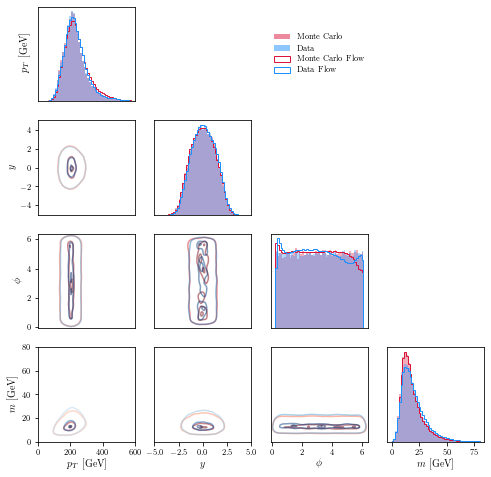

In [216]:
# Specify contours at 1 sigma, 2 sigma, 3 sigma
# Combine flows and corner into one?
# Possibly add ratios under the histograms and have both.

fig, axs = plt.subplots(4, 4, figsize = (8, 8))
levels = np.append(1.0 - np.exp(-0.5 * np.arange(0, 3.1, 1) ** 2), 1)

X = np.load('data/zenodo/fold/X_trn.npy')
y = np.load('data/zenodo/fold/y_trn.npy')
sim_flow = X[y == 0]
dat_flow = X[y == 1]

# pT, pT
bins = np.linspace(0, 600, 50)
axs[0, 0].hist(sim_pt, bins = bins, alpha = 0.35, color = 'crimson', density = True)
axs[0, 0].hist(dat_pt, bins = bins, alpha = 0.35, color = 'dodgerblue', density = True)
axs[0, 0].hist(sim_flow[:, 0], bins = bins, color = 'crimson', 
               histtype = 'step', density = True)
axs[0, 0].hist(dat_flow[:, 0], bins = bins, color = 'dodgerblue', 
               histtype = 'step', density = True)
axs[0, 0].set_ylabel(r'$p_T$ [GeV]')
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])
#axs[0, 0].set_ylim(0, 11500)

# pT, y
sns.kdeplot(x = sim_pt, y = sim_y, fill = False, cmap = 'Reds', 
            ax = axs[1, 0], levels = levels, alpha = 0.5)
sns.kdeplot(x = dat_pt, y = dat_y, fill = False, cmap = 'Blues', 
            ax = axs[1, 0], levels = levels, alpha = 0.5)
axs[1, 0].set_xlim(0, 600)
axs[1, 0].set_ylim(-5, 5)
axs[1, 0].set_ylabel(r'$y$')
axs[1, 0].set_xticks([])

# y, y
bins = np.linspace(-5, 5, 50)
axs[1, 1].hist(sim_y, bins = bins, alpha = 0.35, color = 'crimson', density = True)
axs[1, 1].hist(dat_y, bins = bins, alpha = 0.35, color = 'dodgerblue', density = True)
axs[1, 1].hist(sim_flow[:, 1], bins = bins, color = 'crimson', 
               histtype = 'step', density = True)
axs[1, 1].hist(dat_flow[:, 1], bins = bins, color = 'dodgerblue', 
               histtype = 'step', density = True)
axs[1, 1].set_yticks([])
axs[1, 1].set_xticks([])
#axs[1, 1].set_ylim(0, 8000)

# pT, phi
sns.kdeplot(x = sim_pt, y = sim_phi, fill = False, cmap = 'Reds', 
            ax = axs[2, 0], levels = levels, alpha = 0.5)
sns.kdeplot(x = dat_pt, y = dat_phi, fill = False, cmap = 'Blues', 
            ax = axs[2, 0], levels = levels, alpha = 0.5)
axs[2, 0].set_xlim(0, 600)
axs[2, 0].set_ylim(-0.1, 2*np.pi + 0.1)
axs[2, 0].set_ylabel(r'$\phi$')
axs[2, 0].set_xticks([])

# y, phi
sns.kdeplot(x = sim_y, y = sim_phi, fill = False, cmap = 'Reds', 
            ax = axs[2, 1], levels = levels, alpha = 0.5)
sns.kdeplot(x = dat_y, y = dat_phi, fill = False, cmap = 'Blues', 
            ax = axs[2, 1], levels = levels, alpha = 0.5)
axs[2, 1].set_xlim(-5, 5)
axs[2, 1].set_ylim(-0.1, 2*np.pi + 0.1)
axs[2, 1].set_yticks([])
axs[2, 1].set_xticks([])

# phi, phi
bins = np.linspace(0, 2*np.pi, 50)
axs[2, 2].hist(sim_phi, bins = bins, alpha = 0.35, color = 'crimson', density = True)
axs[2, 2].hist(dat_phi, bins = bins, alpha = 0.35, color = 'dodgerblue', density = True)
axs[2, 2].hist(sim_flow[:, 2], bins = bins, color = 'crimson', 
               histtype = 'step', density = True)
axs[2, 2].hist(dat_flow[:, 2], bins = bins, color = 'dodgerblue', 
               histtype = 'step', density = True)
#axs[2, 2].set_ylim(0, 3200)
axs[2, 2].set_yticks([])
axs[2, 2].set_xticks([])

# pT, m
sns.kdeplot(x = sim_pt, y = sim_m, fill = False, cmap = 'Reds', 
            ax = axs[3, 0], levels = levels, alpha = 0.5)
sns.kdeplot(x = dat_pt, y = dat_m, fill = False, cmap = 'Blues', 
            ax = axs[3, 0], levels = levels, alpha = 0.5)
axs[3, 0].set_xlim(0, 600)
axs[3, 0].set_ylim(0, 80)
axs[3, 0].set_ylabel(r'$m$ [GeV]')
axs[3, 0].set_xlabel(r'$p_T$ [GeV]')

# y, m
sns.kdeplot(x = sim_y, y = sim_m, fill = False, cmap = 'Reds', 
            ax = axs[3, 1], levels = levels, alpha = 0.5)
sns.kdeplot(x = dat_y, y = dat_m, fill = False, cmap = 'Blues', 
            ax = axs[3, 1], levels = levels, alpha = 0.5)
axs[3, 1].set_xlim(-5, 5)
axs[3, 1].set_ylim(0, 80)
axs[3, 1].set_xlabel(r'$y$')
axs[3, 1].set_yticks([])

# phi, m
sns.kdeplot(x = sim_phi, y = sim_m, fill = False, cmap = 'Reds', 
            ax = axs[3, 2], levels = levels, alpha = 0.5)
sns.kdeplot(x = dat_phi, y = dat_m, fill = False, cmap = 'Blues', 
            ax = axs[3, 2], levels = levels, alpha = 0.5)
axs[3, 2].set_xlim(0 - 0.1, 2*np.pi + 0.1)
axs[3, 2].set_ylim(0, 80)
axs[3, 2].set_xlabel(r'$\phi$')
axs[3, 2].set_yticks([])

# m, m
bins = np.linspace(0, 80, 50)
axs[3, 3].hist(sim_m, bins = bins, alpha = 0.35, color = 'crimson', density = True)
axs[3, 3].hist(dat_m, bins = bins, alpha = 0.35, color = 'dodgerblue', density = True)
axs[3, 3].hist(sim_flow[:, 3], bins = bins, color = 'crimson', 
               histtype = 'step', density = True)
axs[3, 3].hist(dat_flow[:, 3], bins = bins, color = 'dodgerblue', 
               histtype = 'step', density = True)
axs[3, 3].set_xlabel(r'$m$ [GeV]')
axs[3, 3].set_yticks([])
#axs[3, 3].set_ylim(0, 15000)

axs[0, 1].axis('off')
axs[0, 2].axis('off')
axs[0, 3].axis('off')
axs[1, 2].axis('off')
axs[1, 3].axis('off')
axs[2, 3].axis('off')

legend = [Patch(facecolor='crimson', edgecolor=None, alpha = 0.5, label='Monte Carlo'),
          Patch(facecolor='dodgerblue', edgecolor=None, alpha = 0.5, label = 'Data'),
          Patch(facecolor='w', edgecolor='crimson', label = 'Monte Carlo Flow'),
          Patch(facecolor='w', edgecolor='dodgerblue', label = 'Data Flow')]
axs[0, 2].legend(handles = legend, loc='center', frameon = False)

plt.savefig('plots/pres/pairs.pdf',
            bbox_inches = 'tight')

## Flow Validation

In [7]:
d = 4

dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/dat6/ckpt-235')
sim_ckpt.restore('flows/sim3/ckpt-235')

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

2023-04-18 07:13:59.479449: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 07:14:00.169475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19259 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:81:00.0, compute capability: 7.5


### Monte Carlo

In [611]:
mc = np.load("data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

mc_pt = mc['sim_jets'][:, 0]
mc_eta = mc['sim_jets'][:, 1]
mc_phi = mc['sim_jets'][:, 2]
mc_m = mc['sim_jets'][:, 3]

mc = np.vstack([mc_pt, mc_eta, mc_phi, mc_m]).T
n, d = mc.shape

In [612]:
mc_bkgd = mc
mc_sgnl = sim_target.sample(n)

In [613]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y_mc = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X_mc = np.zeros_like(mc_bkgd)

X_mc[y_mc == 0] = mc_bkgd[y_mc == 0]
X_mc[y_mc == 1] = mc_sgnl[y_mc == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_mc_trn = X_mc[trn_idx]
y_mc_trn = y_mc[trn_idx]

X_mc_tst = X_mc[tst_idx]
y_mc_tst = y_mc[tst_idx]

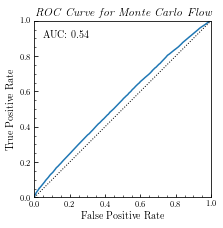

In [614]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for Monte Carlo Flow', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('plots/paper/physics/mc_roc.pdf', dpi = 300, transparent = True,
           bbox_inches = 'tight')

### Data

In [615]:
dat = np.load("data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m]).T
n, d = dat.shape

In [616]:
dt_bkgd = dat
dt_sgnl = dat_target.sample(n)

In [617]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y_dt = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X_dt = np.zeros_like(X_dt_bkgd)

X_dt[y_dt == 0] = dt_bkgd[y_dt == 0]
X_dt[y_dt == 1] = dt_sgnl[y_dt == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_dt_trn = X_dt[trn_idx]
y_dt_trn = y_dt[trn_idx]

X_dt_tst = X_dt[tst_idx]
y_dt_tst = y_dt[tst_idx]

In [597]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

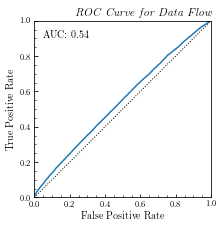

In [598]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for Data Flow', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('plots/paper/physics/dat_roc.pdf', dpi = 300, transparent = True,
           bbox_inches = 'tight')

### AUC Curves

In [618]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

mc_clf = AdaBoostClassifier()
dt_clf = AdaBoostClassifier()

mc_clf.fit(X_mc_trn, y_mc_trn)
dt_clf.fit(X_dt_trn, y_dt_trn)

AdaBoostClassifier()

In [619]:
y_mc_hat = mc_clf.predict_proba(X_mc_tst)[:, 1]
y_dt_hat = dt_clf.predict_proba(X_dt_tst)[:, 1]

mc_fpr, mc_tpr, mc_ts = metrics.roc_curve(y_mc_tst, y_mc_hat)
mc_auc = metrics.roc_auc_score(y_mc_tst, y_mc_hat)

dt_fpr, dt_tpr, dt_ts = metrics.roc_curve(y_dt_tst, y_dt_hat)
dt_auc = metrics.roc_auc_score(y_dt_tst, y_dt_hat)

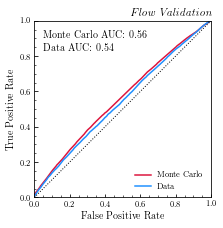

In [627]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(mc_fpr, mc_tpr, color = 'crimson', label = 'Monte Carlo')
plt.plot(dt_fpr, dt_tpr, color = 'dodgerblue', label = 'Data')
plt.plot(mc_fpr, mc_fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it Flow Validation', loc = 'right')
plt.text(0.05, 0.9, 'Monte Carlo AUC: {}'.format(round(mc_auc, 2)))
plt.text(0.05, 0.83, 'Data AUC: {}'.format(round(dt_auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.legend(frameon = False, loc = 'lower right')

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('plots/paper/physics/flow_roc.pdf', dpi = 300, transparent = True,
           bbox_inches = 'tight')

## Scans

In [25]:
X = np.load('data/zenodo/fold/X_trn.npy')
y = np.load('data/zenodo/fold/y_trn.npy')

In [26]:
median = np.median(X[y == 0], axis = 0)
median_pT = median[0]
median_eta = median[1]
median_phi = median[2]
median_m = median[3]

In [69]:
median_pT

221.76712

In [70]:
median_eta

-0.019819446

In [71]:
median_phi

3.0587218

In [72]:
median_m

15.951691

### $\phi$ Scan

In [27]:
# Get a one-dimensional slice of test points.
phis = np.linspace(0, 2*np.pi, 1201).reshape(-1, 1)
pTs = np.repeat(median_pT, len(phis)).reshape(-1, 1)
etas = np.repeat(median_eta, len(phis)).reshape(-1, 1)
ms = np.repeat(median_m, len(phis)).reshape(-1, 1)

xs = np.hstack([pTs, etas, phis, ms])
var = phis
var_label = r'$\phi$'
var_string = 'phi'

lr_true = lr(xs)

#### BCE

In [28]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':bce, 'd':4}
params_2 = {'loss':tanh_bce, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_bce, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_bce/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

##### Process

In [29]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [30]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

##### Plot

In [31]:
xs = np.load(filestr + 'scans/{}/xs.npy'.format(var_string))
preds_1 = np.load(filestr + 'scans/{}/preds_1.npy'.format(var_string))
preds_2 = np.load(filestr + 'scans/{}/preds_2.npy'.format(var_string))
preds_3 = np.load(filestr + 'scans/{}/preds_3.npy'.format(var_string))

In [32]:
cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 2)
title = r'{\it BCE Classifier Parametrizations} ($\phi$)'
filename = 'plots/paper/physics/bce_phi.pdf'

In [33]:
lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

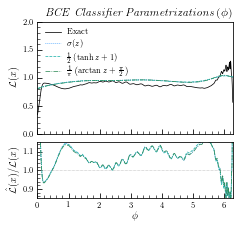

In [35]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i], 
                ls = lss[i],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i],
                ls = lss[i],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel(r'$\hat{\mathcal{L}}(x) / \mathcal{L}(x)$')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)
axs[0].legend(frameon = False)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

#### MSE

In [36]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mse, 'd':4}
params_2 = {'loss':tanh_mse, 'd':4, 'output': 'linear'}
params_3 = {'loss':arctan_mse, 'd':4,  'output': 'linear'}

filestr = 'models/zenodo/c_mse/set_{}/'.format(num)
filestr_1 = filestr + 'sigmoid/model_{}.h5'
filestr_2 = filestr + 'tanh/model_{}.h5'
filestr_3 = filestr + 'arctan/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = odds_lr
lr_calc_2 = tanh_lr
lr_calc_3 = arctan_lr

# Plotting
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 3)
title = r'\it MSE $\phi$ Scan'
filename = 'plots/zenodo/scans/mse_phi.png'

##### Process

In [37]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [38]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

##### Plot

In [39]:
xs = np.load(filestr + 'scans/{}/xs.npy'.format(var_string))
preds_1 = np.load(filestr + 'scans/{}/preds_1.npy'.format(var_string))
preds_2 = np.load(filestr + 'scans/{}/preds_2.npy'.format(var_string))
preds_3 = np.load(filestr + 'scans/{}/preds_3.npy'.format(var_string))

In [40]:
cs = ['dodgerblue', 'lightseagreen', 'seagreen']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)
w = 3.5
h = 3.25
labels = [r'$\sigma(z)$', r'$\frac{1}{2}\left(\tanh{z} + 1\right)$', r'$\frac{1}{\pi}\left(\arctan{z} + \frac{\pi}{2}\right)$']
y_lim = (0, 2)
title = r'{\it MSE Classifier Parametrizations} ($\phi$)'
filename = 'plots/paper/physics/mse_phi.pdf'

In [41]:
lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

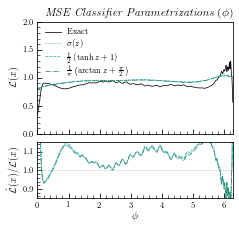

In [42]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i], 
                ls = lss[i],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i],
                ls = lss[i],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel(r'$\hat{\mathcal{L}}(x) / \mathcal{L}(x)$')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)
axs[0].legend(frameon = False)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

#### MLC

In [43]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':mlc, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_mlc, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_mlc, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_mlc/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

##### Process

In [44]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [45]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

##### Plot

In [46]:
xs = np.load(filestr + 'scans/{}/xs.npy'.format(var_string))
preds_1 = np.load(filestr + 'scans/{}/preds_1.npy'.format(var_string))
preds_2 = np.load(filestr + 'scans/{}/preds_2.npy'.format(var_string))
preds_3 = np.load(filestr + 'scans/{}/preds_3.npy'.format(var_string))

In [47]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 2)
title = r'{\it MLC Classifier Parametrizations} ($\phi$)'
filename = 'plots/paper/physics/mlc_phi.pdf'

In [48]:
lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

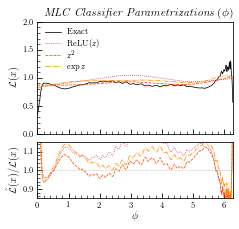

In [49]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i], 
                ls = lss[i],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i],
                ls = lss[i],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel(r'$\hat{\mathcal{L}}(x) / \mathcal{L}(x)$')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)
axs[0].legend(frameon = False)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

#### SQR

In [50]:
# Experiment parameters
num = 0
reps = 100

# Model parameters
params_1 = {'loss':sqr, 'd': 4, 'output': 'relu'}
params_2 = {'loss':square_sqr, 'd': 4, 'output': 'linear'}
params_3 = {'loss':exp_sqr, 'd': 4, 'output': 'linear'}

filestr = 'models/zenodo/c_sqr/set_{}/'.format(num)
filestr_1 = filestr + 'relu/model_{}.h5'
filestr_2 = filestr + 'square/model_{}.h5'
filestr_3 = filestr + 'exponential/model_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

lr_calc_1 = pure_lr
lr_calc_2 = square_lr
lr_calc_3 = exp_lr

##### Process

In [51]:
lrs_1 = [None] * reps
lrs_2 = [None] * reps
lrs_3 = [None] * reps

for i in range(reps):
    print(i, end = ' ')
    model_1 = create_model(**params_1)
    model_2 = create_model(**params_2)
    model_3 = create_model(**params_3)
    
    model_1.load_weights(filestr_1.format(i))
    model_2.load_weights(filestr_2.format(i))
    model_3.load_weights(filestr_3.format(i))
    
    lrs_1[i] = lr_calc_1(model_1, m, s)
    lrs_2[i] = lr_calc_2(model_2, m, s)
    lrs_3[i] = lr_calc_3(model_3, m, s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [52]:
# Calculate predictions
preds_1 = get_preds(lrs_1, xs)
preds_2 = get_preds(lrs_2, xs)
preds_3 = get_preds(lrs_3, xs)

# Save results
np.save(filestr + 'scans/{}/xs.npy'.format(var_string), xs)
np.save(filestr + 'scans/{}/preds_1.npy'.format(var_string), preds_1)
np.save(filestr + 'scans/{}/preds_2.npy'.format(var_string), preds_2)
np.save(filestr + 'scans/{}/preds_3.npy'.format(var_string), preds_3)

##### Plot

In [53]:
xs = np.load(filestr + 'scans/{}/xs.npy'.format(var_string))
preds_1 = np.load(filestr + 'scans/{}/preds_1.npy'.format(var_string))
preds_2 = np.load(filestr + 'scans/{}/preds_2.npy'.format(var_string))
preds_3 = np.load(filestr + 'scans/{}/preds_3.npy'.format(var_string))

In [54]:
cs = ['crimson', 'orangered', 'darkorange']
lss = [':', '--', '-.']
ensembles = [preds_1, preds_2, preds_3]
n = len(ensembles)
w = 3.5
h = 3.25
labels = [r'$\text{ReLU}(z)$', r'$z^2$', r'$\exp{z}$']
y_lim = (0, 2)
title = r'{\it SQR Classifier Parametrizations} ($\phi$)'
filename = 'plots/paper/physics/sqr_phi.pdf'

In [55]:
lrs = [None] * n
lrrs = [None] * n
for i in range(n):
    lrs[i] = avg_lr(ensembles[i])
    lrrs[i] = avg_lrr(lr, ensembles[i], xs)

lrs[1] = preds_2.mean(axis = 0, where = ~np.isnan(preds_2))

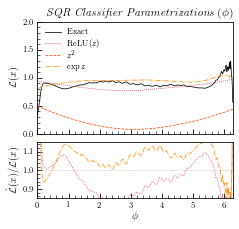

In [56]:
fig, axs = plt.subplots(2, 1,
                        figsize = (w, h),
                        sharex = True, 
                        gridspec_kw = {'height_ratios': [2, 1]})

if title:
    axs[0].set_title(title, loc = 'right')

# Plot likelihood ratios
axs[0].plot(var, lr_true, label = 'Exact', c = 'k', lw = 0.75)

for i in range(n):
    axs[0].plot(var, 
                lrs[i], 
                label = labels[i],
                c = cs[i], 
                ls = lss[i],
                lw = 0.75)

axs[0].set_xlim(var[0], var[-1])
if y_lim:
    axs[0].set_ylim(y_lim[0], y_lim[1])
axs[0].legend()
axs[0].minorticks_on()
axs[0].tick_params(which = 'minor', length = 3)
axs[0].tick_params(which = 'major', length = 5)
axs[0].tick_params(which = 'both', direction='in')
axs[0].set_ylabel('$\mathcal{L}(x)$')

# Plot likelihood ratio ratios
for i in range(n):
    axs[1].plot(var, 
                lrrs[i],
                c = cs[i],
                ls = lss[i],
                lw = 0.75)

axs[1].axhline(1,ls=":",color="grey", lw=0.5)
axs[1].axvline(0,ls=":",color="grey", lw=0.5)
axs[1].set_ylim(0.85, 1.15);
axs[1].minorticks_on()
axs[1].tick_params(which = 'minor', length = 3)
axs[1].tick_params(which = 'major', length = 5)
axs[1].tick_params(which = 'both', direction='in')
axs[1].set_ylabel(r'$\hat{\mathcal{L}}(x) / \mathcal{L}(x)$')

plt.subplots_adjust(hspace = 0.1)
plt.xlabel(var_label)
axs[0].legend(frameon = False)

if filename:
    plt.savefig(filename, 
                dpi = 300,
                transparent = True,
                bbox_inches = 'tight')

## Bar Chart

In [155]:
bce_avgs = np.zeros(3)
bce_stds = np.zeros(3)
bce_filestr = 'models/zenodo/c_bce/set_0/'
for i in range(3):
    bce_avgs[i] = np.load(bce_filestr + 'avg_{}.npy'.format(i + 1))
    bce_stds[i] = np.load(bce_filestr + 'std_{}.npy'.format(i + 1)) / 10
    
mse_avgs = np.zeros(3)
mse_stds = np.zeros(3)
mse_filestr = 'models/zenodo/c_mse/set_0/'
for i in range(3):
    mse_avgs[i] = np.load(mse_filestr + 'avg_{}.npy'.format(i + 1))
    mse_stds[i] = np.load(mse_filestr + 'std_{}.npy'.format(i + 1)) / 10
    
mlc_avgs = np.zeros(3)
mlc_stds = np.zeros(3)
mlc_filestr = 'models/zenodo/c_mlc/set_0/'
for i in range(3):
    mlc_avgs[i] = np.load(mlc_filestr + 'avg_{}.npy'.format(i + 1))
    mlc_stds[i] = np.load(mlc_filestr + 'std_{}.npy'.format(i + 1)) / 10
    
sqr_avgs = np.zeros(3)
sqr_stds = np.zeros(3)
sqr_filestr = 'models/zenodo/c_sqr/set_0/'
for i in range(3):
    sqr_avgs[i] = np.load(sqr_filestr + 'avg_{}.npy'.format(i + 1))
    sqr_stds[i] = np.load(sqr_filestr + 'std_{}.npy'.format(i + 1)) / 10

In [227]:
bce_avgs, mse_avgs, mlc_avgs, sqr_avgs

(array([0.14966658, 0.15346421, 0.15029684]),
 array([0.14965758, 0.15323049, 0.1507466 ]),
 array([0.18895239, 0.2480759 , 0.14602703]),
 array([0.26434031, 0.81761402, 0.14872888]))

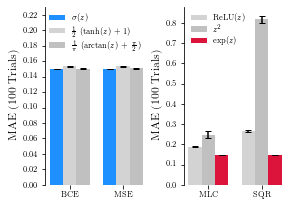

In [156]:
fig, axs = plt.subplots(1, 2, figsize = (4, 3))
fig.tight_layout()
width = 0.05

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].bar(0, bce_avgs[0], width = width, color = 'dodgerblue', label = r'$\sigma(z)$')
axs[0].errorbar(0, bce_avgs[0], yerr = bce_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + width, bce_avgs[1], width = width, color = 'lightgrey', label = r'$\frac{1}{2}$ (tanh($z$) + 1)')
axs[0].errorbar(0 + width, bce_avgs[1], yerr = bce_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 2*width, bce_avgs[2], width = width, color = 'silver', label = r'$\frac{1}{\pi}$ (arctan($z$) + $\frac{\pi}{2}$)')
axs[0].errorbar(0 + 2*width, bce_avgs[2], yerr = bce_stds[2], color = 'black', capsize=3, linestyle='none')

axs[0].bar(0 + 4*width, mse_avgs[0], width = width, color = 'dodgerblue')
axs[0].errorbar(0 + 4*width, mse_avgs[0], yerr = mse_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 5*width, mse_avgs[1], width = width, color = 'lightgrey')
axs[0].errorbar(0 + 5*width, mse_avgs[1], yerr = mse_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[0].bar(0 + 6*width, mse_avgs[2], width = width, color = 'silver')
axs[0].errorbar(0 + 6*width, mse_avgs[2], yerr = mse_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[0].set_ylim(0, 0.23)
axs[0].set_yticks(np.arange(0, 0.23, 0.02))
axs[0].legend(frameon=False, loc = 'best')
axs[0].set_xticks([width, 5*width], ['BCE', 'MSE'])
axs[0].set_ylabel('MAE (100 Trials)',  fontsize = 12)


axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].bar(0, mlc_avgs[0], width = width, color = 'lightgrey', label = r'ReLU($z$)')
axs[1].errorbar(0, mlc_avgs[0], yerr = mlc_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + width, mlc_avgs[1], width = width, color = 'silver', label = r'$z^2$')
axs[1].errorbar(0 + width, mlc_avgs[1], yerr = mlc_stds[1], color = 'black', capsize=3, linestyle='none')
axs[1].bar(0 + 2*width, mlc_avgs[2], width = width, color = 'crimson', label = r'$\exp(z)$')
axs[1].errorbar(0 + 2*width, mlc_avgs[2], yerr = mlc_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[1].legend(loc = 'upper left', frameon=False)

axs[1].bar(0 + 4*width, sqr_avgs[0], width = width, color = 'lightgrey')
axs[1].errorbar(0 + 4*width, sqr_avgs[0], yerr = sqr_stds[0], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + 5*width, sqr_avgs[1], width = width, color = 'silver')
axs[1].errorbar(0 + 5*width, sqr_avgs[1], yerr = sqr_stds[1], color = 'black', capsize=3, linestyle='none') 
axs[1].bar(0 + 6*width, sqr_avgs[2], width = width, color = 'crimson')
axs[1].errorbar(0 + 6*width, sqr_avgs[2], yerr = sqr_stds[2], color = 'black', capsize=3, linestyle='none') 
axs[1].legend(frameon=False, loc = 'upper left')
axs[1].set_xticks([width, 5*width], ['MLC', 'SQR'])
axs[1].set_ylabel('MAE (100 Trials)',  fontsize = 12)

plt.savefig('plots/pres/physics_losses.pdf', dpi = 300, bbox_inches = 'tight')

### Generalized Loss Families

#### MSE

In [217]:
rc('font', size=6)        #22
rc('xtick', labelsize=5)  #15
rc('ytick', labelsize=5)  #15
rc('legend', fontsize=5)  #15

In [218]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/zenodo/ab_mse/set_{}/'.format(num)
mse_filestr = filestr + 'model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

ps = np.round(np.linspace(-2, 2, 101), 2)

In [219]:
avgs = np.load(filestr + 'avgs.npy')
ps[avgs == np.min(avgs[~np.isnan(avgs)])]

array([-0.28])

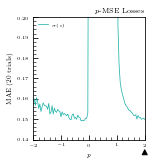

In [226]:
w = 2
h = 2.25              # Plots have dimension (w,h)

plt.figure(figsize = (w, h))

plt.plot(ps, avgs, c='lightseagreen', lw = 0.75, label = r'$\sigma(z)$')

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$p$')
plt.ylim(0.14, 0.2)
plt.xlim(-2, 2)

plt.legend(frameon = False)
plt.gca().annotate(' ', (2.0, 0.14 - 0.005), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"$p$-MSE Losses",loc="right");
plt.savefig('plots/pres/physics_pmse.pdf', 
            dpi=300, 
            bbox_inches='tight')

#### SQR

In [227]:
# Experiment parameters
num = 0
reps = 20

# File parameters
filestr = 'models/zenodo/ab_sqr/set_{}/'.format(num)
lin_filestr = filestr + 'relu/model_{}_{}.h5'
exp_filestr = filestr + 'exponential/model_{}_{}.h5'

# Data parameters
N = 10**6
X = np.load('data/zenodo/fold/X_trn.npy')[:N]
y = np.load('data/zenodo/fold/y_trn.npy')[:N].astype('float32')
data, m, s = split_data(X, y)

rs = np.sort(np.append(np.round(np.linspace(-2, 2, 81), 2),
                       np.round(np.linspace(-0.05, 0.05, 26), 3)[1:-1]))

In [228]:
lin_avgs = np.load(filestr + 'lin_avgs.npy')
exp_avgs = np.load(filestr + 'exp_avgs.npy')

rs[lin_avgs == min(lin_avgs)], rs[exp_avgs == min(exp_avgs)]

(array([0.3]), array([-1.3]))

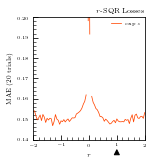

In [230]:
plt.figure(figsize = (w, h))

plt.plot(rs, exp_avgs, label=r'$\exp{z}$', c='orangered', lw = 0.75)
plt.legend(frameon = False)

plt.minorticks_on()
plt.tick_params(which = 'minor', length = 3)
plt.tick_params(which = 'major', length = 5)
plt.tick_params(which = 'both', direction='in')
plt.ylabel('MAE (20 trials)')
plt.xlabel(r'$r$')
plt.ylim(0.14, 0.2)
plt.xlim(-2, 2)
plt.gca().annotate(' ', (1.0, 0.14 - 0.005), 
                   arrowprops = dict(color = 'k', headlength = 5, headwidth = 5),
                   annotation_clip = False)

plt.title(r"$r$-SQR Losses", loc="right");
plt.savefig('plots/pres/physics_rsqr.pdf', 
            dpi=300, 
            bbox_inches='tight')

# Trees

## Vertical

### $d = 1$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

In [ ]:
N = 10**6
X = np.load('data/trees/X_trn.npy')[:N]
y = np.load('data/trees/y_trn.npy')[:N]
data, m, s = split_data(X, y)

# Load in models.
bce_lrs = [None] * reps
for i in range(reps):
    bce_model = create_model(**bce_params)
    bce_model.load_weights(bce_filestr.format(N, i))
    bce_lrs[i] = odds_lr(bce_model, m, s)

xs = np.linspace(-6, 6, 1201)

bce_preds = get_preds(bce_lrs, xs)

# BDT model
bdt = XGBClassifier(early_stopping_rounds = 10)
bdt.load_model(bdt_filestr.format(N, 0))
bdt_lr = xgb_lr(bdt, m, s)

bdt_preds = bdt_lr(xs)

In [ ]:
np.save(filestr + 'xs', xs)
np.save(filestr + 'bce_preds', bce_preds)
np.save(filestr + 'bdt_preds', bdt_preds)

#### Plot

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 2$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 2
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         y_lim = (0, 0.4),
         figsize = (w, h),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 4$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 4
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         y_lim = (0, 0.4),
         figsize = (w, h),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 8$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 8
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/trees/{}/X_trn.npy'.format(d))
y = np.load('data/trees/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 16$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 16
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         y_lim = (0, 0.4),
         figsize = (w, h),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

### $d = 32$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 32
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/trees/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
mu_bkgd = np.array([-0.1] + [0]*(d - 1))
mu_sgnl = np.array([+0.1] + [0]*(d - 1))
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/trees/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/trees/{}/X_trn.npy'.format(d))
y = np.load('data/trees/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avd', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plots

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/vertical_d{}.png'.format(d))

## Slant

### $d = 1$

In [292]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
bkgd = stats.norm(-0.1, 1)
sgnl = stats.norm(+0.1, 1)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [666]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
#bce_avg = np.array([])
#bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
#bdt_avg = np.array([])
#bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    #bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        #bce_model = create_model(**bce_params)
        #bce_model.load_weights(bce_filestr.format(N, i))
        #bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    #bce_maes = [mae(lr) for lr in bce_lrs]
    #bce_avg = np.append(bce_avg, np.mean(bce_maes))
    #bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    #np.save(filestr + 'bce_avg', bce_avg)
    #np.save(filestr + 'bce_std', bce_std)
    #print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    #bdt = XGBClassifier(early_stopping_rounds = 10)
    #bdt.load_model(bdt_filestr.format(N))
    #bdt_lr = tree_lr(bdt)
    
    #bdt_mae = mae(bdt_lr)
    #bdt_avg = np.append(bdt_avg, bdt_mae)
    #bdt_std = np.append(bdt_std, 0)
    #np.save(filestr + 'bdt_avg', bdt_avg)
    #np.save(filestr + 'bdt_std', bdt_std)
    #print(bdt_avg[-1])
    print()

#np.save(filestr + 'bce_avg', bce_avg)
#np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'gbc_std', gbc_std)

2	0.6875607735924837	
3	0.147596913657468	
4	0.06905638902498865	
5	0.035414118945041546	
6	0.014086419626469164	
7	0.007789888995857867	


In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [293]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
#bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
#bdt_std = np.load(filestr + 'bdt_std.npy')

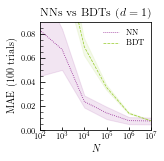

In [294]:
cs = ['purple', 'yellowgreen']
lss = [':', '--']
mae_plot([bce_avg, gbc_avg],
         ['NN', 'BDT'],
         Ns,
         stds = [bce_std, gbc_std],
         figsize = (2, 2),
         y_lim = (0, 0.09),
         cs = cs,
         lss = lss,
         title = r'NNs vs BDTs ($d = 1$)',
         filename = 'plots/pres/slant_d{}.pdf'.format(d))

### $d = 2$

In [295]:
# Experiment parameters
num = 0
reps = 100
d = 2
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [296]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
#bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
#bdt_std = np.load(filestr + 'bdt_std.npy')

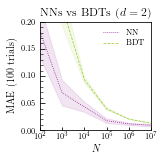

In [297]:
cs = ['purple', 'yellowgreen']
lss = [':', '--']
mae_plot([bce_avg, gbc_avg],
         ['NN', 'BDT'],
         Ns,
         stds = [bce_std, gbc_std],
         figsize = (2, 2),
         y_lim = (0, 0.20),
         cs = cs,
         lss = lss,
         title = r'NNs vs BDTs ($d = 2$)',
         filename = 'plots/pres/slant_d{}.pdf'.format(d))

### $d = 4$

In [298]:
# Experiment parameters
num = 0
reps = 100
d = 4
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [1230]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
#bdt_avg = np.array([])
#bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)

        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = np.array([mae(lr) for lr in bce_lrs])
    np.save(filestr + 'bce_maes_{}.npy'.format(int(np.log10(N))), bce_maes)
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    np.save(filestr + 'gbc_maes_{}.npy'.format(int(np.log10(N))), gbc_maes)
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1]) #, end = '\t')
    
    # BDT MAE
    #bdt = XGBClassifier(early_stopping_rounds = 10)
    #bdt.load_model(bdt_filestr.format(N))
    #bdt_lr = tree_lr(bdt)
    
    #bdt_mae = mae(bdt_lr)
    #bdt_avg = np.append(bdt_avg, bdt_mae)
    #bdt_std = np.append(bdt_std, 0)
    #np.save(filestr + 'bdt_avg', bdt_avg)
    #np.save(filestr + 'bdt_std', bdt_std)
    #print(bdt_avg[-1])

2	0.2341519809541107	0.5666365985477084
3	0.12385622099016301	0.20435053210152662
4	0.06998518025527466	0.1107744246348937
5	0.03553689789054735	0.05567105795878598
6	0.01841531566412685	0.030440363575401155
7	0.01613224595651952	0.021437143464012626


In [1231]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
#np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
#np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [299]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
#bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
#bdt_std = np.load(filestr + 'bdt_std.npy')

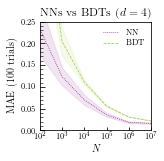

In [300]:
cs = ['purple', 'yellowgreen']
lss = [':', '--']
mae_plot([bce_avg, gbc_avg],
         ['NN', 'BDT'],
         Ns,
         stds = [bce_std, gbc_std],
         figsize = (2, 2),
         y_lim = (0, 0.25),
         cs = cs,
         lss = lss,
         title = r'NNs vs BDTs ($d = 4$)',
         filename = 'plots/pres/slant_d{}.pdf'.format(d))

### $d = 8$

In [301]:
# Experiment parameters
num = 0
reps = 100
d = 8
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [302]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
#bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
#bdt_std = np.load(filestr + 'bdt_std.npy')

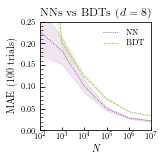

In [303]:
cs = ['purple', 'yellowgreen']
lss = [':', '--']
mae_plot([bce_avg, gbc_avg],
         ['NN', 'BDT'],
         Ns,
         stds = [bce_std, gbc_std],
         figsize = (2, 2),
         y_lim = (0, 0.25),
         cs = cs,
         lss = lss,
         title = r'NNs vs BDTs ($d = 8$)',
         filename = 'plots/pres/slant_d{}.pdf'.format(d))

### $d = 16$

In [304]:
# Experiment parameters
num = 0
reps = 100
d = 16
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [305]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
#bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
#bdt_std = np.load(filestr + 'bdt_std.npy')

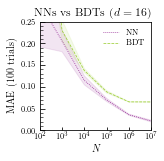

In [306]:
cs = ['purple', 'yellowgreen']
lss = [':', '--']
mae_plot([bce_avg, gbc_avg],
         ['NN', 'BDT'],
         Ns,
         stds = [bce_std, gbc_std],
         figsize = (2, 2),
         y_lim = (0, 0.25),
         cs = cs,
         lss = lss,
         title = r'NNs vs BDTs ($d = 16$)',
         filename = 'plots/pres/slant_d{}.pdf'.format(d))

### $d = 32$

In [307]:
# Experiment parameters
num = 0
reps = 100
d = 32
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/bdts/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
b = 0.1 / (d ** (0.5))
mu_bkgd = np.array([-b] * d)
mu_sgnl = np.array([+b] * d)
sg_bkgd = np.eye(d)
sg_sgnl = np.eye(d)

bkgd = stats.multivariate_normal(mu_bkgd, sg_bkgd)
sgnl = stats.multivariate_normal(mu_sgnl, sg_sgnl)

lr = make_lr(bkgd, sgnl)
mae = make_mae(bkgd, sgnl, 'data/bdts/{}/'.format(d))

#### Process

In [ ]:
X = np.load('data/bdts/{}/X_trn.npy'.format(d))
y = np.load('data/bdts/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)

        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
    
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')

    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [308]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
#bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
#bdt_std = np.load(filestr + 'bdt_std.npy')

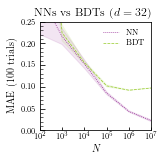

In [309]:
cs = ['purple', 'yellowgreen']
lss = [':', '--']
mae_plot([bce_avg, gbc_avg],
         ['NN', 'BDT'],
         Ns,
         stds = [bce_std, gbc_std],
         figsize = (2, 2),
         y_lim = (0, 0.25),
         cs = cs,
         lss = lss,
         title = r'NNs vs BDTs ($d = 32$)',
         filename = 'plots/pres/slant_d{}.pdf'.format(d))

## Zenodo

### $d = 1$

In [310]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat1/ckpt-157')
sim_ckpt.restore('flows/zenodo/sim1/ckpt-157')

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

2023-05-30 10:10:32.714185: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 10:10:33.181326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21130 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:c1:00.0, compute capability: 7.5


#### Process

In [ ]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [311]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
#bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
#bdt_std = np.load(filestr + 'bdt_std.npy')

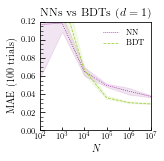

In [312]:
cs = ['purple', 'yellowgreen']
lss = [':', '--']
mae_plot([bce_avg, gbc_avg],
         ['NN', 'BDT'],
         Ns,
         stds = [bce_std, gbc_std],
         figsize = (2, 2),
         y_lim = (0, 0.12),
         cs = cs,
         lss = lss,
         title = r'NNs vs BDTs ($d = 1$)',
         filename = 'plots/pres/physics_d{}.pdf'.format(d))

### $d = 2$

In [313]:
# Experiment parameters
num = 0
reps = 100
d = 2
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat{}/ckpt-157'.format(d))
sim_ckpt.restore('flows/zenodo/sim{}/ckpt-157'.format(d))

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [ ]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [314]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
#bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
#bdt_std = np.load(filestr + 'bdt_std.npy')

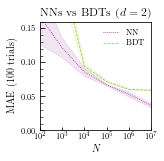

In [315]:
cs = ['purple', 'yellowgreen']
lss = [':', '--']
mae_plot([bce_avg, gbc_avg],
         ['NN', 'BDT'],
         Ns,
         stds = [bce_std, gbc_std],
         figsize = (2, 2),
         y_lim = (0, 0.16),
         cs = cs,
         lss = lss,
         title = r'NNs vs BDTs ($d = 2$)',
         filename = 'plots/pres/physics_d{}.pdf'.format(d))

### $d = 4$

In [319]:
# Experiment parameters
num = 0
reps = 100
d = 4
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat{}/ckpt-235'.format(d))
sim_ckpt.restore('flows/zenodo/sim{}/ckpt-235'.format(d))

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [250]:
bce_maes = np.zeros((len(Ns), reps))

In [325]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_maes = np.zeros((len(Ns), 100))
gbc_maes = np.zeros((len(Ns), 100))
#bce_avg = np.array([])
#bce_std = np.array([])
#gbc_avg = np.array([])
#gbc_std = np.array([])
for i in range(len(Ns)):
    N = Ns[i]
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for j in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, j))
        bce_lrs[j] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, j))
        gbc_lrs[j] = tree_lr(gbc_model)
        
    bce_maes[i] = [mae(lr) for lr in bce_lrs]
    gbc_maes[i] = [mae(lr) for lr in gbc_lrs]
    
    print(np.mean(bce_maes[i]), '\t', np.mean(gbc_maes[i]))

2	36992.92921875 	 36993.2801188803
3	

KeyboardInterrupt: 

In [ ]:
np.save(filestr + 'bce_maes.npy', bce_maes)
np.save(filestr + 'gbc_maes.npy', gbc_maes)

#np.save(filestr + 'bce_avg', bce_avg)
#np.save(filestr + 'gbc_avg', gbc_avg)
#np.save(filestr + 'bdt_avg', bdt_avg)

#np.save(filestr + 'bce_std', bce_std)
#np.save(filestr + 'gbc_std', gbc_std)
#np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [326]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
#bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
#bdt_std = np.load(filestr + 'bdt_std.npy')

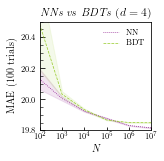

In [318]:
cs = ['purple', 'yellowgreen']
lss = [':', '--']
mae_plot([bce_avg, gbc_avg],
         ['NN', 'BDT'],
         Ns,
         stds = [bce_std, gbc_std],
         figsize = (2, 2),
         y_lim = (19.8, 20.5),
         cs = cs,
         lss = lss,
         title = r'NNs vs BDTs ($d = 4$)',
         filename = 'plots/pres/physics_d{}.pdf'.format(d))

### $d = 8$

In [237]:
# Experiment parameters
num = 0
reps = 100
d = 8
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat{}/ckpt-157'.format(d))
sim_ckpt.restore('flows/zenodo/sim{}/ckpt-157'.format(d))

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [ ]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    if N == 10**7:
        reps = 36
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [238]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [239]:
bce_avg

array([nan, nan, nan, nan, nan, nan])

In [240]:
gbc_avg

array([inf, inf, inf, inf, inf, inf])

In [241]:
bdt_avg

array([inf, inf, inf, inf, inf, inf])

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/zenodo_d{}.png'.format(d))

### $d = 11$

In [ ]:
# Experiment parameters
num = 0
reps = 100
d = 1
Ns = 10**np.arange(2, 8)

# Model parameters
bce_params = {'loss':bce, 'd': d}

filestr = 'models/zenodo/{}/set_{}/'.format(d, num)
bce_filestr = filestr + 'bce/model_{}_{}.h5'
gbc_filestr = filestr + 'gbc/model_{}_{}.h5'
bdt_filestr = filestr + 'bdt/model_{}.h5'

# True distribution information
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

dat_ckpt.restore('flows/zenodo/dat1/ckpt-157')
sim_ckpt.restore('flows/zenodo/sim1/ckpt-157')

lr = lambda x: tf.math.exp(dat_target.log_prob(x) - sim_target.log_prob(x)).numpy()

X_mae = np.load('data/zenodo/{}/X_tst.npy'.format(d))
lr_tst = lr(X_mae)
np.save('data/zenodo/{}/lr_tst.npy'.format(d), lr_tst)

def mae(model_lr):
    abs_dif = abs(model_lr(X_mae) - lr_tst)
    return abs_dif.mean()

#### Process

In [ ]:
X = np.load('data/zenodo/{}/X_trn.npy'.format(d))
y = np.load('data/zenodo/{}/y_trn.npy'.format(d))

# Calculate mean absolute errors
bce_avg = np.array([])
bce_std = np.array([])
gbc_avg = np.array([])
gbc_std = np.array([])
bdt_avg = np.array([])
bdt_std = np.array([])
for N in Ns:
    print(int(np.log10(N)), end = '\t')
    data, m, s = split_data(X[:N], y[:N])
    
    if N == 10**7:
        reps = 36
    
    bce_lrs = [None] * reps
    gbc_lrs = [None] * reps
    for i in range(reps):
        bce_model = create_model(**bce_params)
        bce_model.load_weights(bce_filestr.format(N, i))
        bce_lrs[i] = odds_lr(bce_model, m, s)
        
        gbc_model = load(gbc_filestr.format(N, i))
        gbc_lrs[i] = tree_lr(gbc_model)
        
    bce_maes = [mae(lr) for lr in bce_lrs]
    bce_avg = np.append(bce_avg, np.mean(bce_maes))
    bce_std = np.append(bce_std, np.std(bce_maes, ddof = 1))
    np.save(filestr + 'bce_avg', bce_avg)
    np.save(filestr + 'bce_std', bce_std)
    print(bce_avg[-1], end = '\t')
    
    gbc_maes = [mae(lr) for lr in gbc_lrs]
    gbc_avg = np.append(gbc_avg, np.mean(gbc_maes))
    gbc_std = np.append(gbc_std, np.std(gbc_maes, ddof = 1))
    np.save(filestr + 'gbc_avg', gbc_avg)
    np.save(filestr + 'gbc_std', gbc_std)
    print(gbc_avg[-1], end = '\t')
    
    # BDT MAE
    bdt = XGBClassifier(early_stopping_rounds = 10)
    bdt.load_model(bdt_filestr.format(N))
    bdt_lr = tree_lr(bdt)
    
    bdt_mae = mae(bdt_lr)
    bdt_avg = np.append(bdt_avg, bdt_mae)
    bdt_std = np.append(bdt_std, 0)
    np.save(filestr + 'bdt_avg', bdt_avg)
    np.save(filestr + 'bdt_std', bdt_std)
    print(bdt_avg[-1])

In [ ]:
np.save(filestr + 'bce_avg', bce_avg)
np.save(filestr + 'gbc_avg', gbc_avg)
np.save(filestr + 'bdt_avg', bdt_avg)

np.save(filestr + 'bce_std', bce_std)
np.save(filestr + 'gbc_std', gbc_std)
np.save(filestr + 'bdt_std', bdt_std)

#### Plot

In [ ]:
bce_avg = np.load(filestr + 'bce_avg.npy')
gbc_avg = np.load(filestr + 'gbc_avg.npy')
bdt_avg = np.load(filestr + 'bdt_avg.npy')

bce_std = np.load(filestr + 'bce_std.npy')
gbc_std = np.load(filestr + 'gbc_std.npy')
bdt_std = np.load(filestr + 'bdt_std.npy')

In [ ]:
mae_plot([bce_avg, gbc_avg, bdt_avg],
         ['BCE', 'SKL', 'XGB'],
         Ns,
         stds = [bce_std, gbc_std, bdt_std],
         figsize = (w, h),
         y_lim = (0, 0.4),
         title = r'\it $d = {}$'.format(d),
         filename = 'plots/trees/zenodo_d{}.png'.format(d))